# [Assignment 1](https://ovgu-ailab.github.io/idl2023/assignment1.html)
*Collaborative Work from Adrian Bremer & Philipp Reinig*

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__) # Check Tensorflow version
print(os.getcwd())



/Users/philippreinig/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.14.0
/Users/philippreinig/repos/idl/assignments_1


    ## MNIST-Tutorial 

In [2]:
class MNISTDataset:
    """'Bare minimum' class to wrap MNIST numpy arrays into a dataset."""
    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,
                 to01=True, shuffle=True, seed=None):
        """
        Use seed optionally to always get the same shuffling (-> reproducible
        results).
        """
        self.batch_size = batch_size
        self.train_data = train_imgs
        self.train_labels = train_lbs.astype(np.int32)
        self.test_data = test_imgs
        self.test_labels = test_lbls.astype(np.int32)

        if to01:
            # int in [0, 255] -> float in [0, 1]
            self.train_data = self.train_data.astype(np.float32) / 255
            self.test_data = self.test_data.astype(np.float32) / 255

        self.size = self.train_data.shape[0]

        if seed:
            np.random.seed(seed)
        if shuffle:
            self.shuffle_train()
        self.shuffle = shuffle
        self.current_pos = 0

    def next_batch(self):
        """Either gets the next batch, or optionally shuffles and starts a
        new epoch."""
        end_pos = self.current_pos + self.batch_size
        if end_pos < self.size:
            batch = (self.train_data[self.current_pos:end_pos],
                     self.train_labels[self.current_pos:end_pos])
            self.current_pos += self.batch_size
        else:
            # we return what's left (-> possibly smaller batch!) and prepare
            # the start of a new epoch
            batch = (self.train_data[self.current_pos:self.size],
                     self.train_labels[self.current_pos:self.size])
            if self.shuffle:
                self.shuffle_train()
            self.current_pos = 0
            #print("Starting new epoch...")
        return batch

    def shuffle_train(self):
        shuffled_inds = np.arange(self.train_data.shape[0])
        np.random.shuffle(shuffled_inds)
        self.train_data = self.train_data[shuffled_inds]
        self.train_labels = self.train_labels[shuffled_inds]

### Visualization of the first image

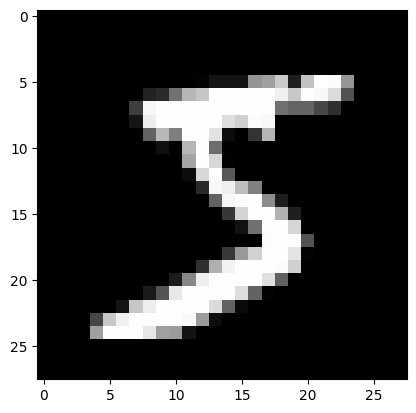

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

np.set_printoptions(threshold=100)

plt.imshow(train_images[0], cmap="Greys_r")

## Setting up and training the model

In [4]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

train_steps = 1000
learning_rate = 0.1

W = tf.Variable(np.zeros([784, 10]).astype(np.float32))
b = tf.Variable(np.zeros(10, dtype=np.float32))


for step in range(train_steps):
    img_batch, lbl_batch = data.next_batch()
    with tf.GradientTape() as tape:
        logits = tf.matmul(img_batch, W) + b
        # print(img_batch.shape)
        # print(W.shape)
        # print(b.shape)
        # print(logits.shape)
        xent_v = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch)
        xent = tf.reduce_mean(xent_v)
        
    grads = tape.gradient(xent, [W, b])
    W.assign_sub(learning_rate * grads[0])
    b.assign_sub(learning_rate * grads[1])
    
    if step % 100 == 0:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

print("Done!")

Loss: 2.3025853633880615 Accuracy: 0.109375
Loss: 0.5508027076721191 Accuracy: 0.8515625
Loss: 0.4509827792644501 Accuracy: 0.8828125
Loss: 0.48448556661605835 Accuracy: 0.84375
Loss: 0.4440799057483673 Accuracy: 0.8984375
Loss: 0.34230393171310425 Accuracy: 0.921875
Loss: 0.3934829831123352 Accuracy: 0.890625
Loss: 0.48972901701927185 Accuracy: 0.859375
Loss: 0.3443768322467804 Accuracy: 0.90625
Loss: 0.3349449634552002 Accuracy: 0.90625
Done!


## Testing

In [5]:
test_preds = tf.argmax(tf.matmul(data.test_data, W) + b, axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                             tf.float32))
print(acc)

tf.Tensor(0.91, shape=(), dtype=float32)


# Building a Deep Model

## Hidden Layer
Using a variable size "N" for the hidden layer.
The previous layer with 10 Outputs represents the Output-Layer. 
Therefore, the hidden weights get a shape of Nx784 and the Output-Weights will get a shape of 10xN.

In [6]:
N = 20

def init(hidden_size):
    # initialising weights with small random values
    # and biases with small positive values (alternatively with zeros)
    W_ih = tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=(784, hidden_size)).astype(np.float32))
    b_h = tf.Variable(np.random.uniform(low=0.0, high=0.1, size=hidden_size).astype(np.float32))
    W_ho = tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=(hidden_size, 10)).astype(np.float32))
    b_o = tf.Variable(np.random.uniform(low=0.0, high=0.1, size=10).astype(np.float32))
    
    return (W_ih, b_h, W_ho, b_o)


def train(net, train_steps):
    W_ih, b_h, W_ho, b_o = net
    

    for step in range(train_steps):
        img_batch, lbl_batch = data.next_batch()
        with tf.GradientTape() as tape:
            tape.watch([W_ih, b_h, W_ho, b_o])

            hidden_logits = tf.matmul(img_batch, W_ih) + b_h
            # DON'T USE SOFTMAX HERE - IT IS AWFUL!
            hidden_relu = tf.nn.relu(hidden_logits)

            logits = tf.matmul(hidden_relu, W_ho) + b_o
            xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=lbl_batch))

        grads = tape.gradient(xent, [W_ih, b_h, W_ho, b_o])
        W_ih.assign_sub(learning_rate * grads[0])
        b_h.assign_sub(learning_rate * grads[1])
        W_ho.assign_sub(learning_rate * grads[2])
        b_o.assign_sub(learning_rate * grads[3])

        if not step % 100:
            preds = tf.argmax(logits, axis=1, output_type=tf.int32)
            acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                                 tf.float32))
            #print("Loss: {} Accuracy: {}".format(xent, acc))

    #print("Done!")
    
    #return (xent,acc)
    
train(init(N), train_steps)
print("Done")

Done


## Find best size N for hidden layer 

N = 1000, acc=0.9452000260353088
N = 2000, acc=0.9550999999046326
N = 3000, acc=0.9577999711036682
N = 4000, acc=0.9613000154495239
N = 5000, acc=0.9621999859809875
N = 6000, acc=0.9639000296592712
N = 7000, acc=0.9682999849319458
N = 8000, acc=0.9668999910354614
N = 9000, acc=0.9652000069618225
N = 10000, acc=0.9685999751091003
N = 11000, acc=0.9678000211715698


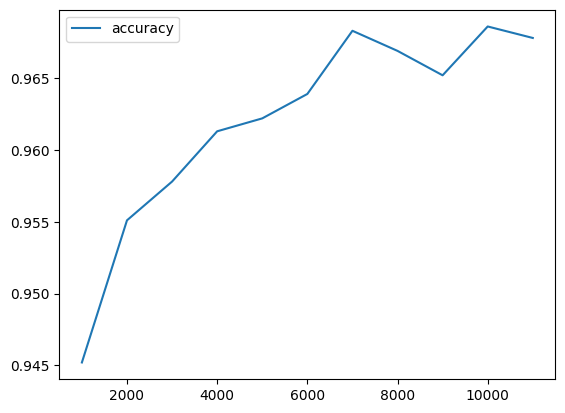

In [7]:
#losses = []
accs = []
sizes = np.arange(1000,11001, 1000, dtype=np.int32)

for n in sizes:
    W_ih, b_h, W_ho, b_o = init(n)
    train((W_ih, b_h, W_ho, b_o), train_steps)
    
    # Testing
    hidden_logits = tf.matmul(data.test_data, W_ih) + b_h
    hidden_relu = tf.nn.relu(hidden_logits)
    logits = tf.matmul(hidden_relu, W_ho) + b_o
    test_preds = tf.argmax(tf.nn.softmax(logits), axis=1, output_type=tf.int32)
    
    acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                                 tf.float32))
    
    #losses.append(loss)
    accs.append(acc)
    
    print("N = {}, acc={}".format(n, acc))
    
plt.plot(sizes, accs, label='accuracy')
plt.legend()

plt.savefig('plot.svg')
plt.show()

## Different Initializations

N = 10, acc=0.7224000096321106
N = 11, acc=0.7703999876976013
N = 12, acc=0.7549999952316284
N = 13, acc=0.781000018119812
N = 14, acc=0.7651000022888184
N = 15, acc=0.7477999925613403
N = 16, acc=0.7870000004768372
N = 17, acc=0.801800012588501
N = 18, acc=0.7775999903678894
N = 19, acc=0.8036999702453613
N = 20, acc=0.8181999921798706
N = 21, acc=0.789900004863739
N = 22, acc=0.7929999828338623
N = 23, acc=0.7940000295639038
N = 24, acc=0.8147000074386597
N = 25, acc=0.8183000087738037
N = 26, acc=0.8251000046730042
N = 27, acc=0.822700023651123
N = 28, acc=0.8238999843597412
N = 29, acc=0.8219000101089478
N = 30, acc=0.7958999872207642
N = 31, acc=0.8385000228881836
N = 32, acc=0.8251000046730042
N = 33, acc=0.84579998254776
N = 34, acc=0.815500020980835
N = 35, acc=0.824999988079071
N = 36, acc=0.8384000062942505
N = 37, acc=0.8299000263214111
N = 38, acc=0.8364999890327454
N = 39, acc=0.8435999751091003
N = 40, acc=0.8513000011444092
N = 41, acc=0.8208000063896179
N = 42, acc=0.82

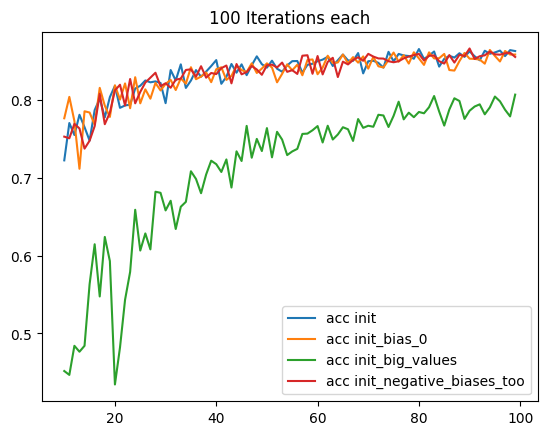

In [8]:
def init_bias_0(hidden_size):
    W_ih = tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=(784, hidden_size)).astype(np.float32))
    b_h = tf.Variable(np.zeros(hidden_size, dtype=np.float32))
    W_ho = tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=(hidden_size, 10)).astype(np.float32))
    b_o = tf.Variable(np.zeros(10, dtype=np.float32))
    
    return (W_ih, b_h, W_ho, b_o)

def init_big_values(hidden_size):
    W_ih = tf.Variable(np.random.uniform(low=-1.0, high=1.0, size=(784, hidden_size)).astype(np.float32))
    b_h = tf.Variable(np.random.uniform(low=0.0, high=1.0, size=hidden_size).astype(np.float32))
    W_ho = tf.Variable(np.random.uniform(low=-1.0, high=1.0, size=(hidden_size, 10)).astype(np.float32))
    b_o = tf.Variable(np.random.uniform(low=0.0, high=1.0, size=10).astype(np.float32))
    
    return (W_ih, b_h, W_ho, b_o)

def init_negative_biases_too(hidden_size):
    W_ih = tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=(784, hidden_size)).astype(np.float32))
    b_h = tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=hidden_size).astype(np.float32))
    W_ho = tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=(hidden_size, 10)).astype(np.float32))
    b_o = tf.Variable(np.random.uniform(low=-0.1, high=0.1, size=10).astype(np.float32))
    
    return (W_ih, b_h, W_ho, b_o)


dates = []
accs = []
sizes = np.arange(10,100, dtype=np.int32)

init_funcs = [init, init_bias_0, init_big_values, init_negative_biases_too]

for init_func in init_funcs:
    for n in sizes:
        W_ih, b_h, W_ho, b_o = init_func(n)
        train((W_ih, b_h, W_ho, b_o), 100)

        # Testing
        hidden_logits = tf.matmul(data.test_data, W_ih) + b_h
        hidden_relu = tf.nn.relu(hidden_logits)
        logits = tf.matmul(hidden_relu, W_ho) + b_o
        test_preds = tf.argmax(tf.nn.softmax(logits), axis=1, output_type=tf.int32)

        acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                                     tf.float32))

        #losses.append(loss)
        accs.append(acc)

        print("N = {}, acc={}".format(n, acc))
        
    dates.append(accs)
    accs = []


plt.plot(sizes, dates[0], label='acc init')
plt.plot(sizes, dates[1], label='acc init_bias_0')
plt.plot(sizes, dates[2], label='acc init_big_values')
plt.plot(sizes, dates[3], label='acc init_negative_biases_too')

plt.legend()
plt.title('100 Iterations each')

plt.savefig('plot.svg')
plt.show()

## Questions

### Why don't initialise with 0?
Because then the hidden layer is producing - no matter the input - the same output in the first iteration. 
And even worse: During backpropagation no weights get changed, because every needed change is multiplied by zero (in the hidden layer).

## Experiments

### Different activation functions
First we used softmax in the hidden layer. This produced a maximum accuracy of 0.5 and a minimum loss of more than 1. So we switched to ReLU for the hidden layer and we got accuracy over 90% and a loss of about 0.1

### Different hidden layer sizes
<img src="plt_incr-N.svg">
<img src="plt_incr-N_2.svg">

Like one can see in the diagram the more nodes we have inside the hidden layer, the more accuracy can be reached after a fixed amount of iterations (1000). There are some varaitions, but we did only 1 run. But the tendence is clear.

But we have to consider that after about 40 nodes in the hidden layer, the improvements are negetibly small. Therefore, one shouldn't choose a much bigger hidden layer because we don't gain that much more performance for the huge amounts of extra computation for bigger layers.

### Different weight initializations
<img src="plt_different-init.svg">
<img src="plt_different-init_2.svg">

One can see in the diagram that initialising with small values is extremly important. Initialising the biases with zero seems to be the best way to go, espacially for small hidden layers. But there isn't much difference.


## Tensorflow Interface

### Suggestions for High-level interfaces
- initialization inside a constructor where you specify the layer sizes - probably with options to tell how to initialize 
- feed forward in one method (matrix multiplication an addition with straight forward pattern) -> for really deep networks really tidious
- use this feed forward method inside a train method -> does back propagation for the user (again: straight forward pattern)

### Wishes for currently missing features
- **_TODO_**

### Redundant information
You get forced a lot to give redundant information. E.G. Specify the sizes of the matrices, but they depend on the layer sizes, specify the feed forward calculations for every single layer, even it is a mechanical task, tell the GradientTape which variables to differentiate by and subtract the changes from every single weight matrix and bias vector. 
This can easily be packaged inside the specified methods.


# Bonus
## Visualizing wrong classified data

[   8   33   92 ... 9980 9982 9986]


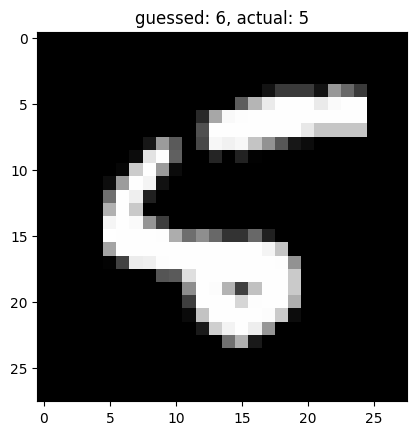

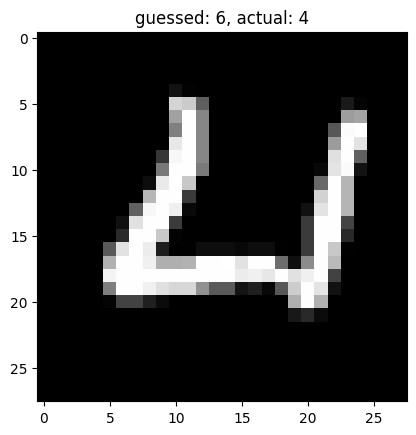

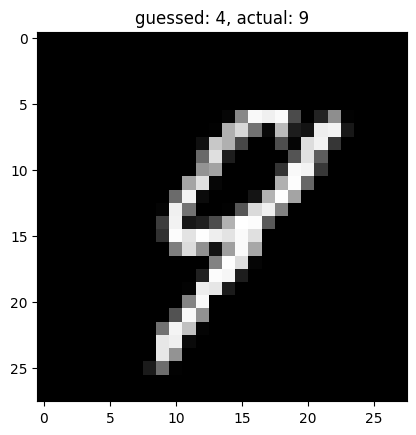

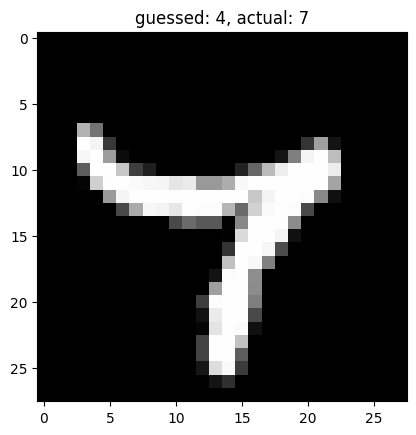

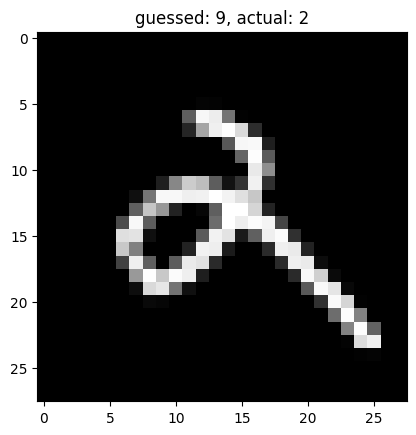

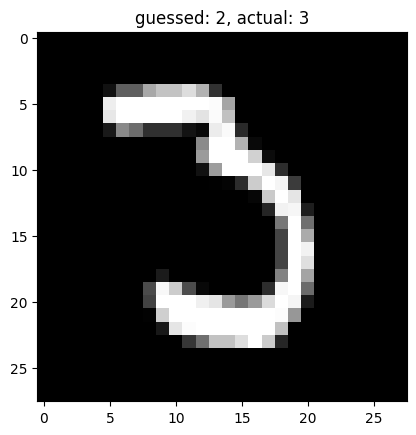

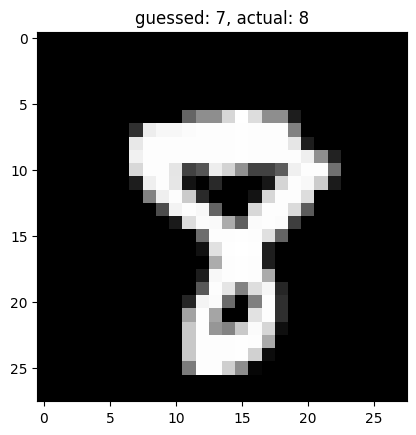

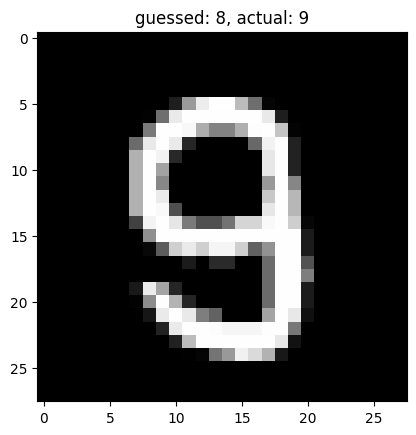

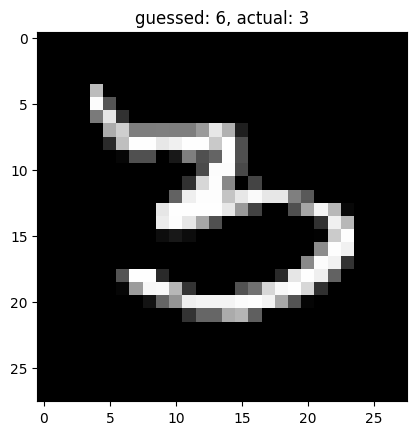

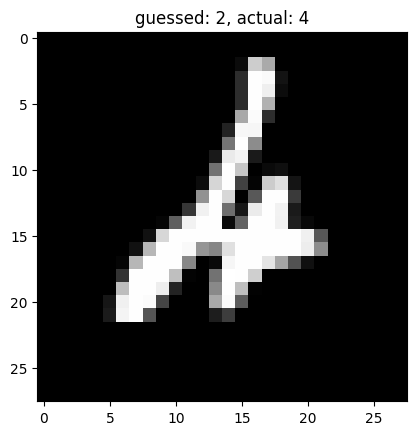

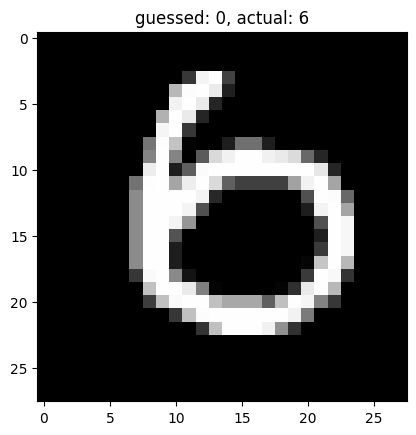

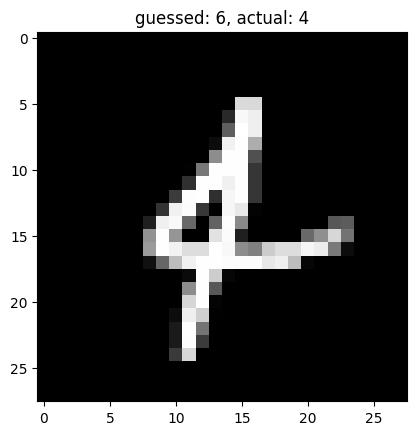

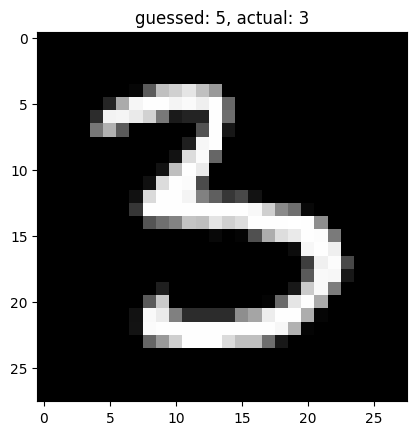

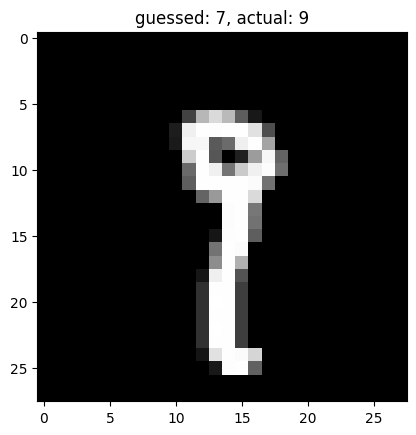

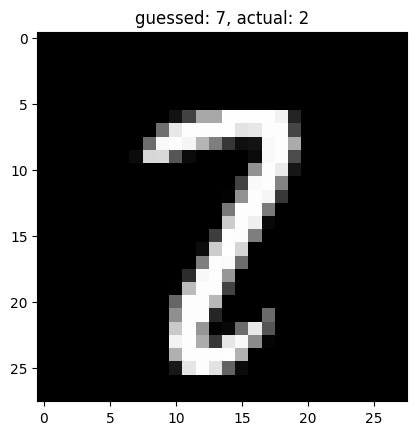

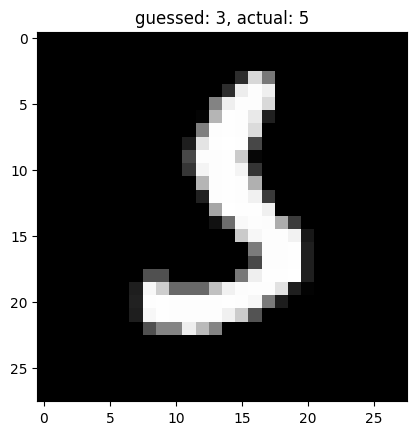

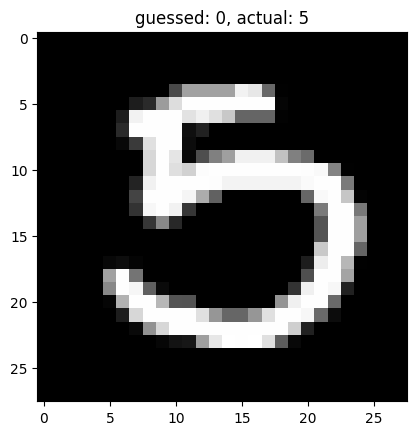

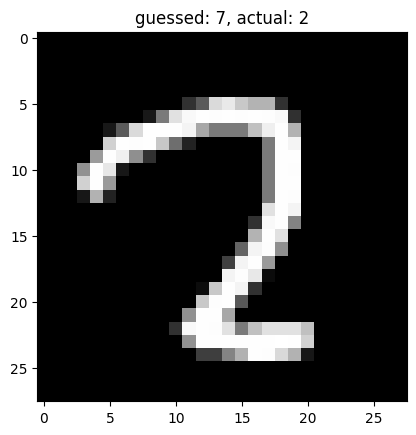

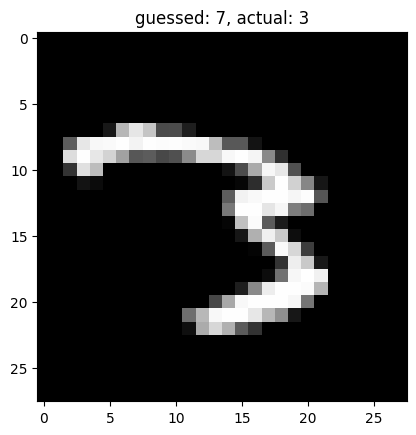

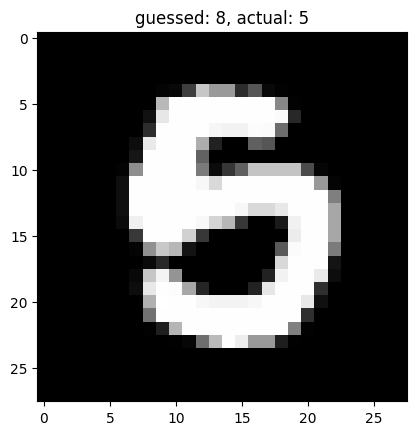

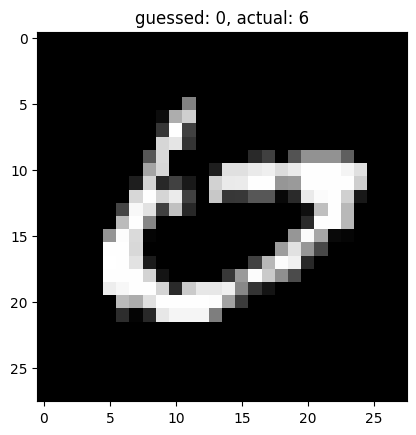

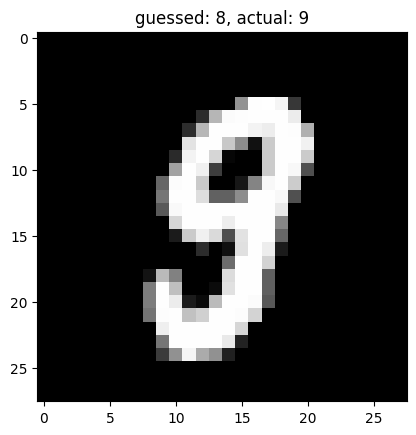

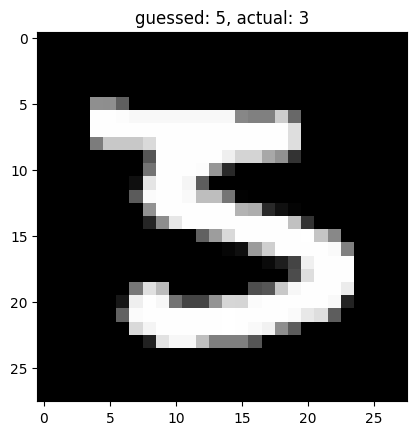

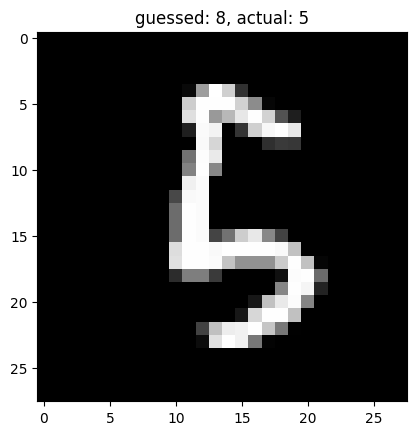

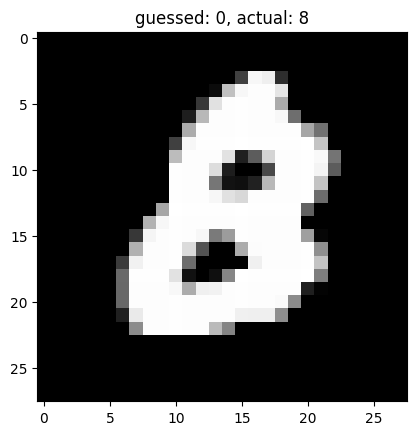

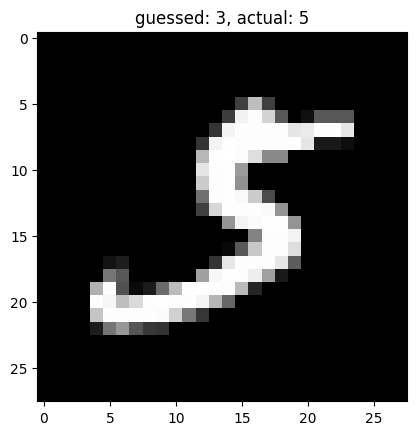

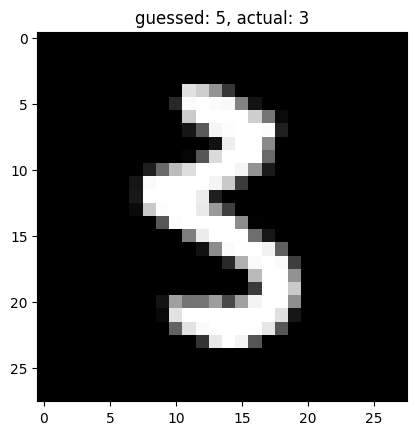

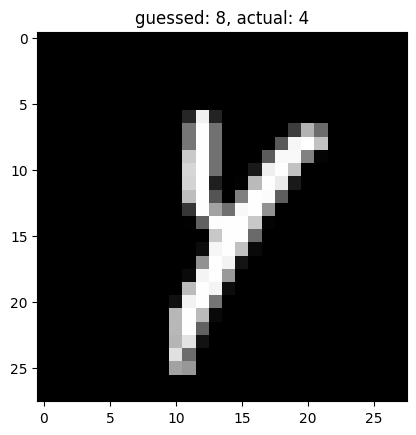

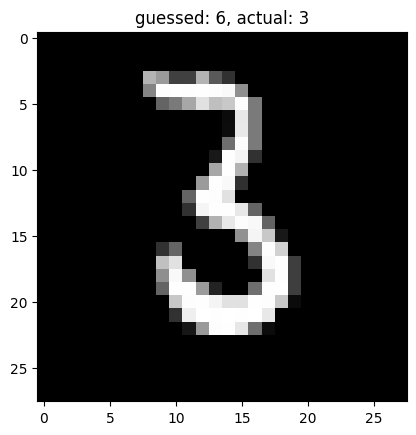

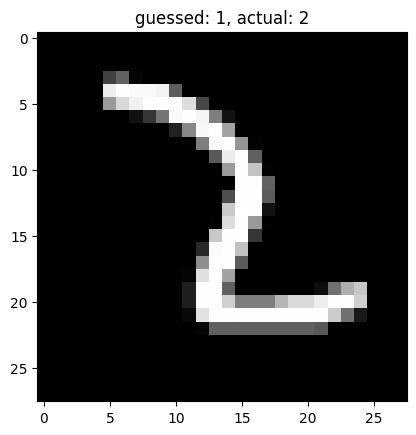

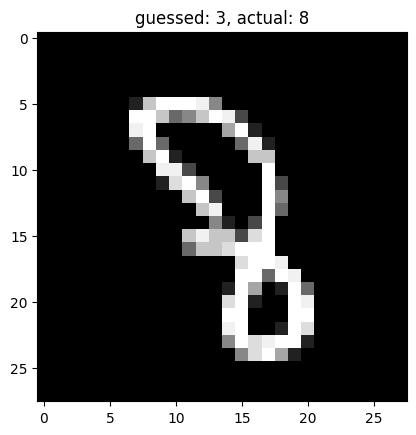

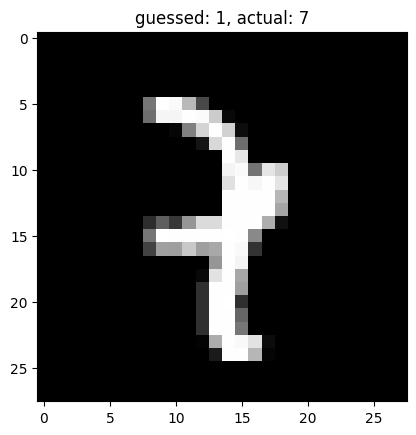

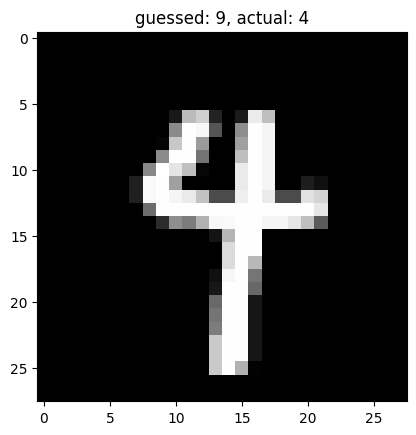

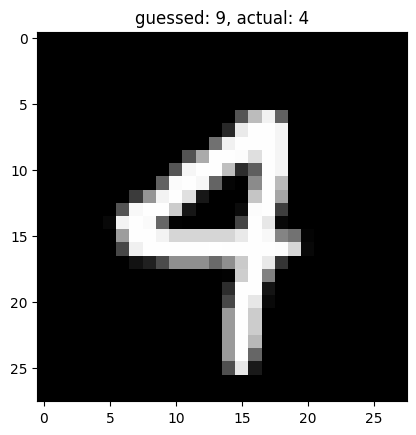

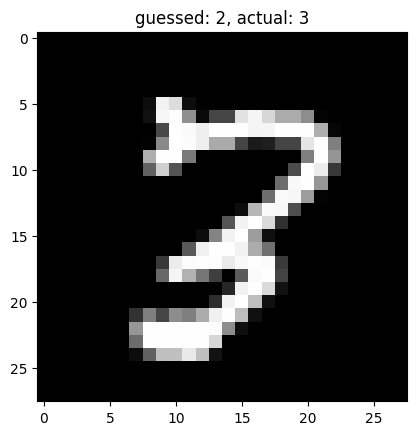

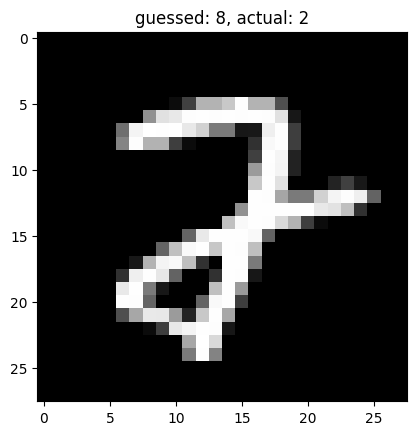

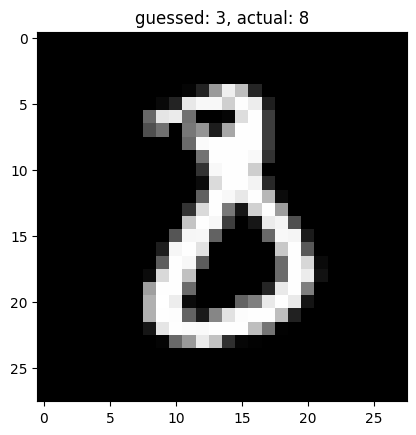

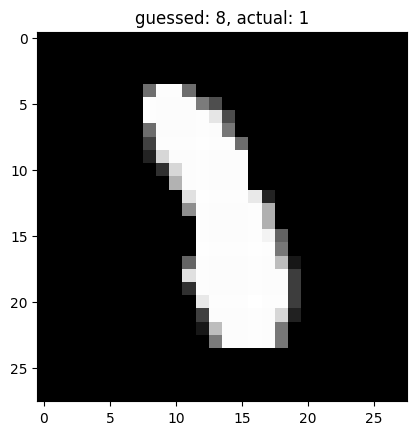

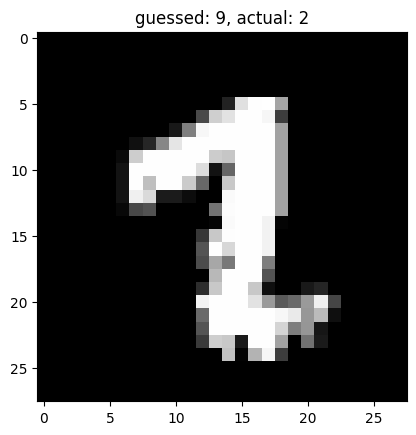

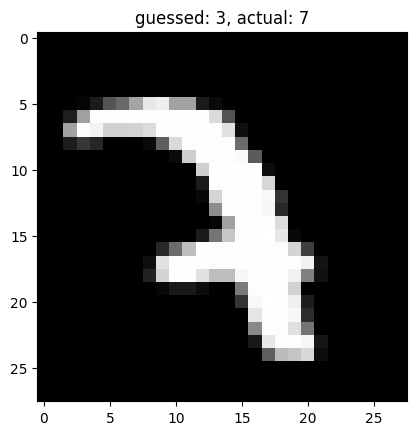

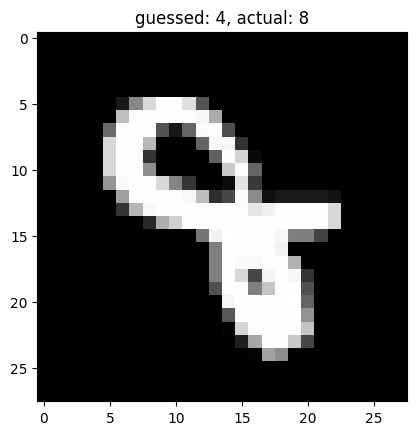

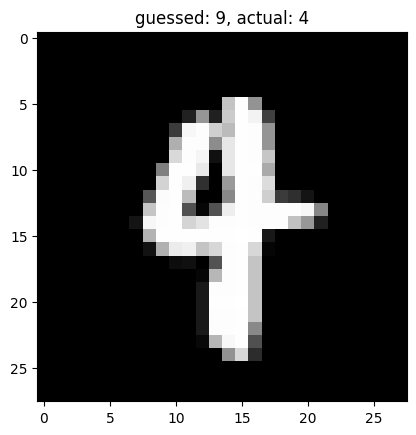

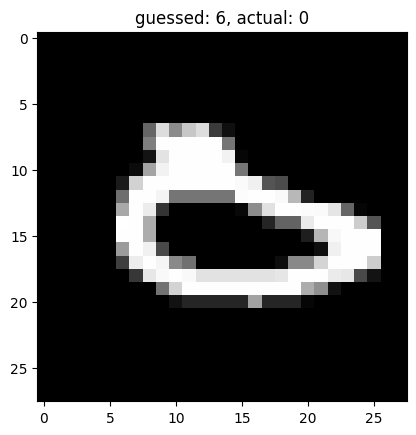

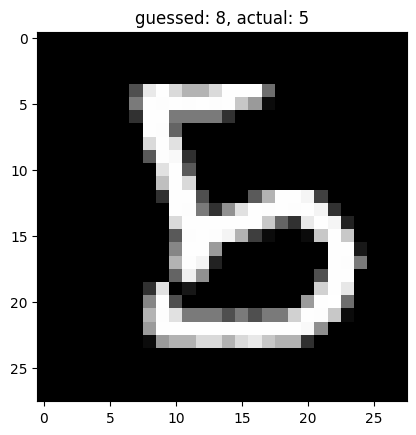

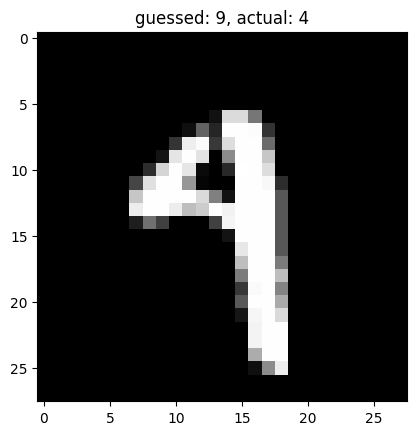

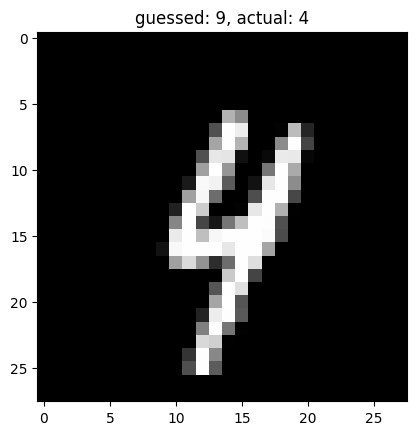

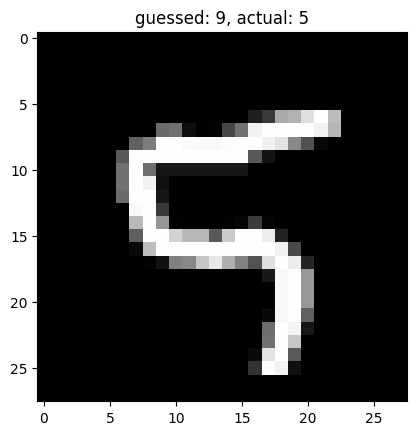

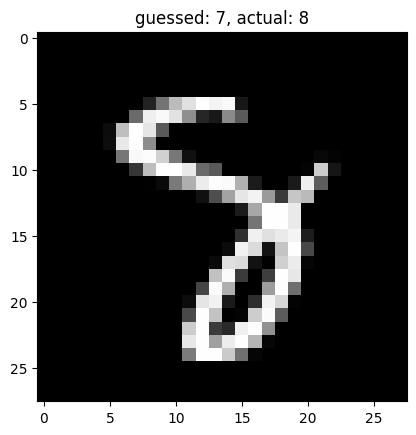

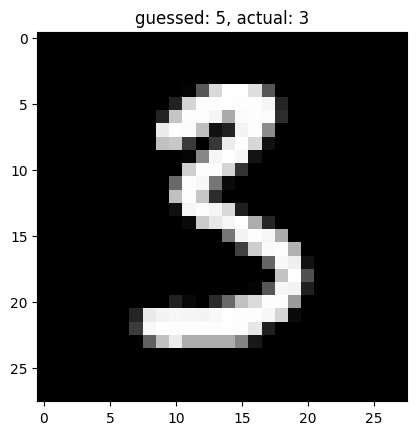

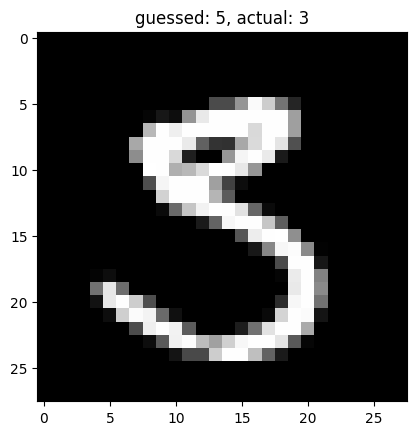

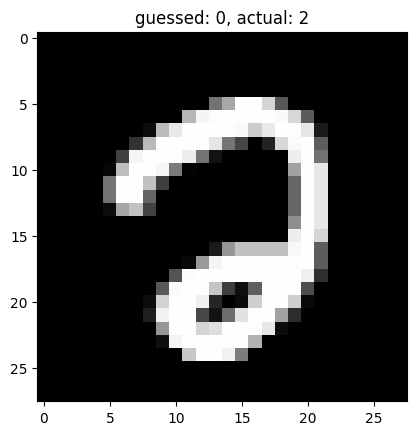

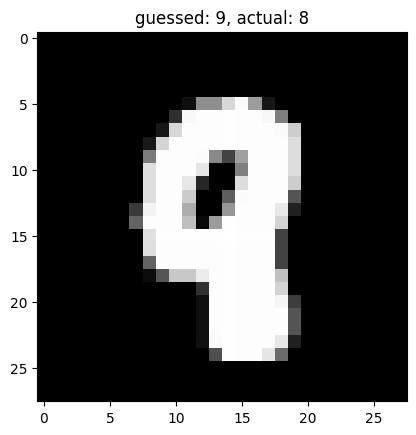

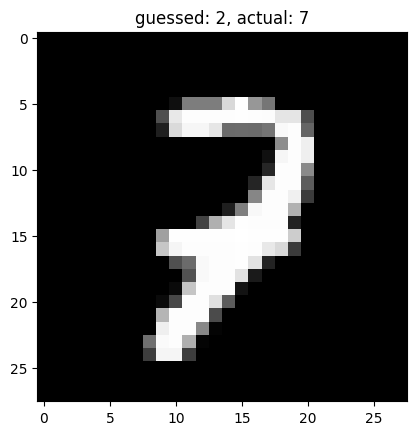

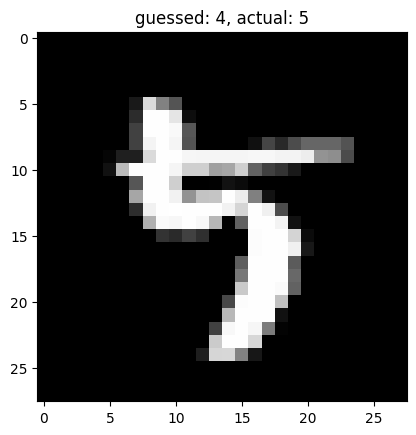

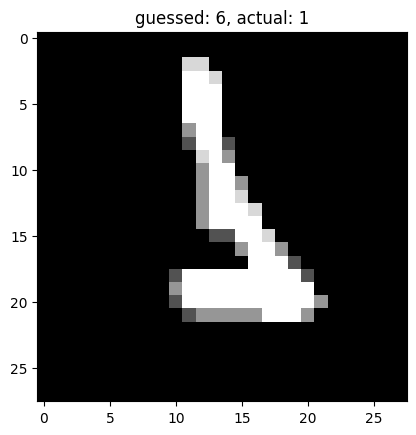

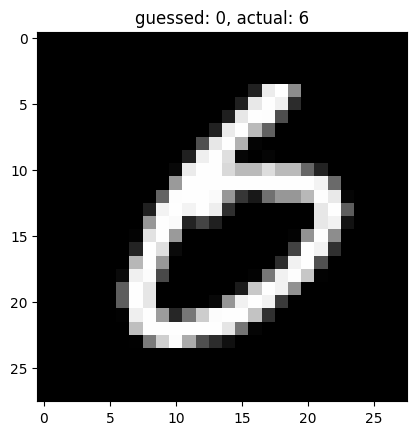

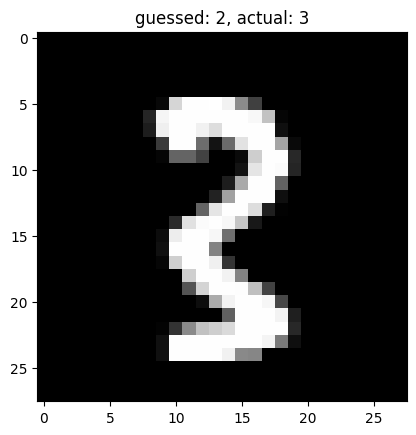

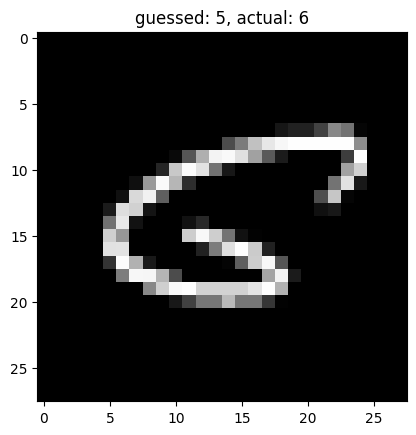

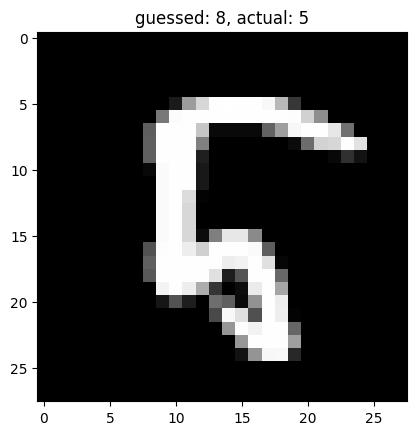

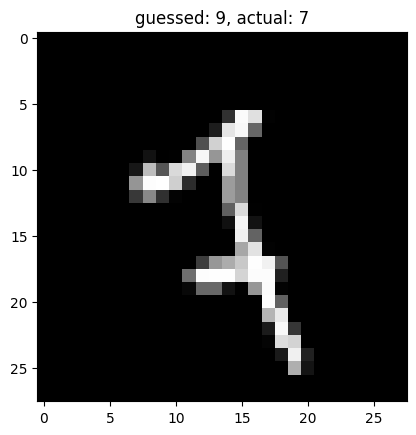

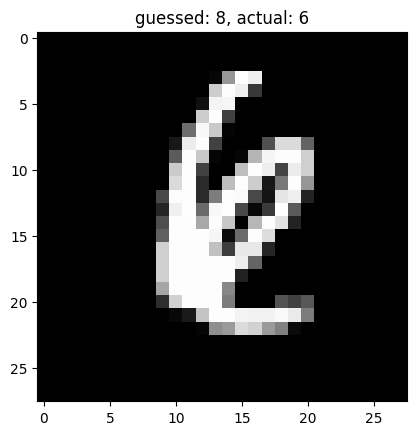

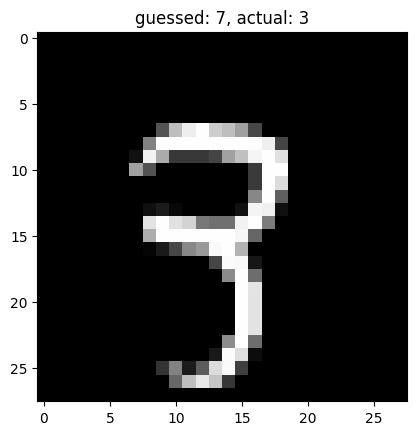

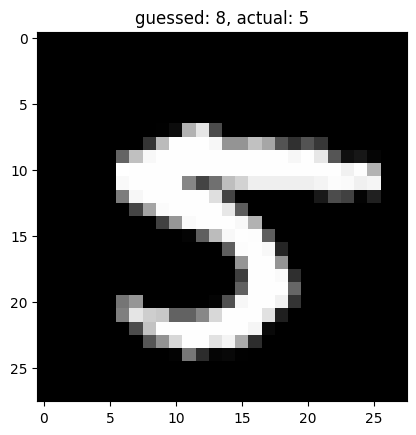

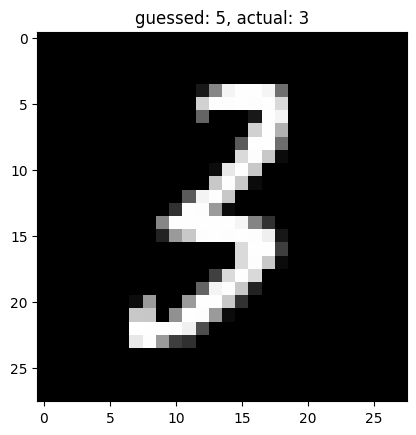

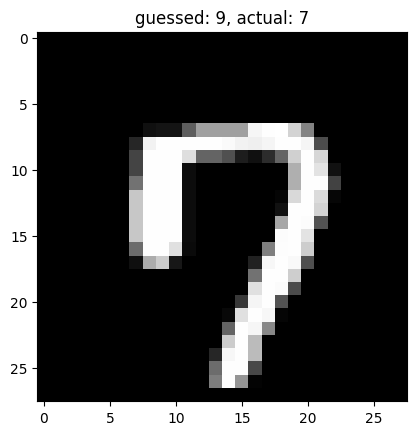

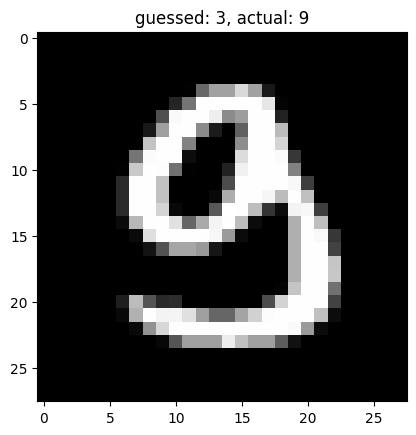

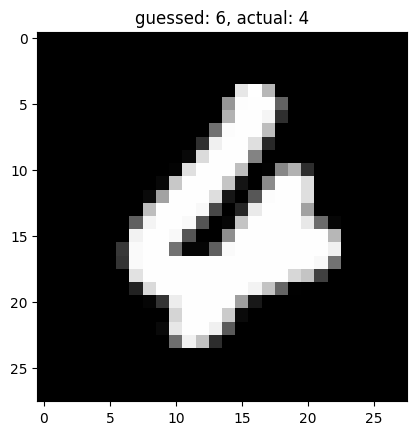

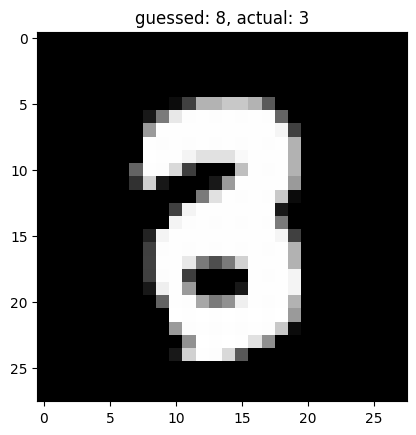

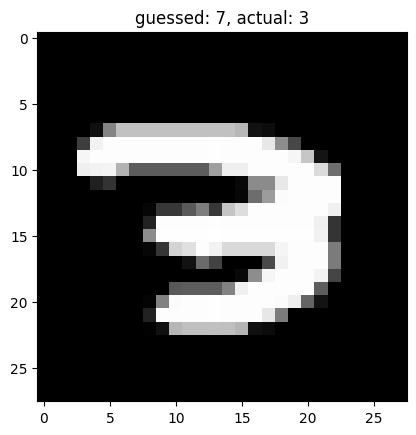

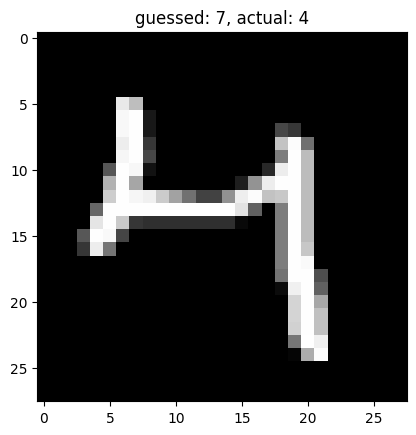

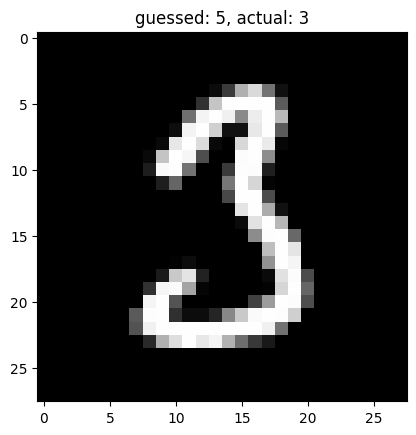

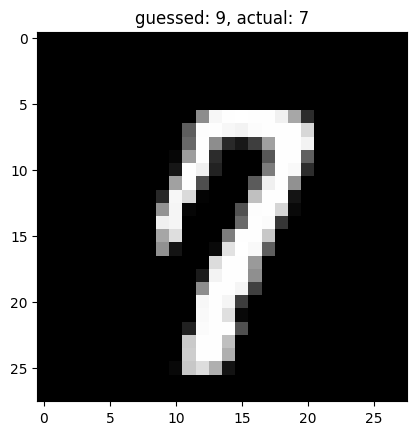

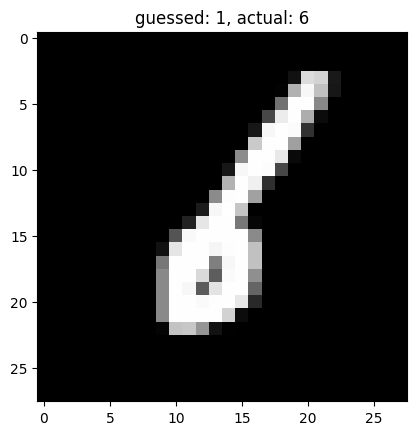

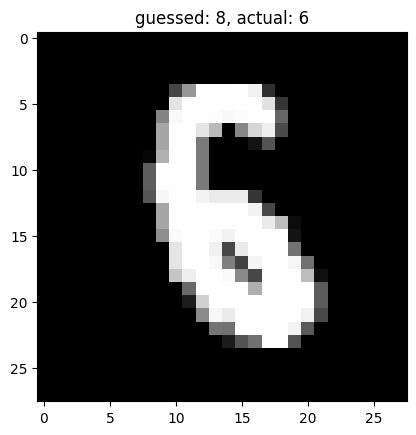

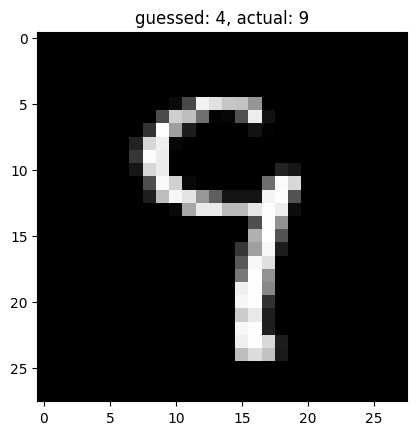

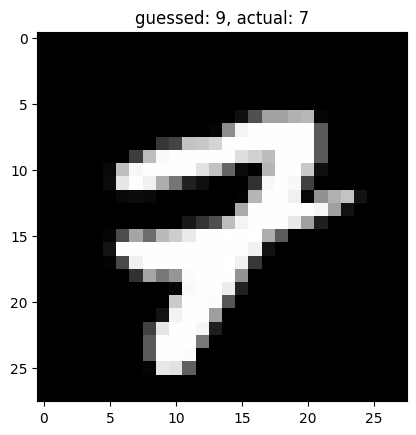

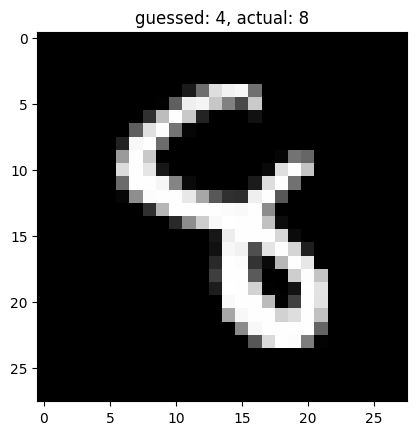

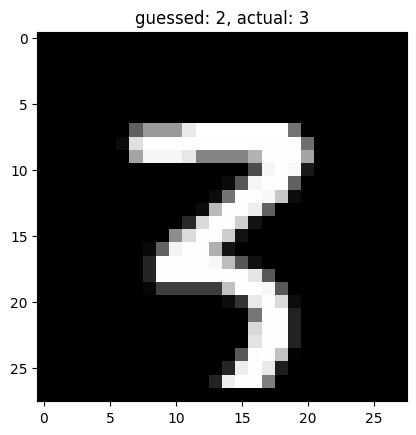

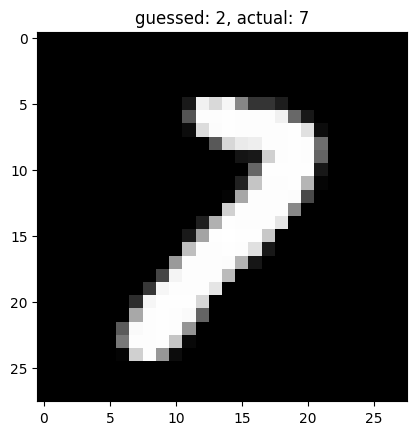

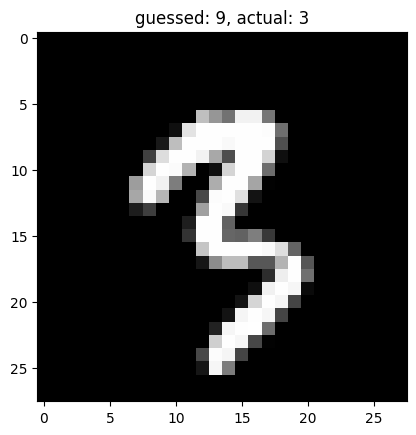

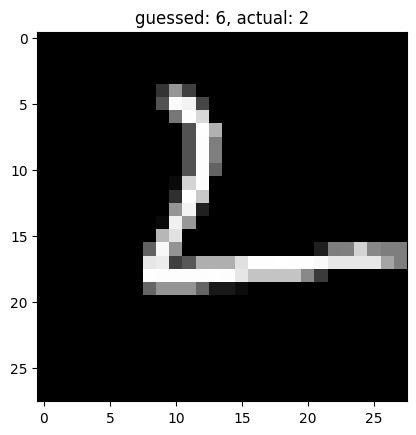

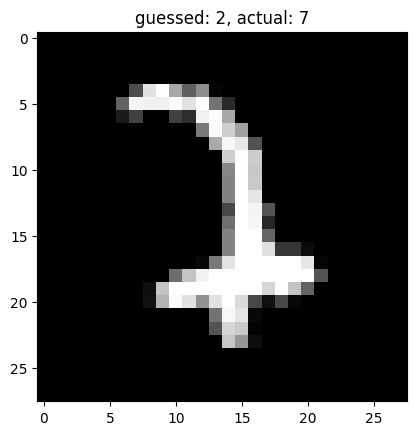

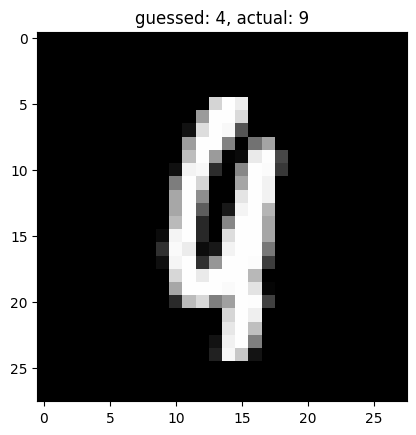

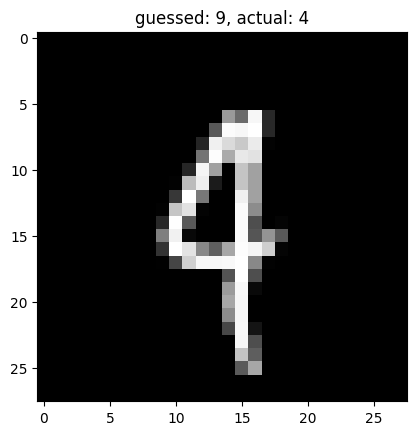

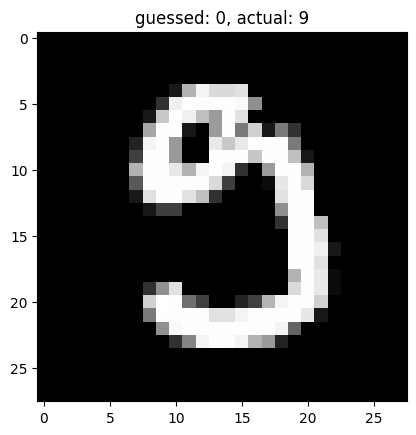

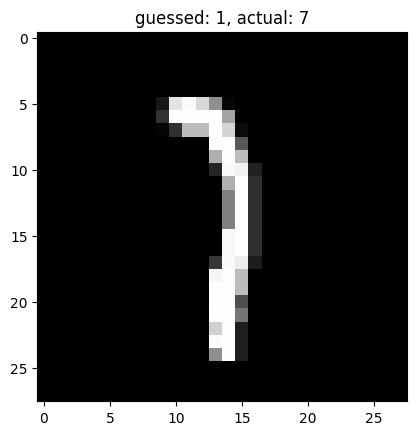

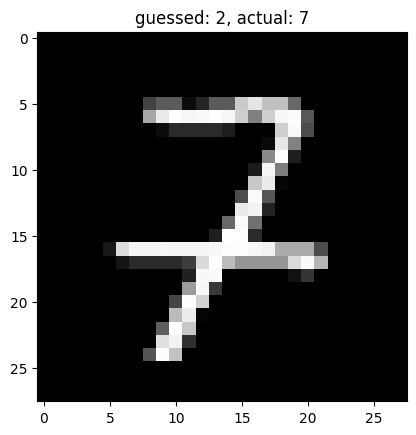

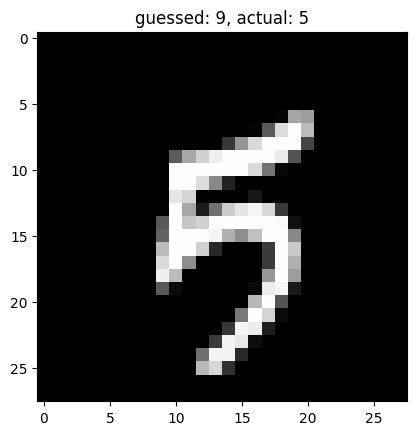

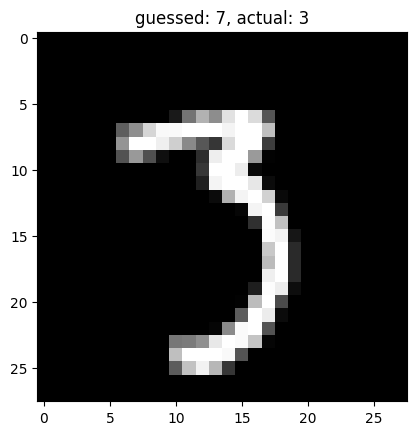

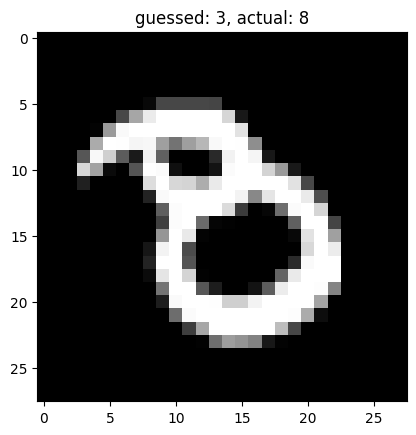

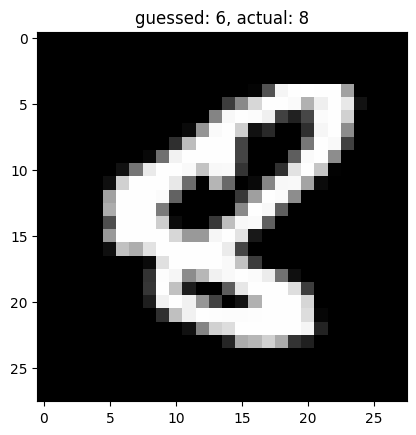

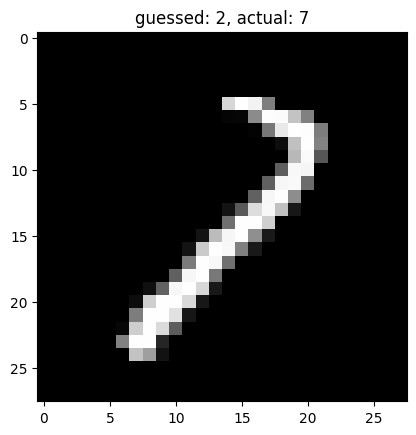

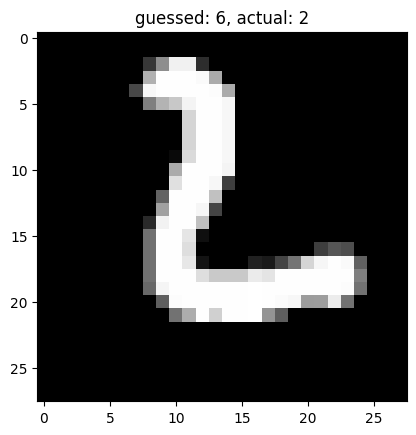

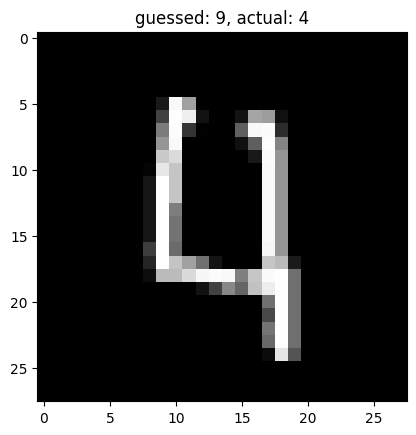

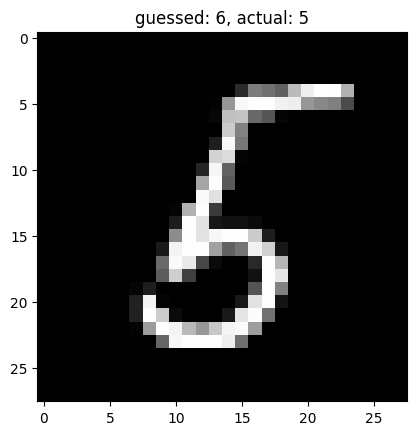

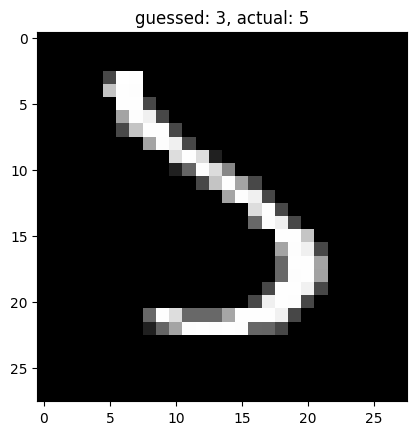

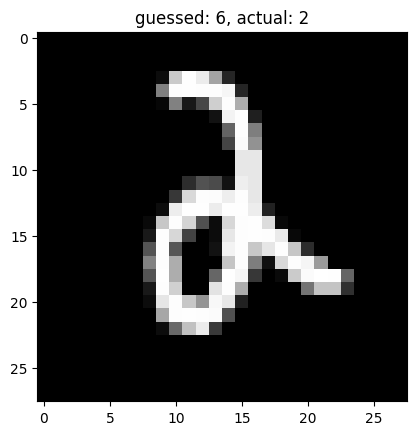

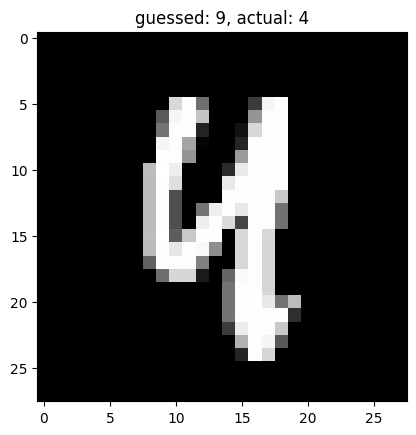

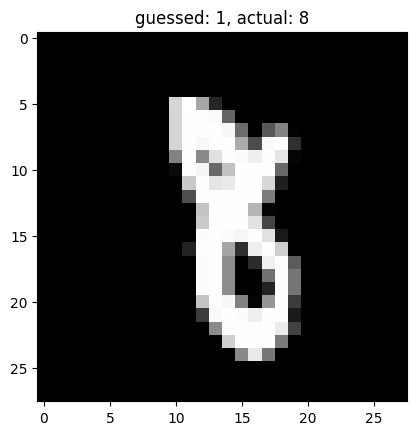

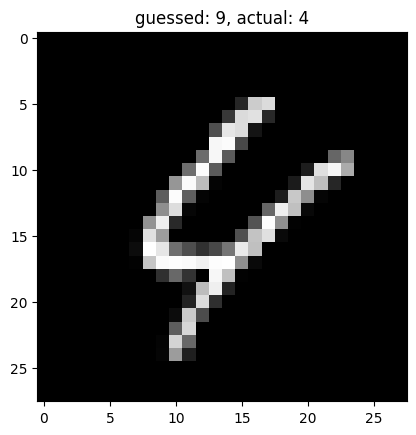

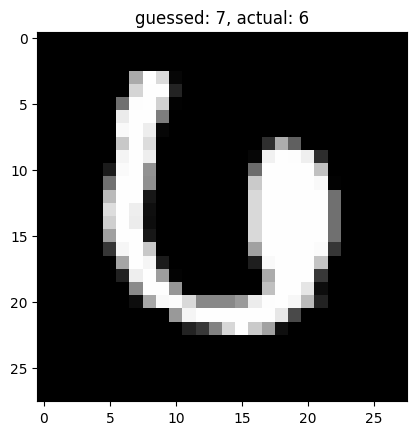

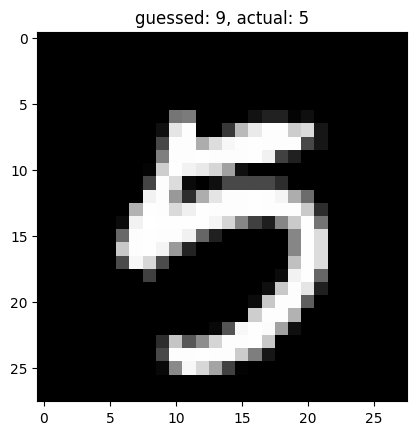

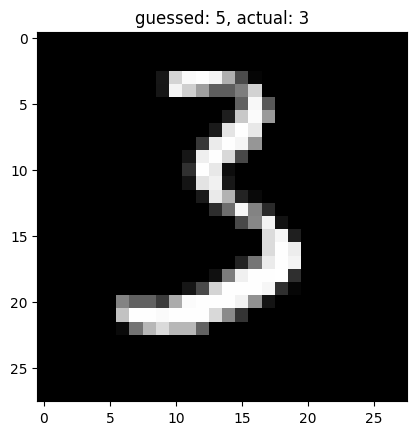

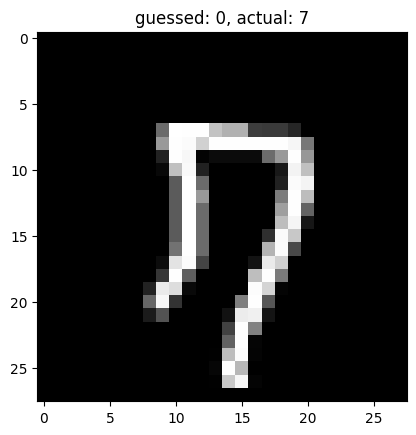

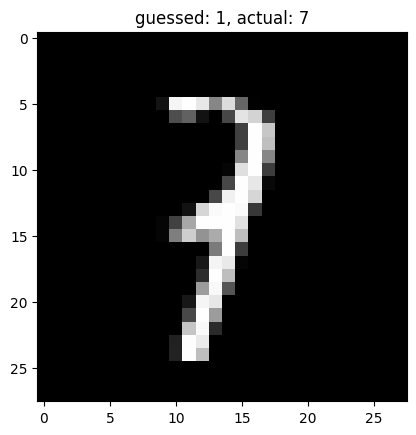

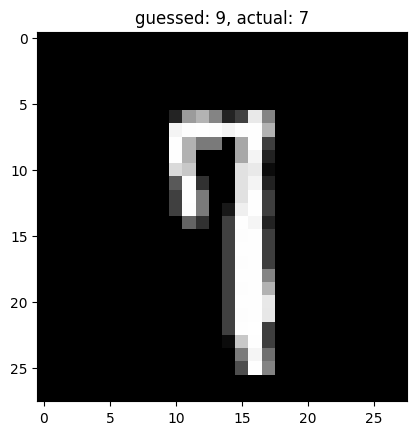

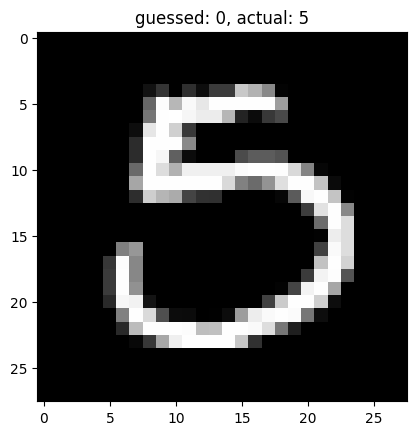

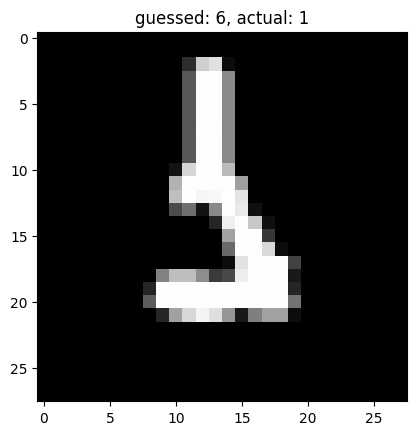

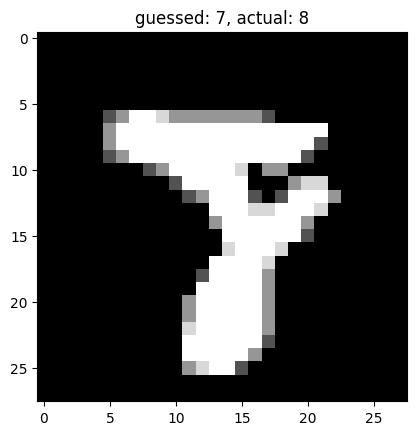

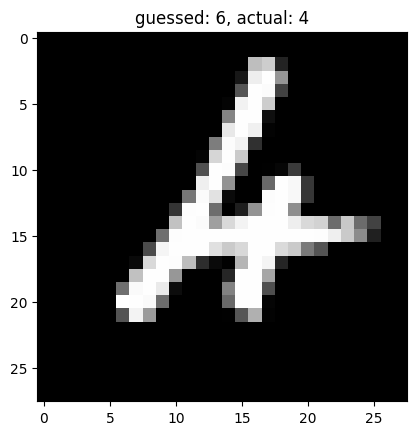

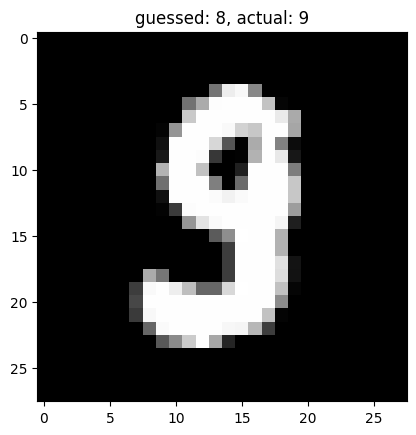

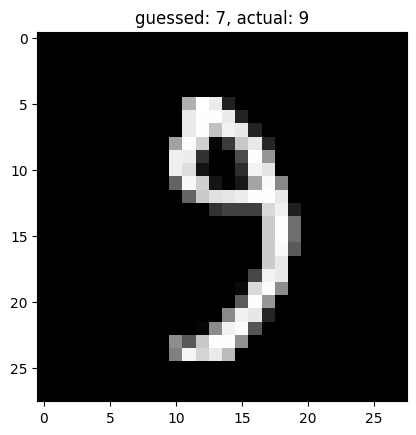

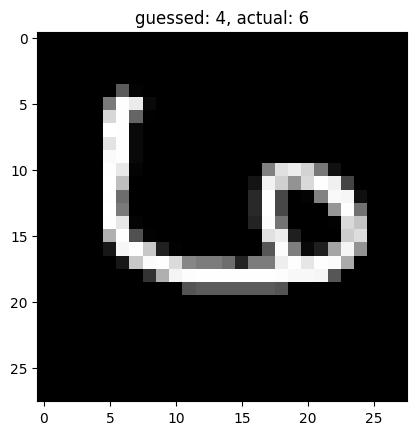

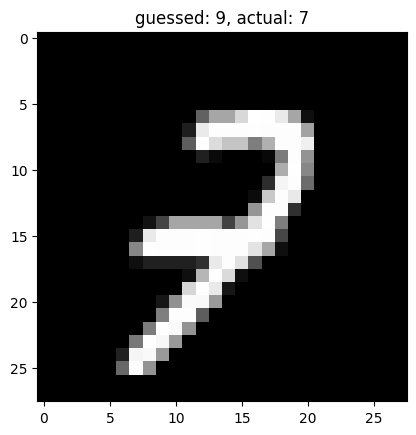

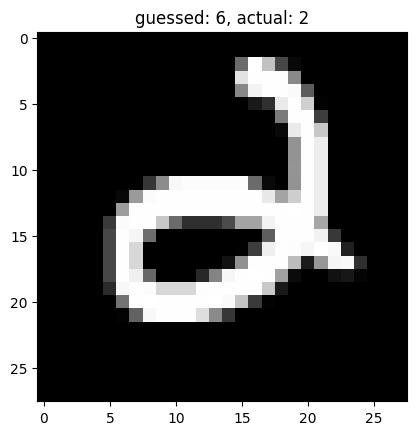

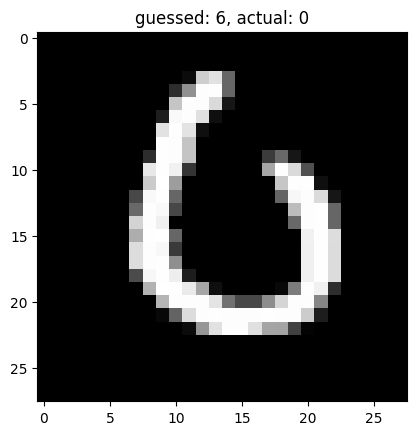

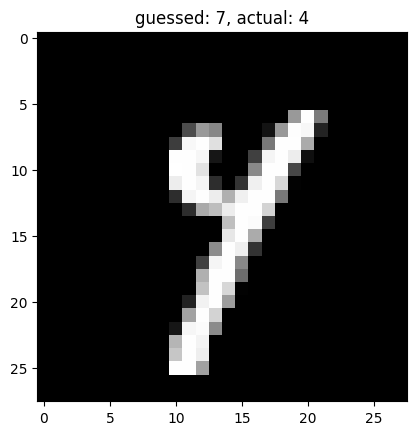

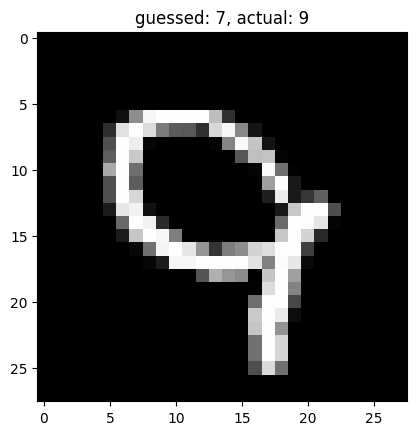

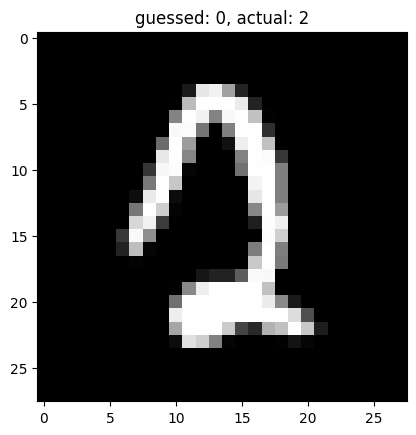

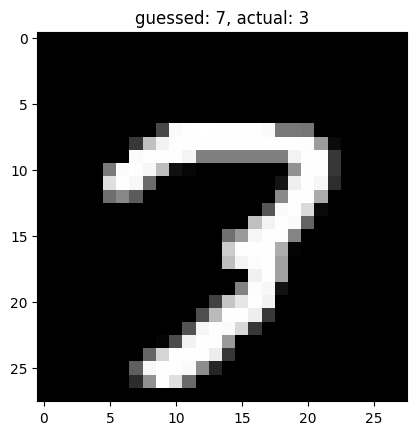

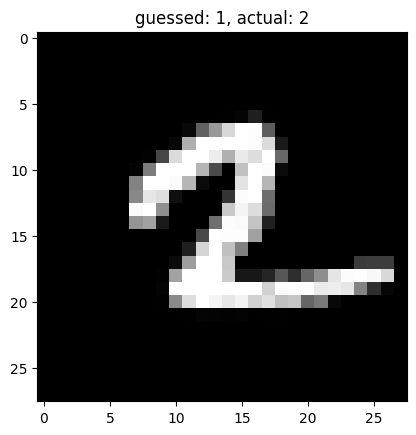

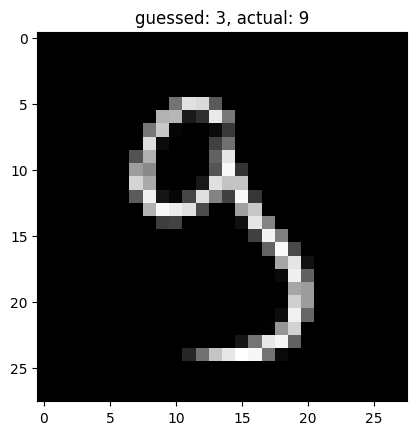

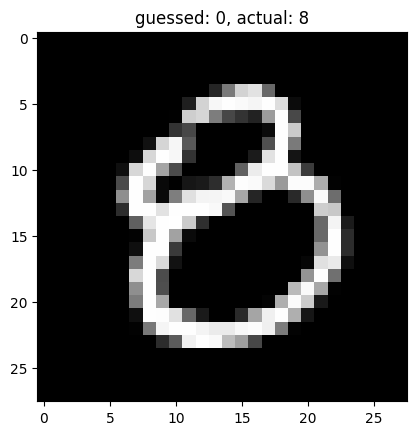

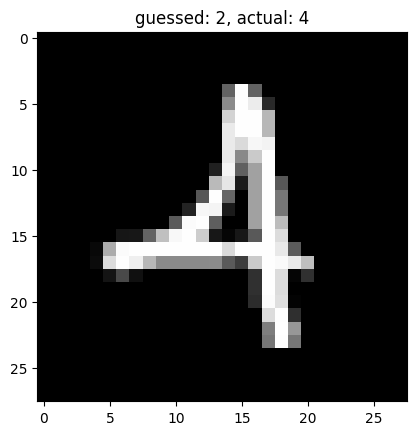

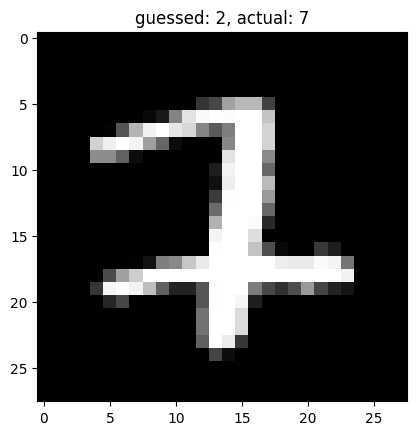

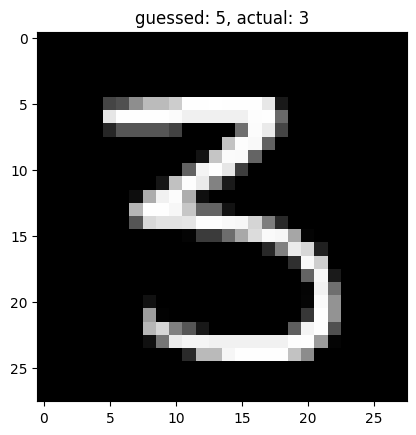

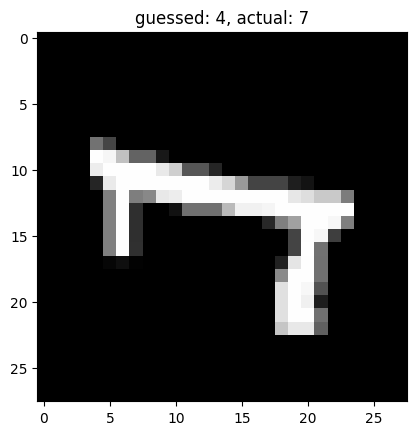

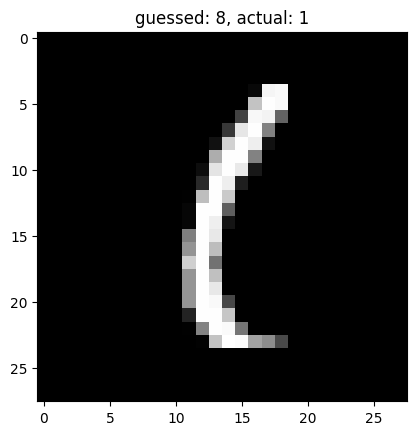

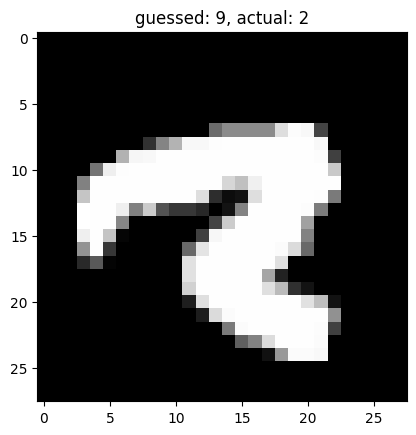

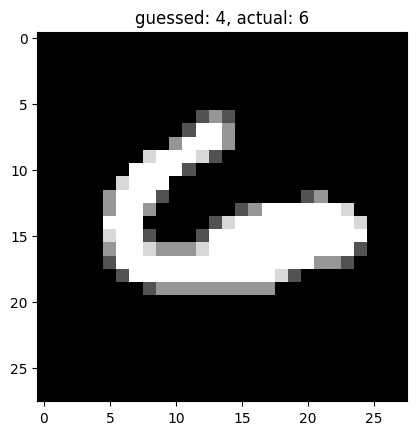

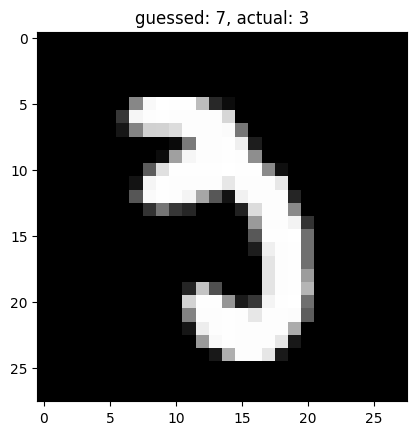

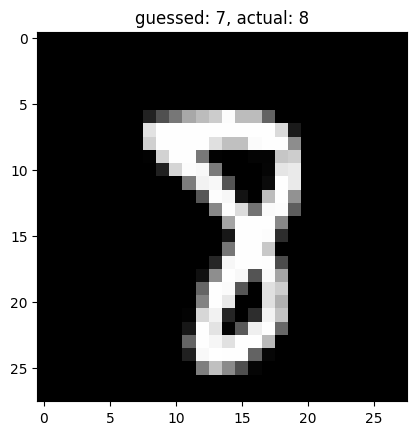

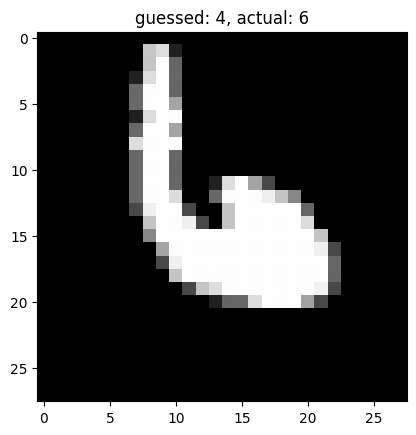

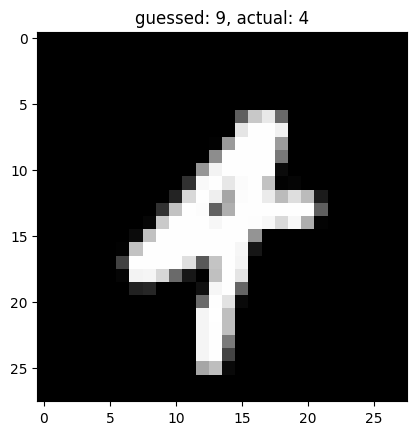

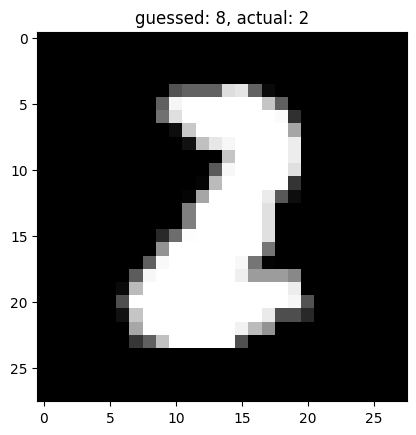

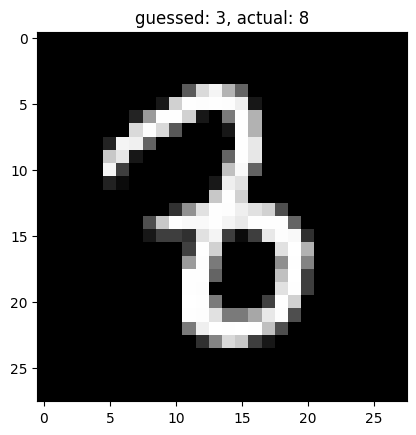

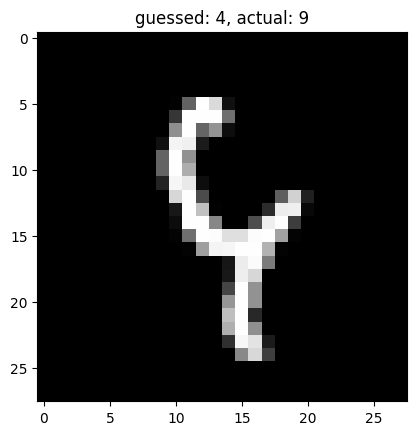

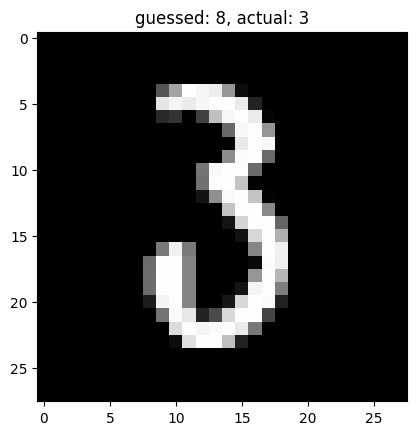

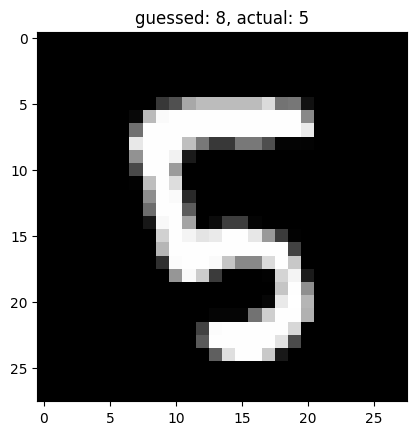

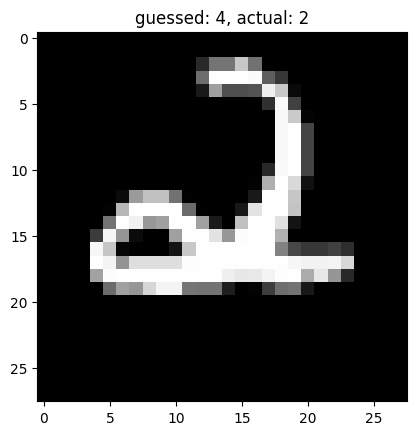

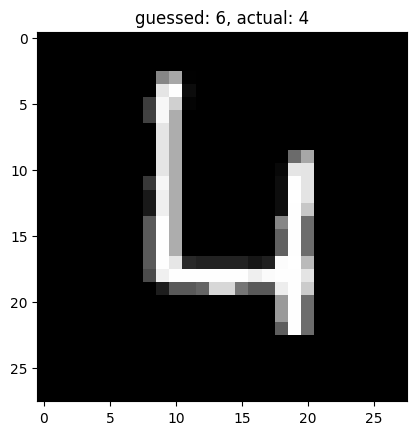

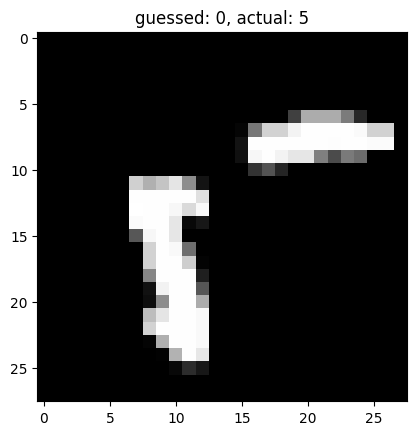

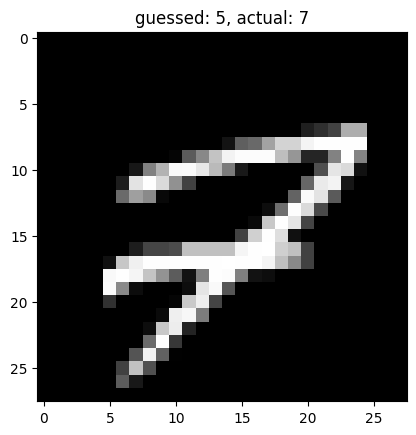

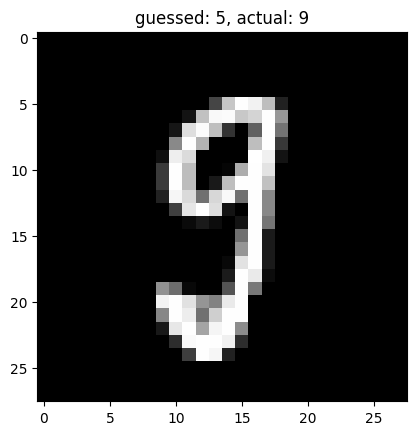

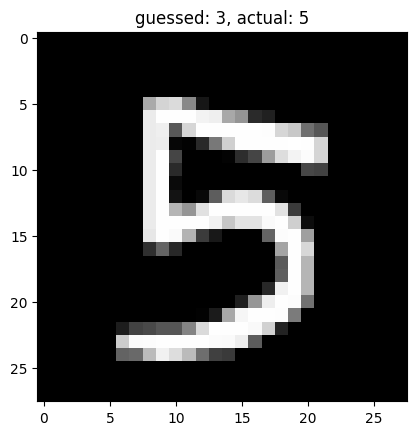

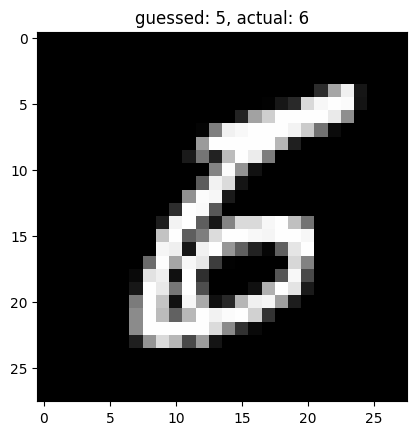

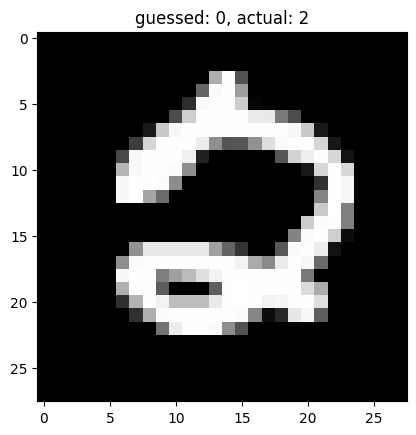

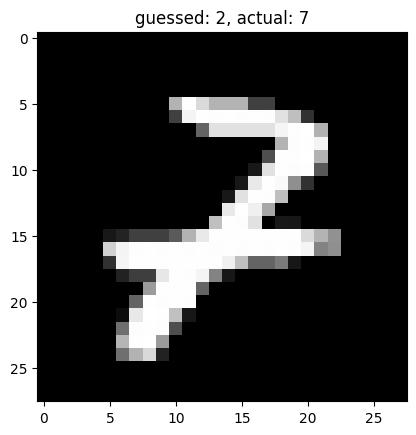

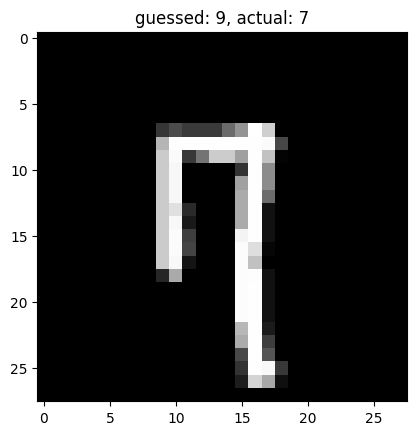

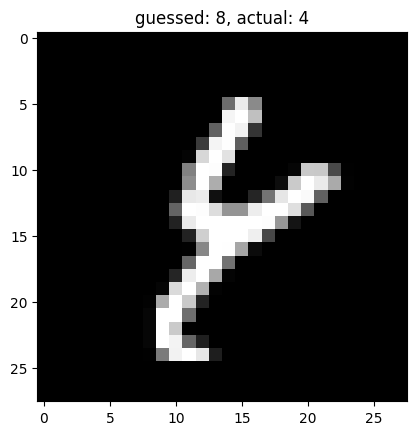

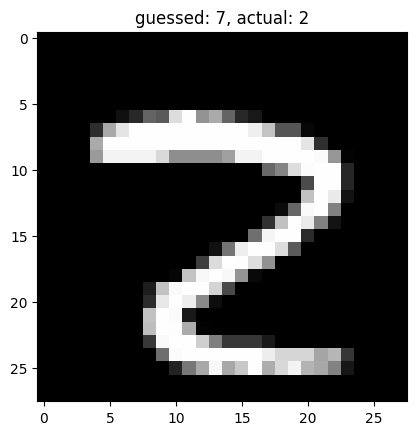

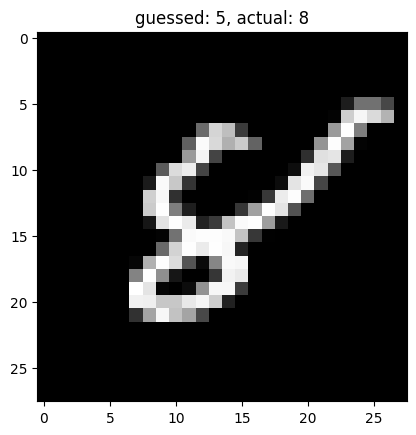

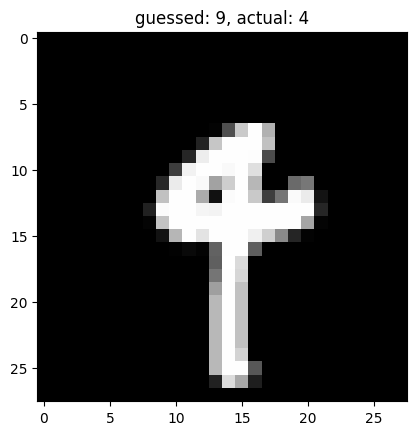

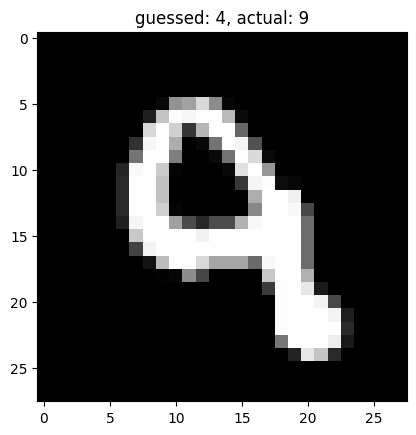

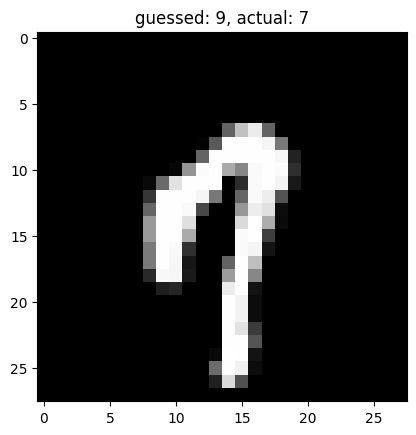

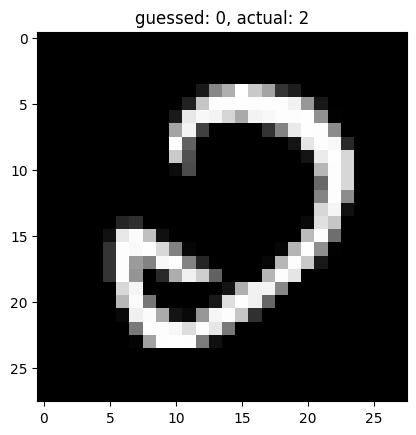

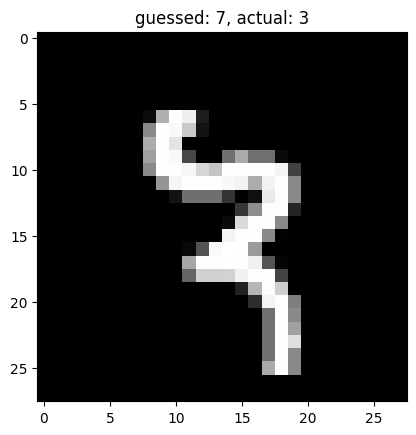

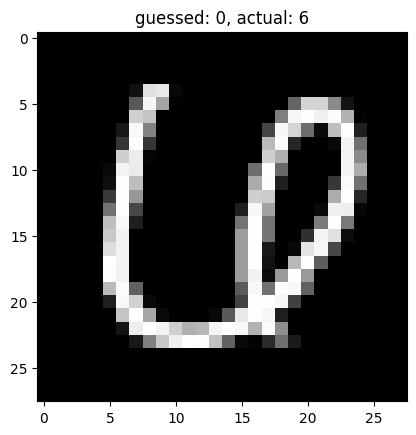

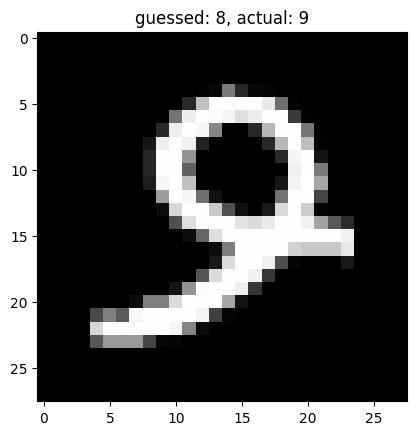

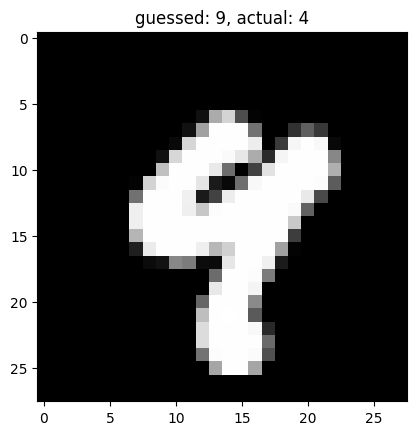

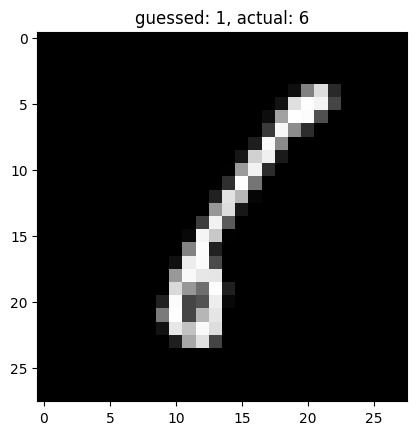

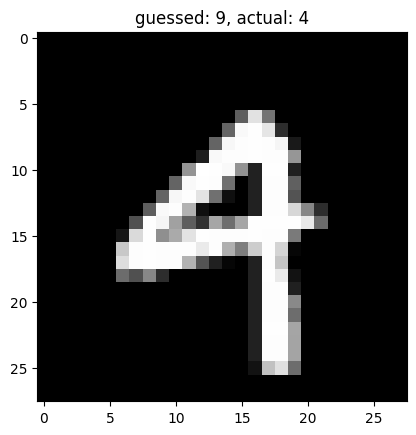

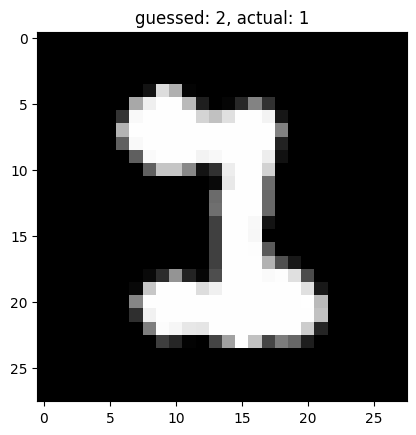

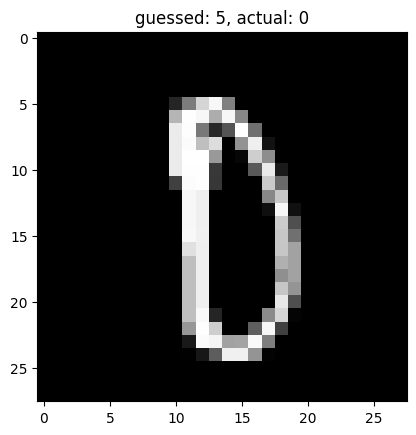

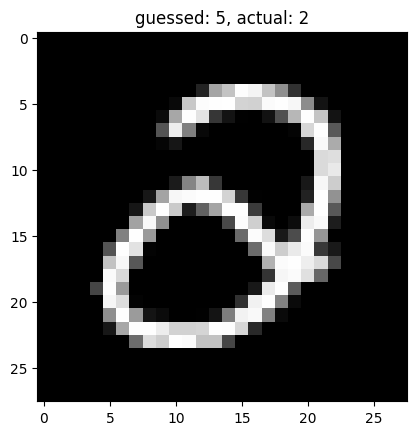

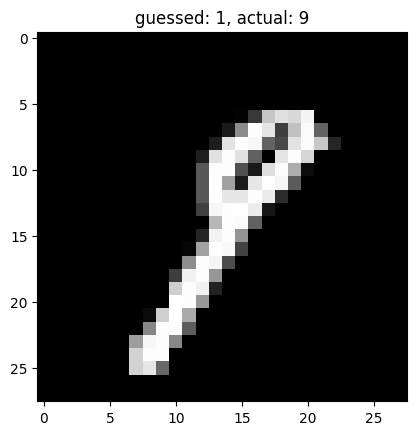

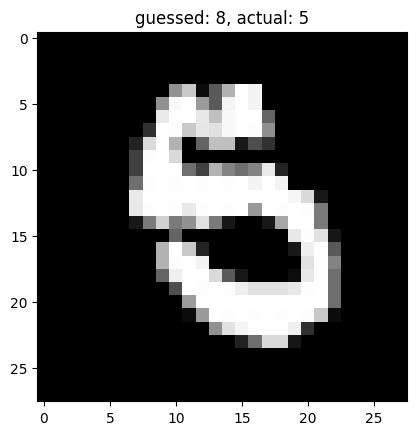

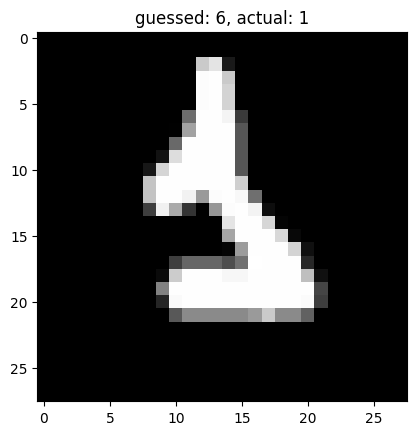

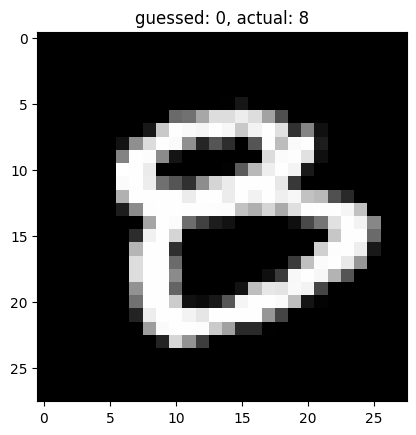

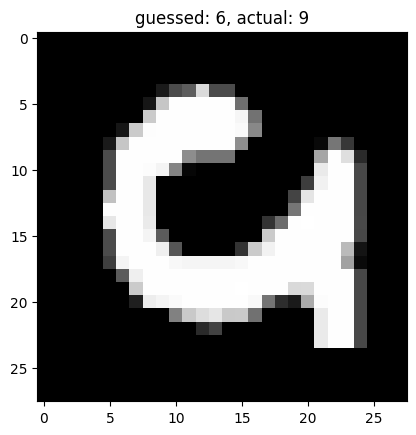

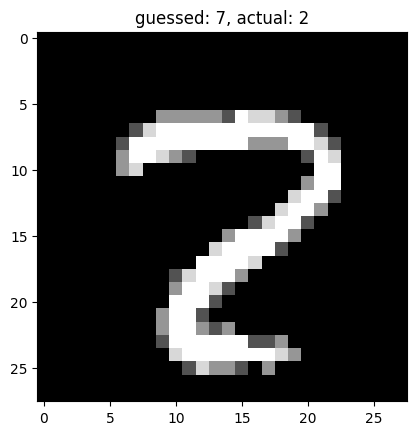

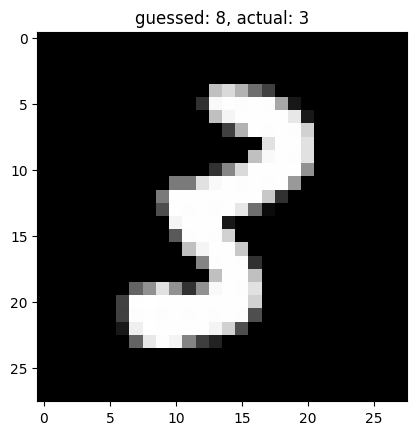

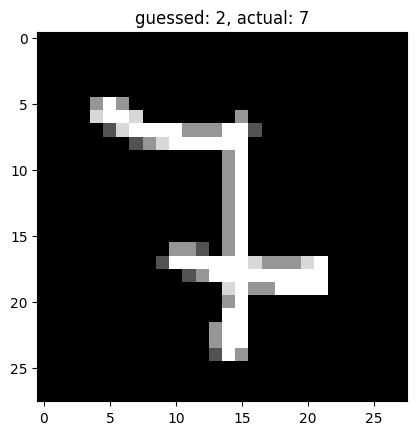

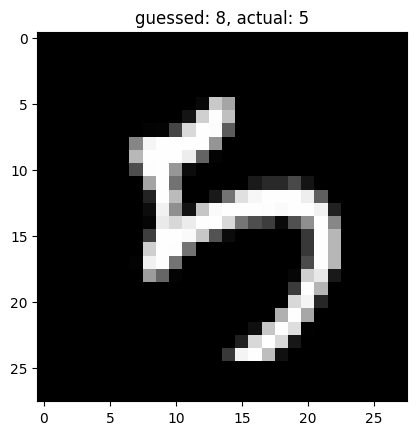

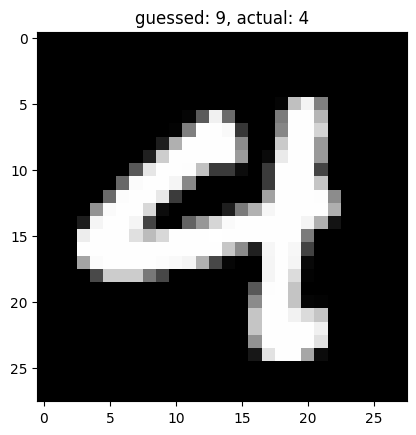

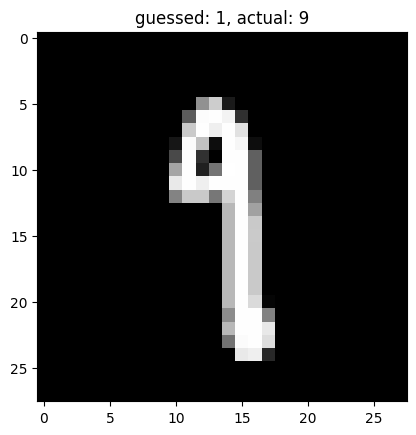

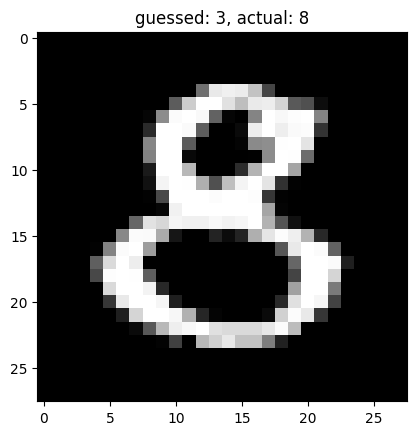

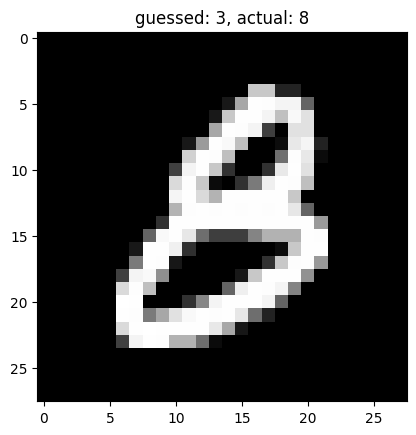

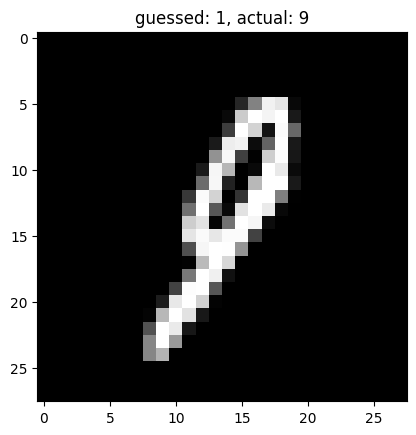

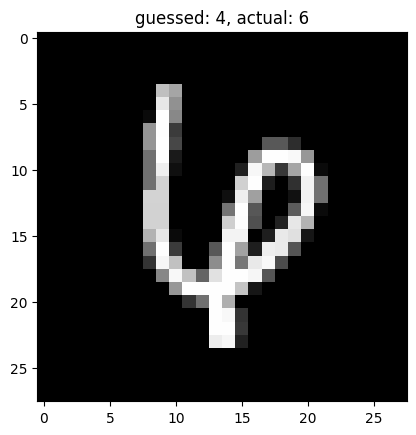

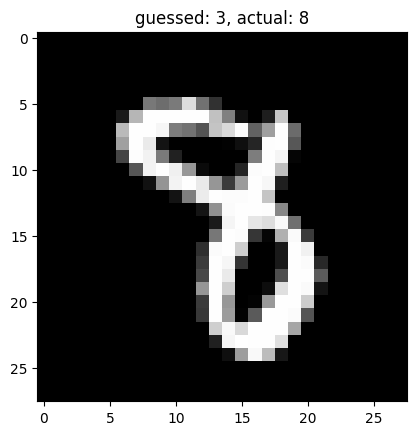

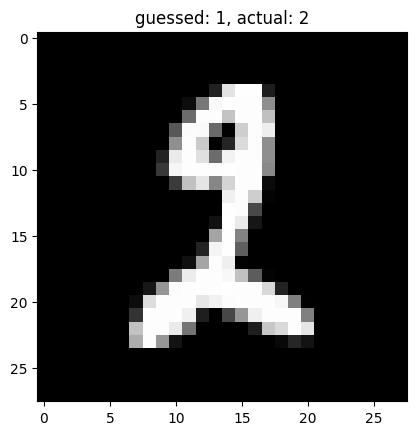

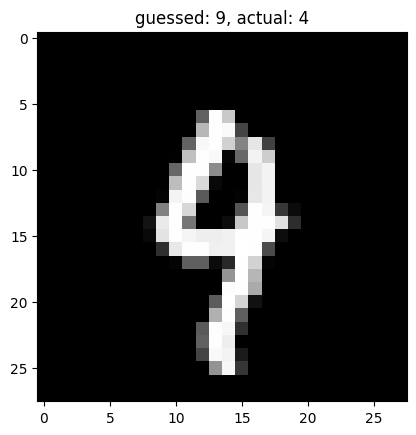

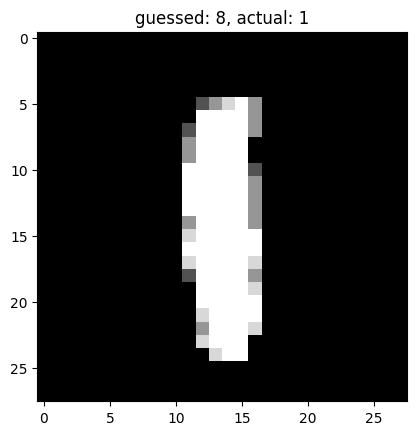

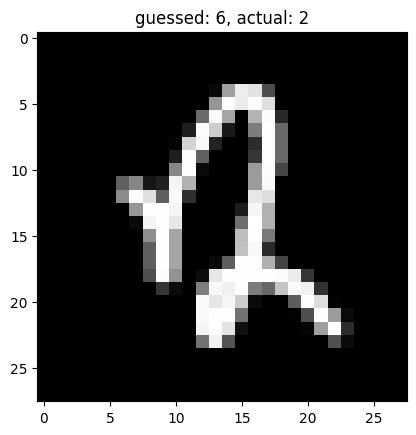

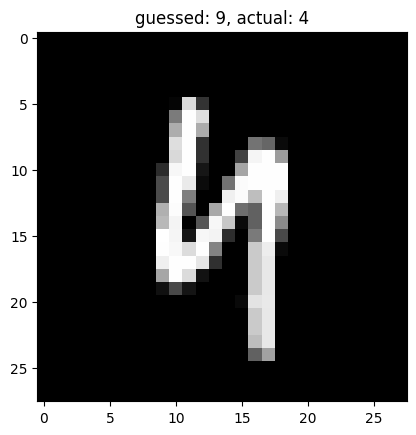

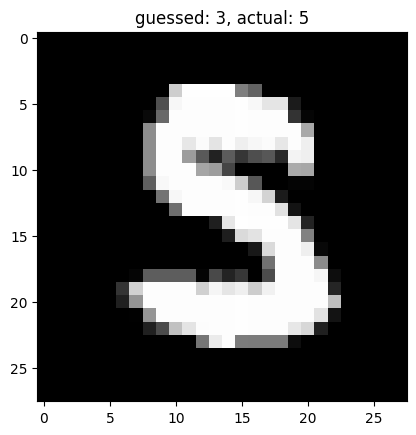

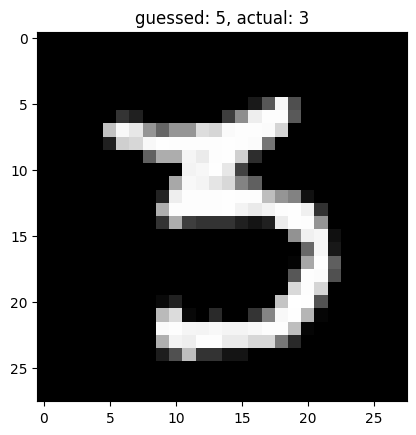

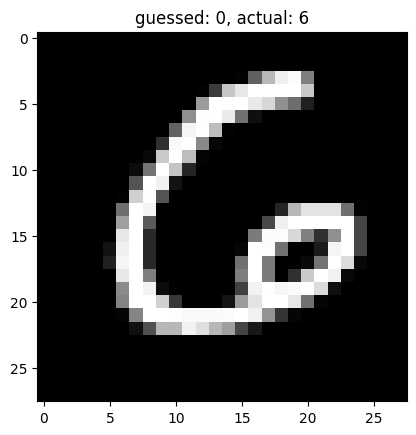

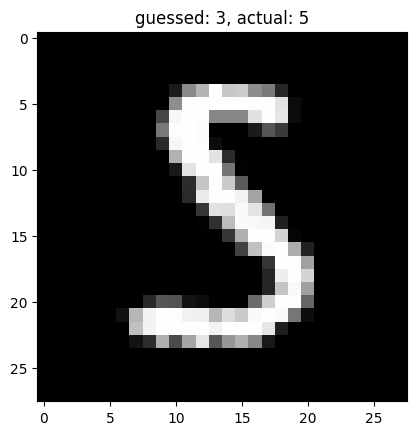

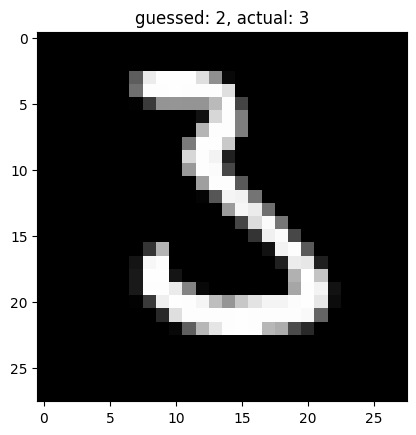

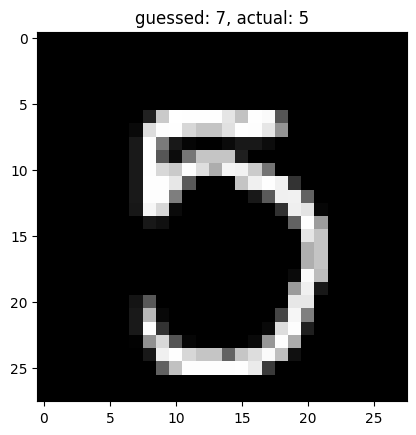

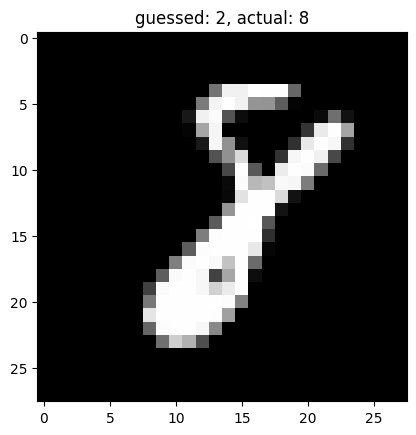

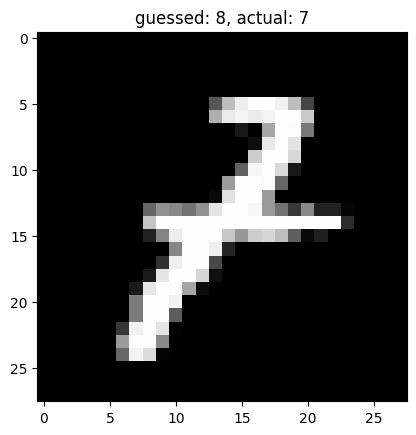

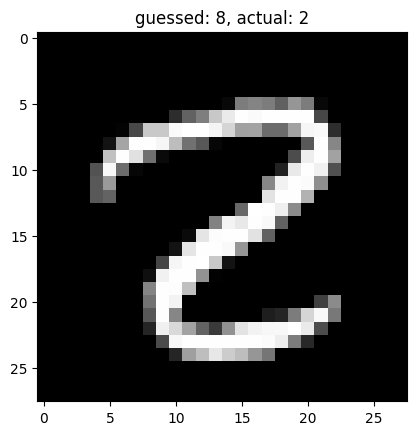

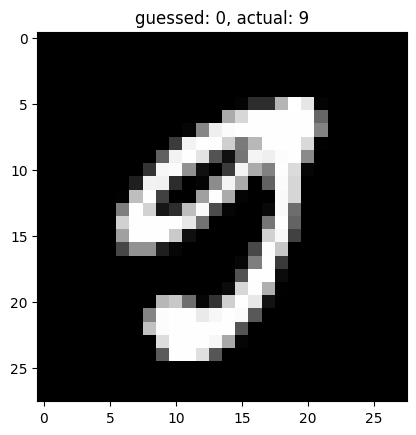

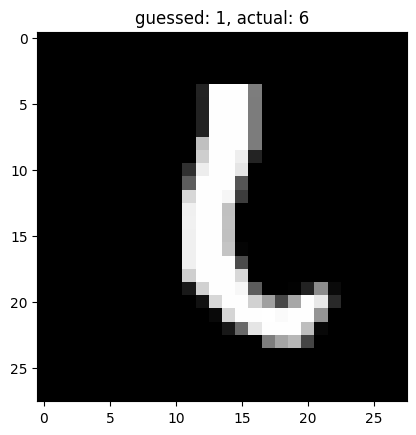

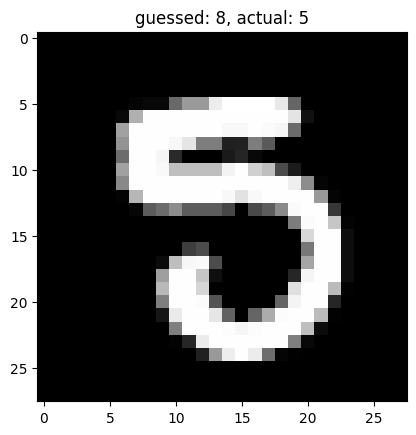

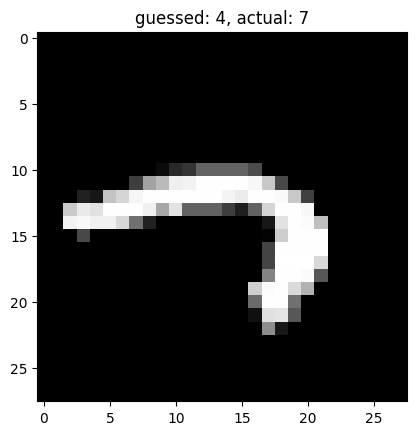

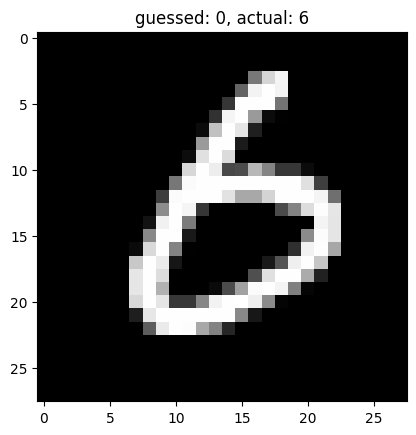

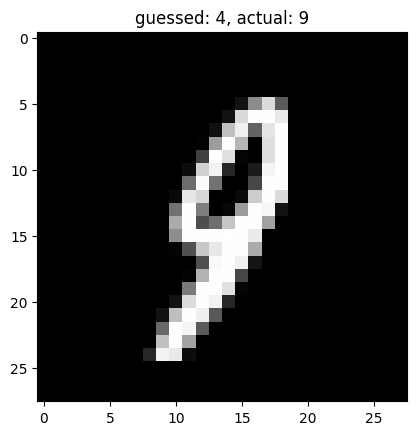

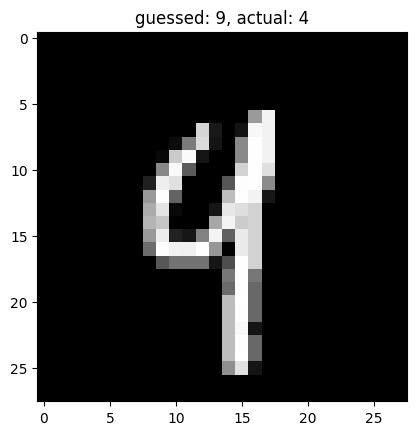

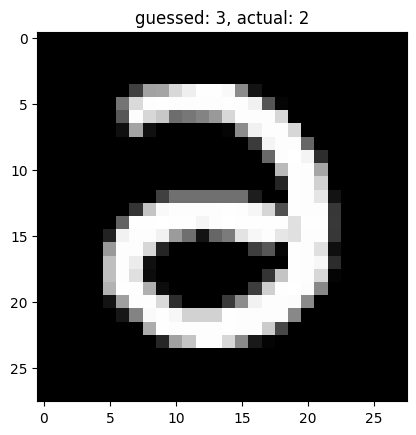

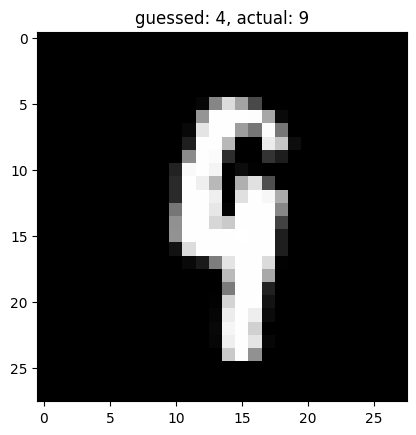

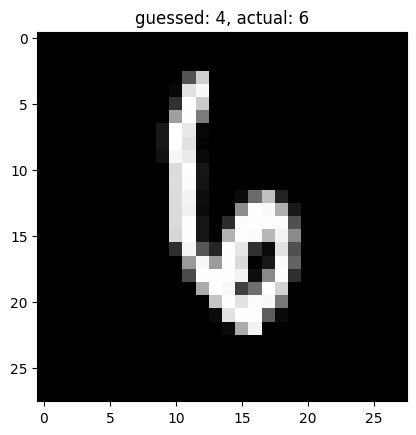

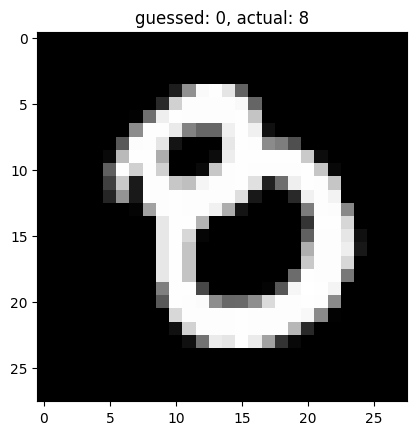

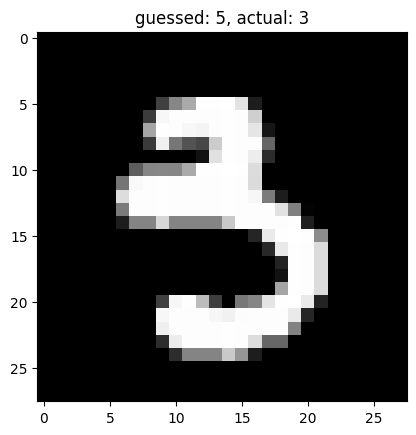

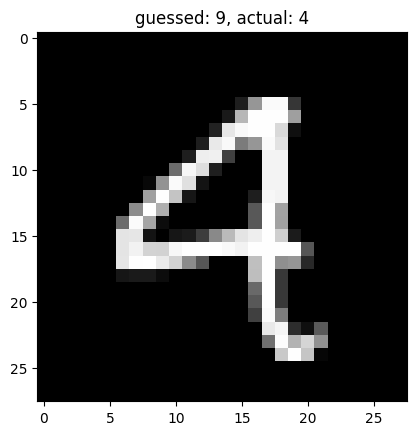

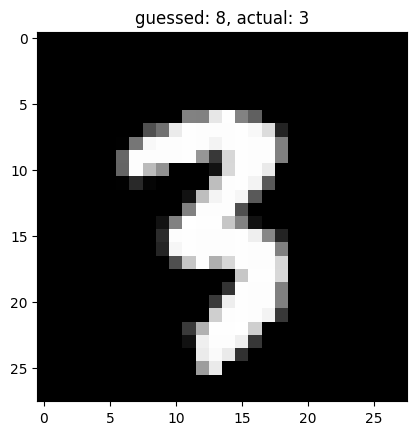

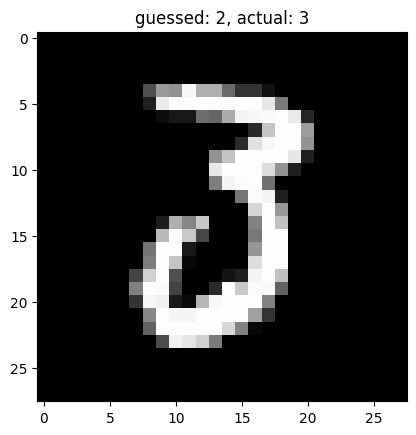

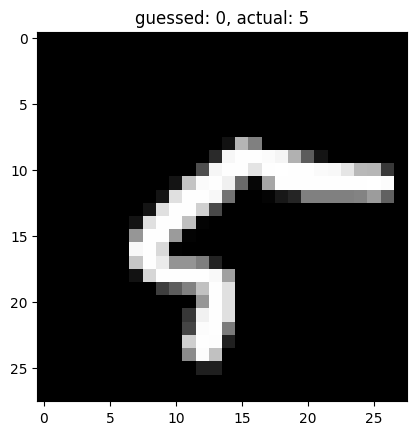

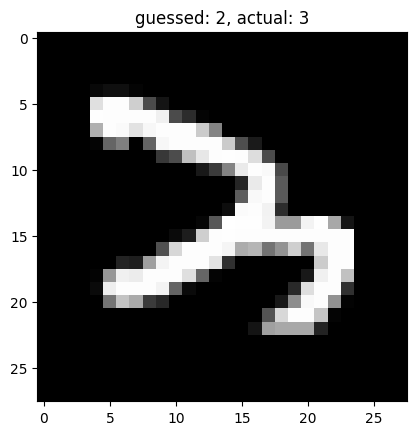

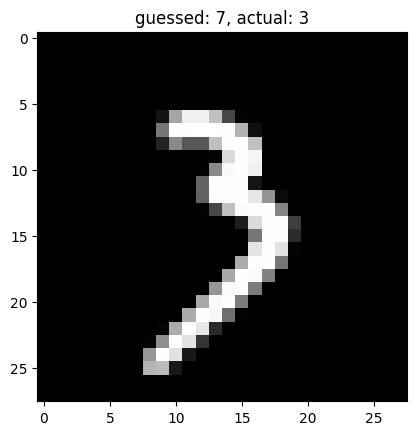

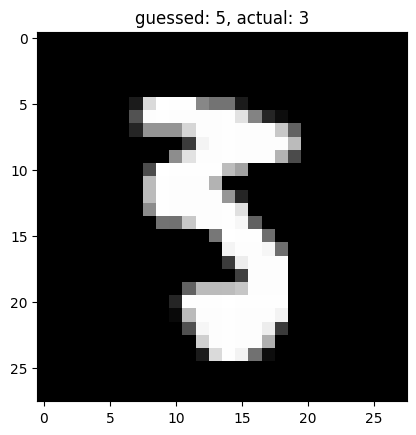

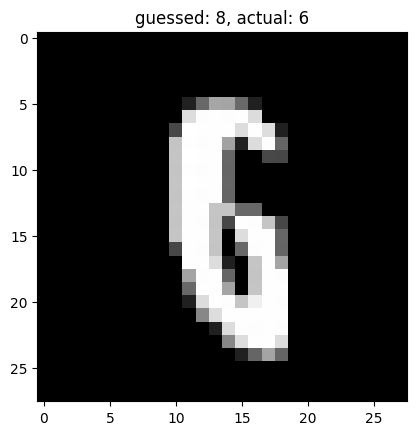

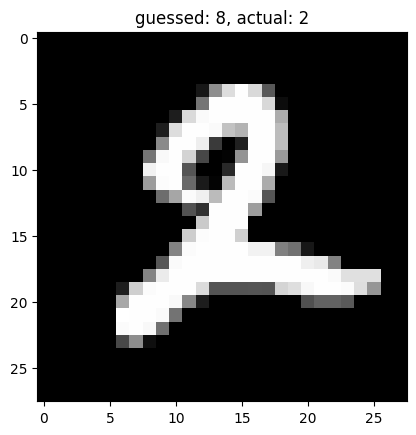

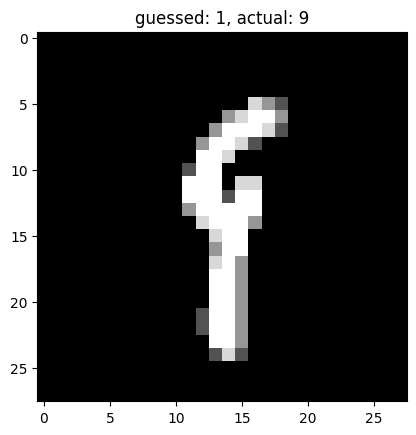

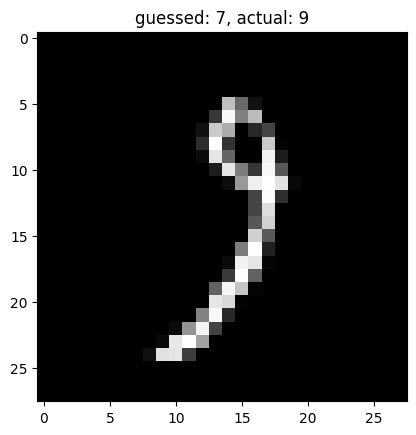

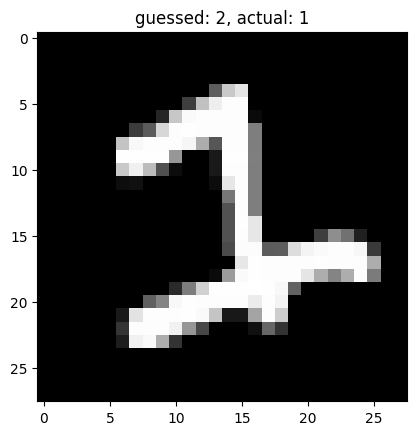

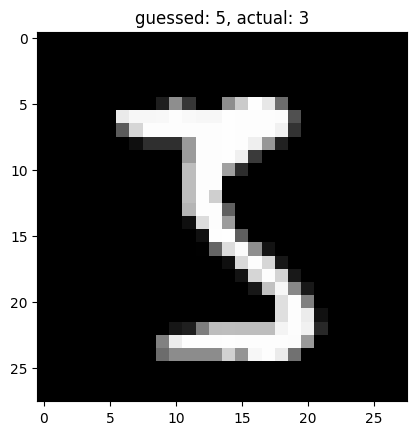

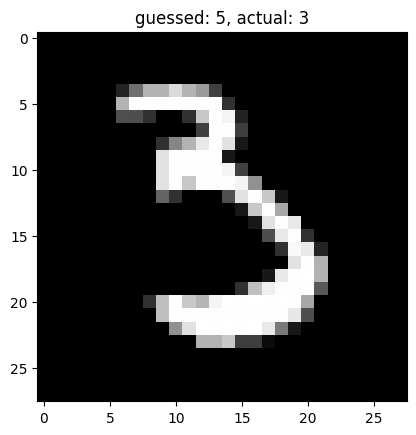

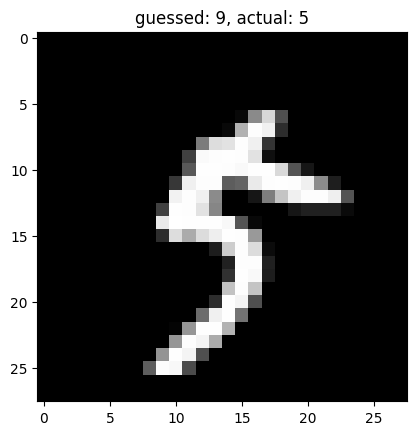

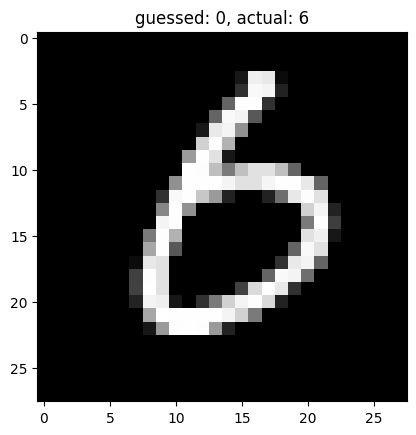

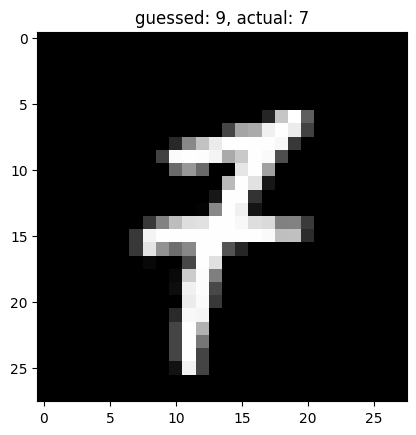

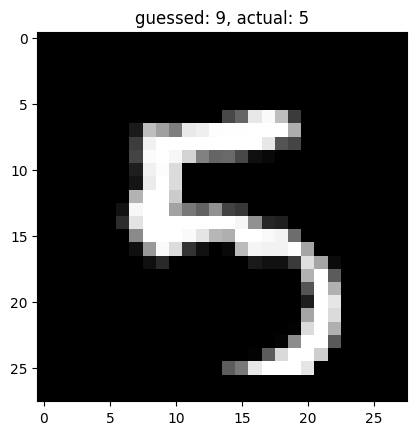

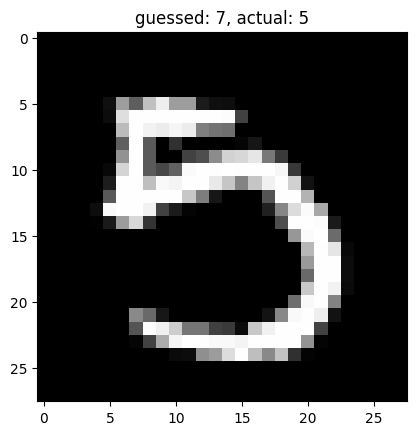

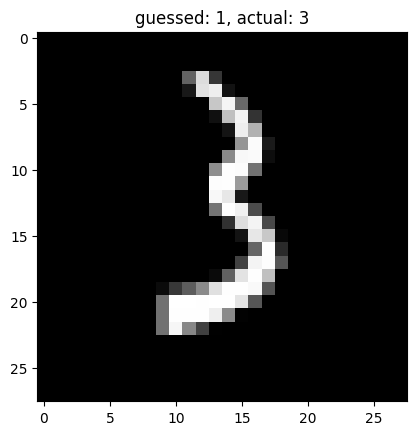

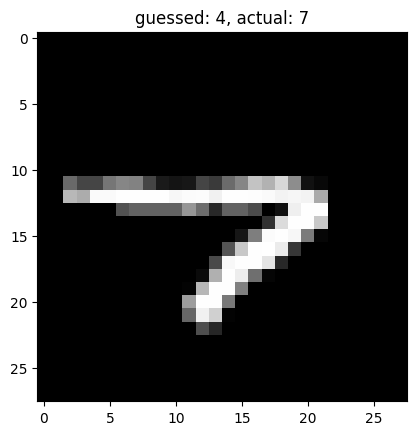

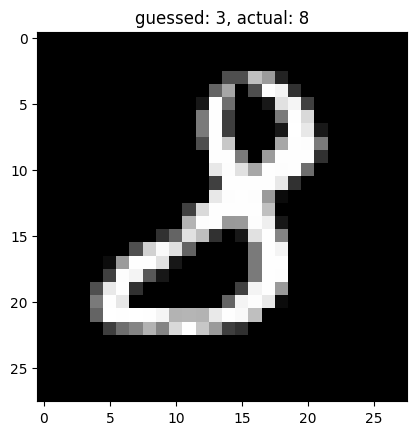

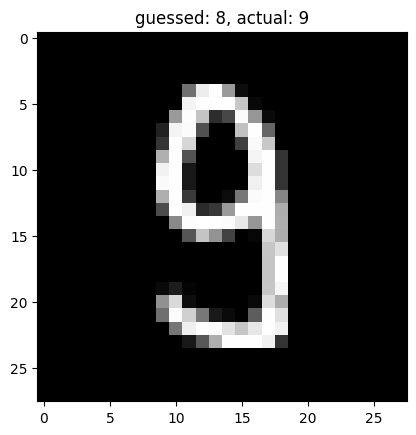

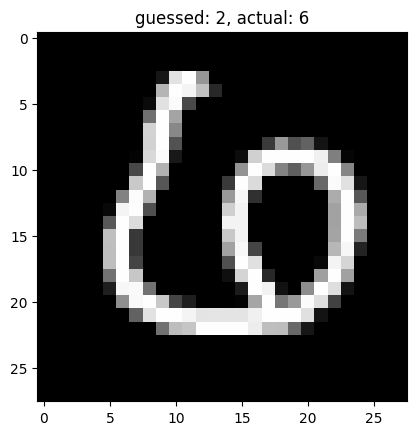

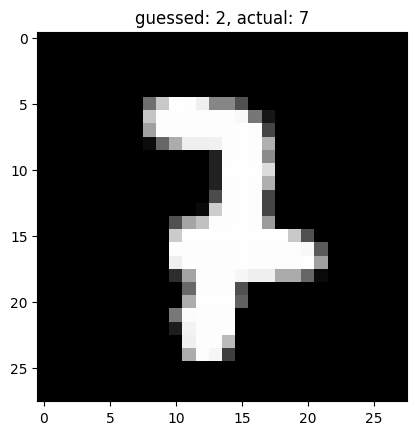

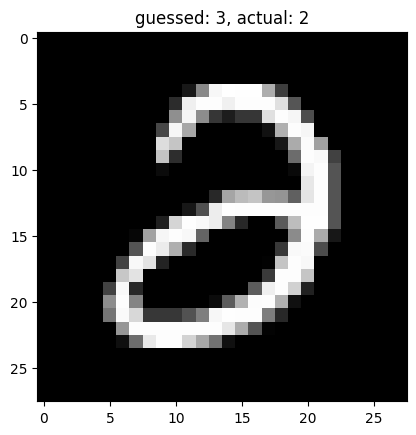

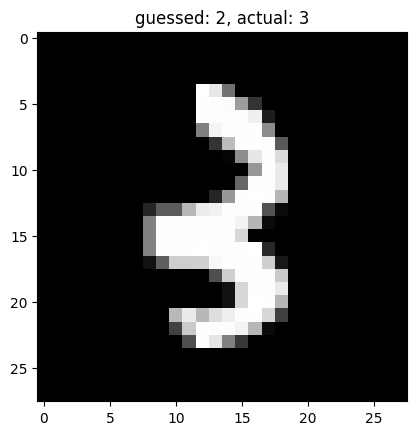

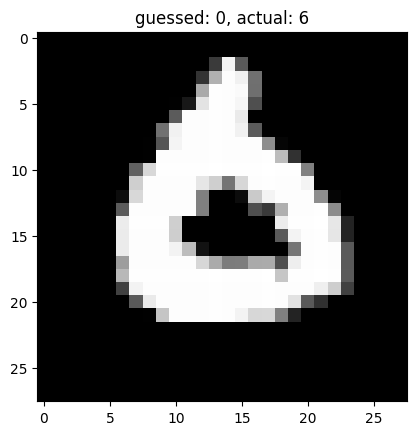

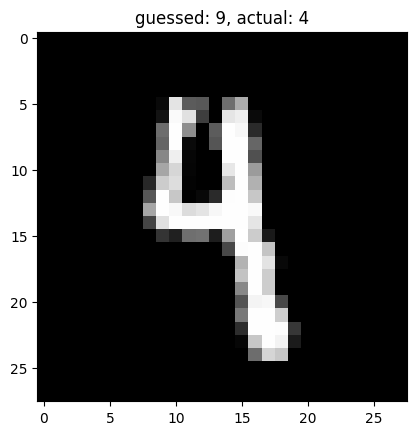

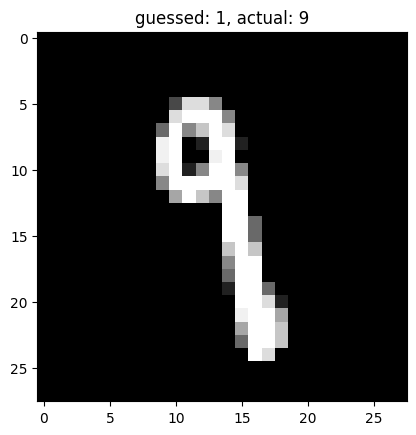

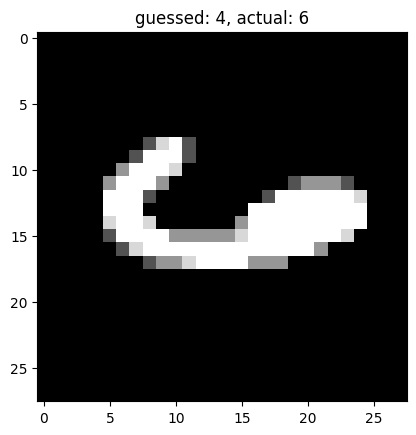

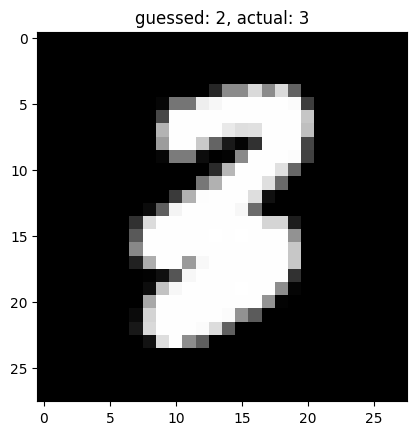

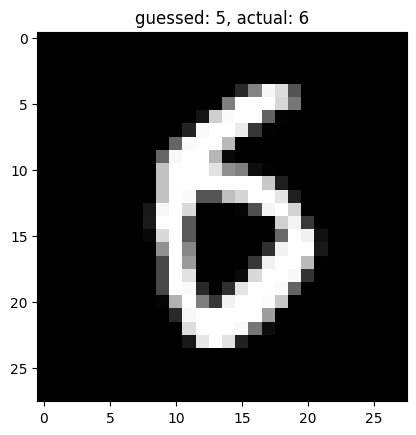

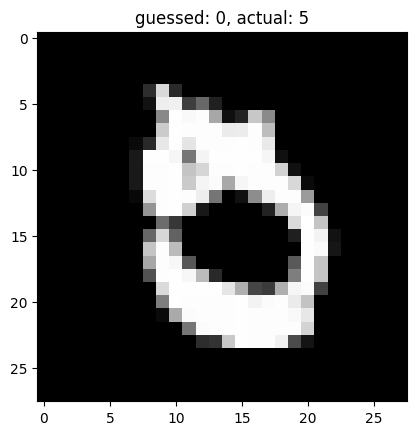

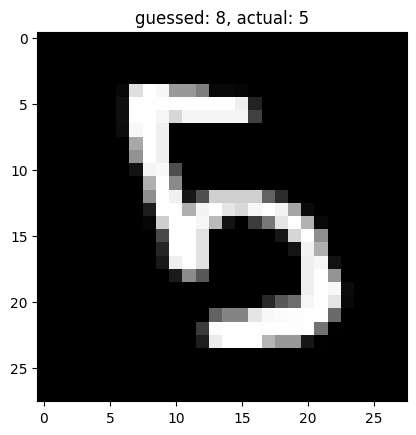

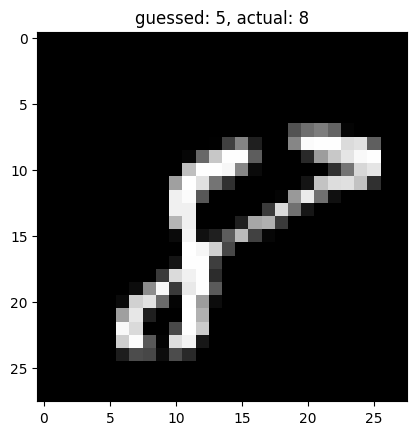

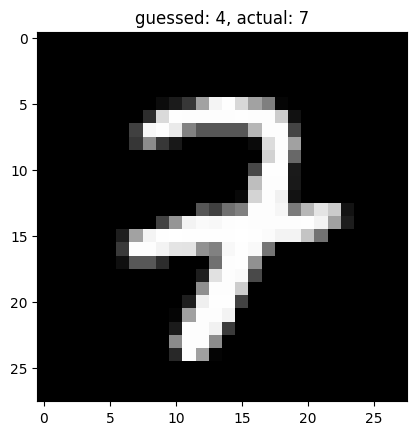

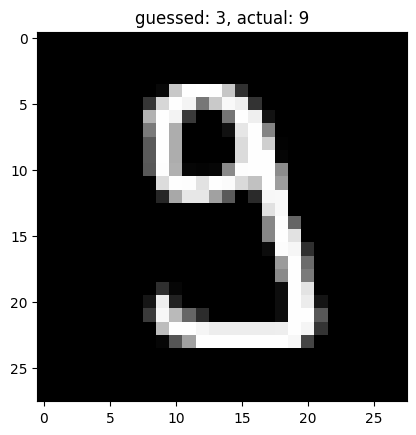

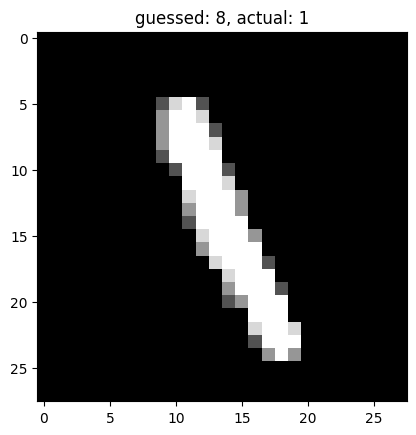

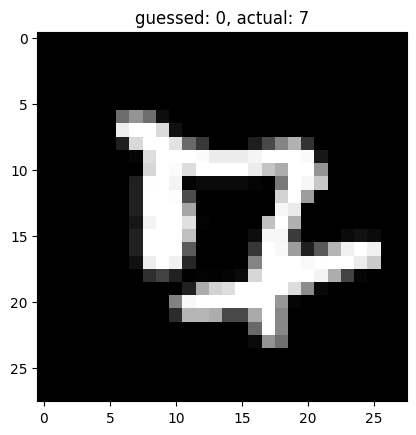

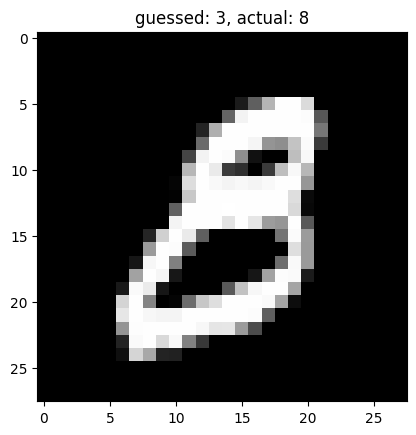

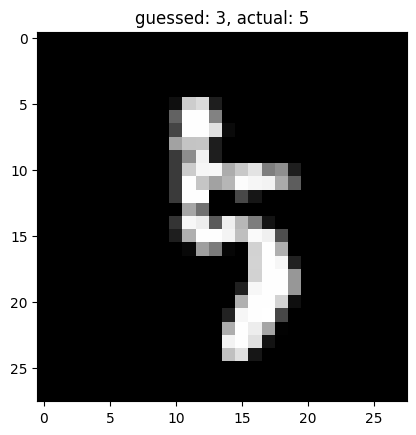

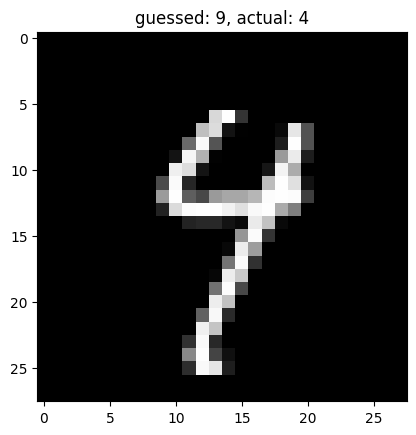

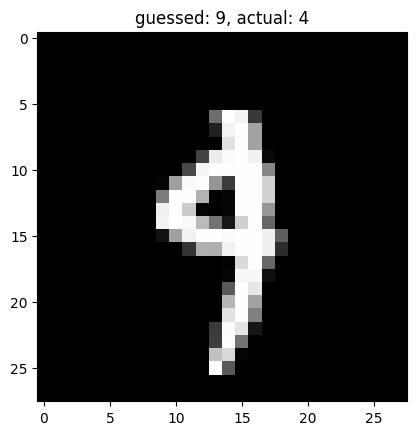

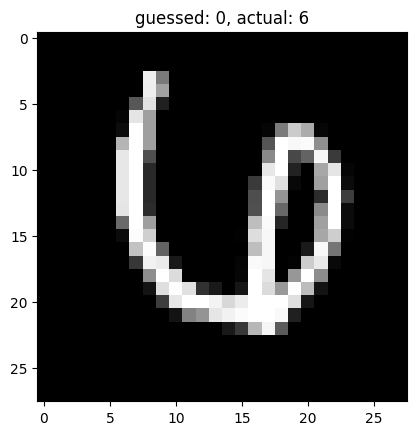

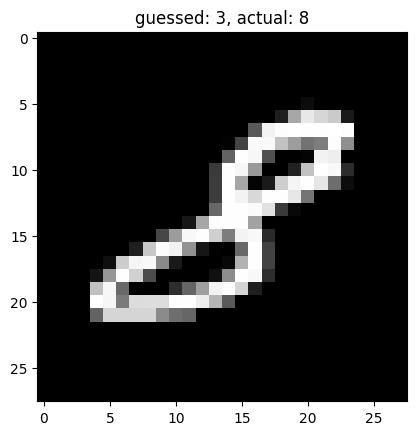

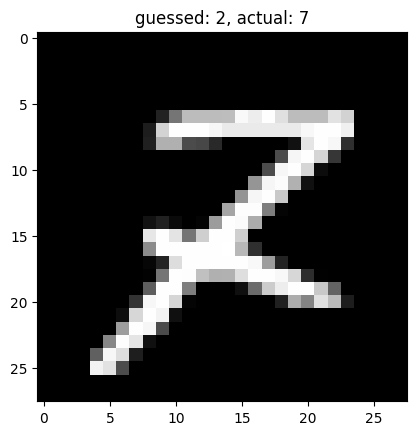

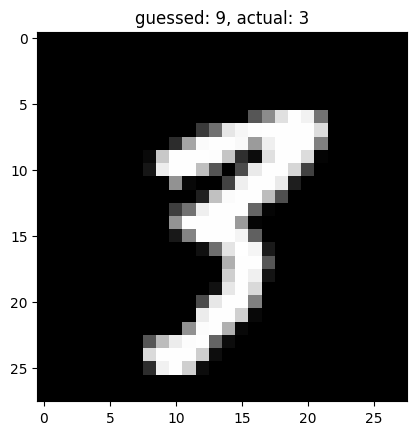

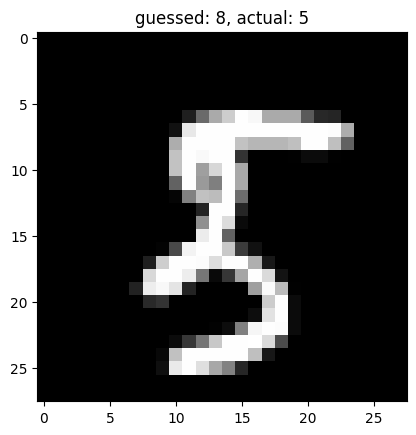

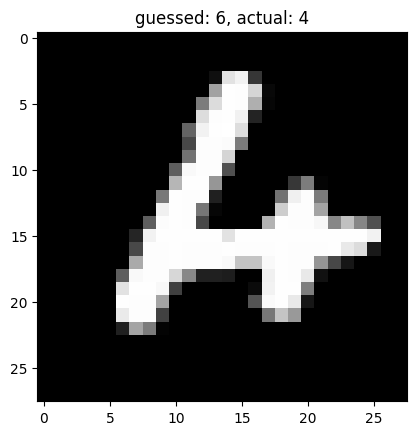

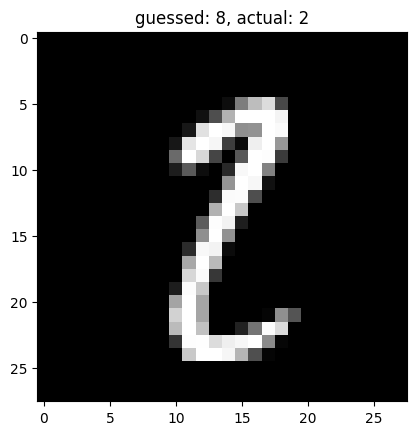

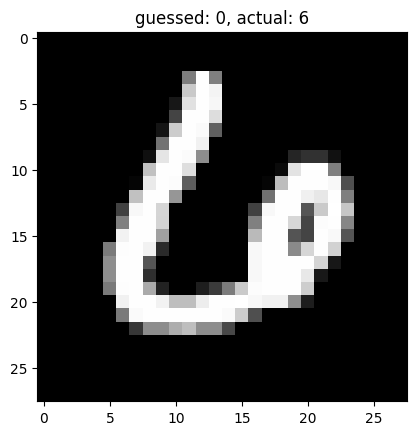

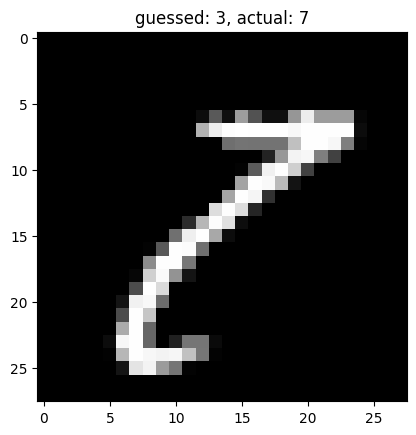

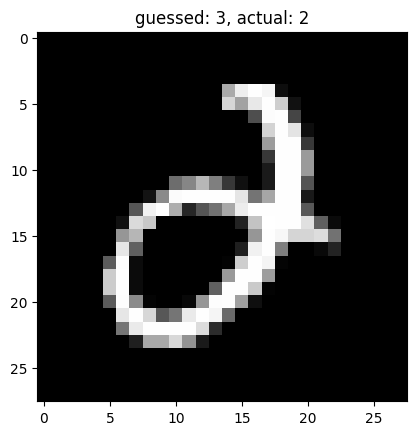

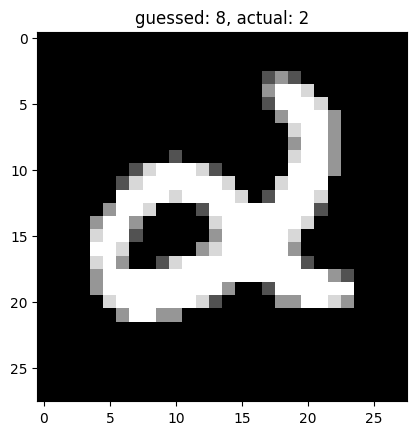

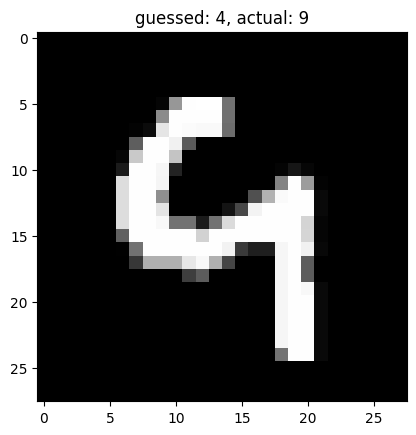

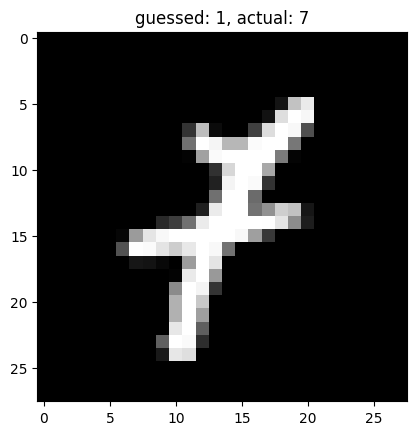

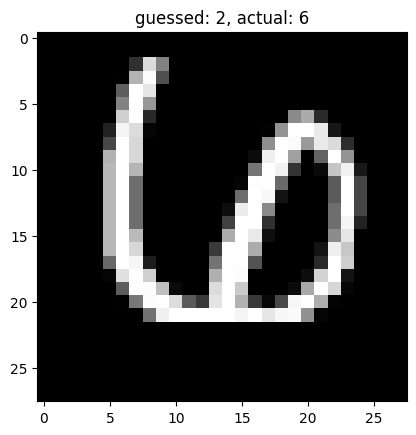

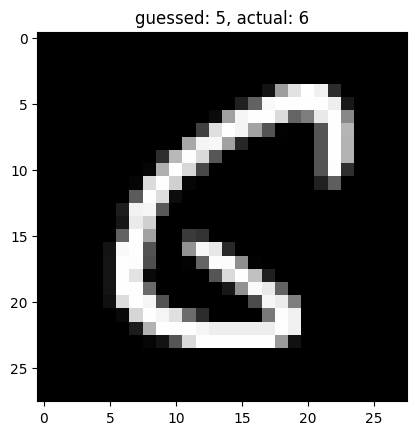

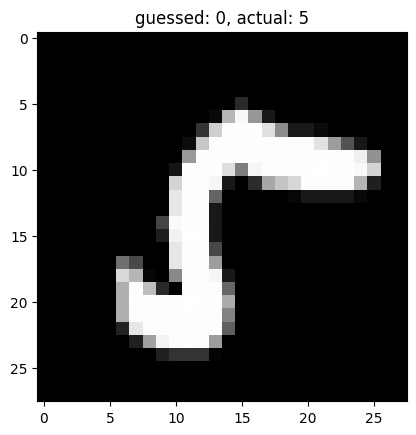

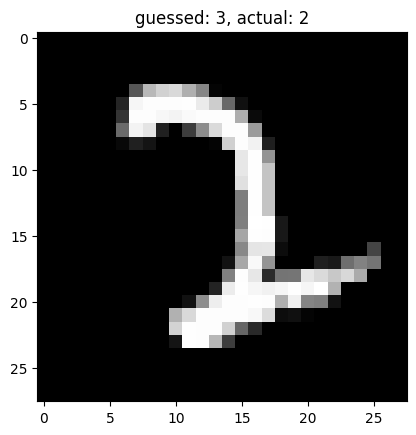

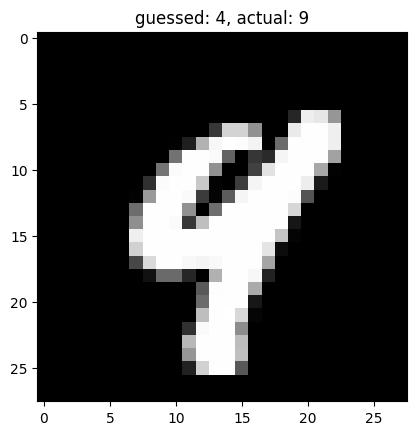

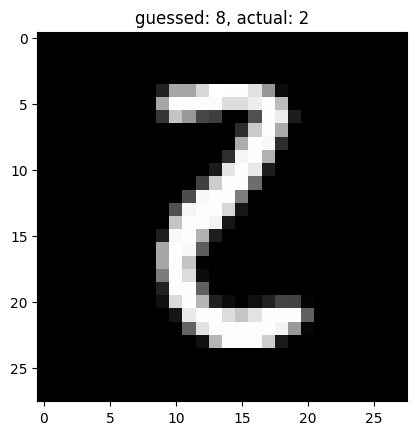

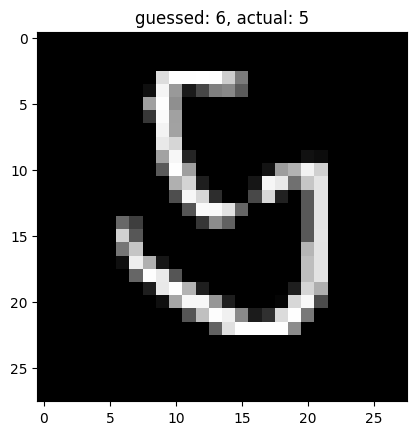

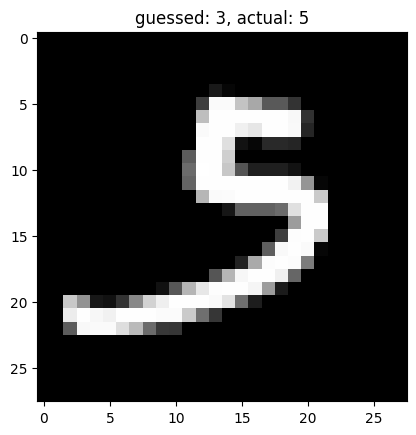

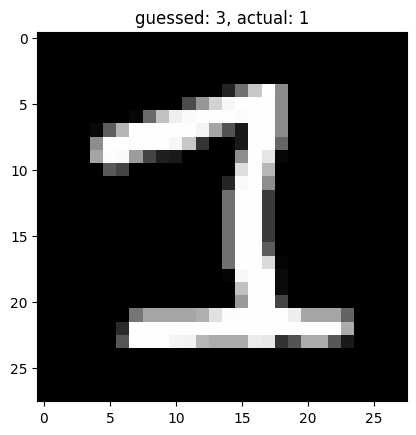

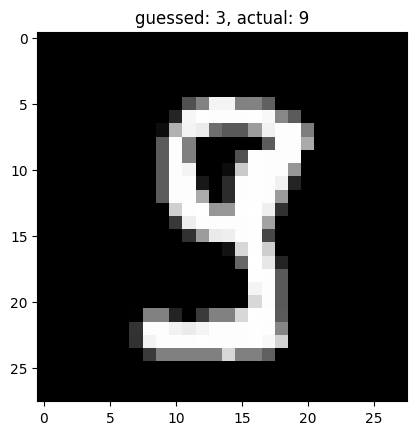

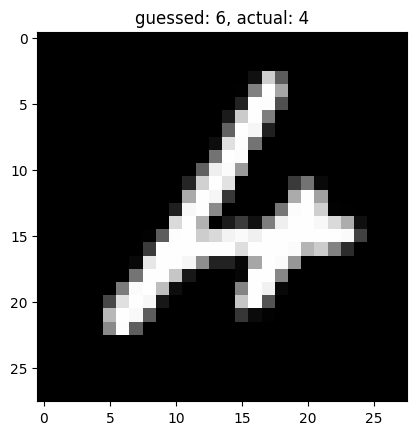

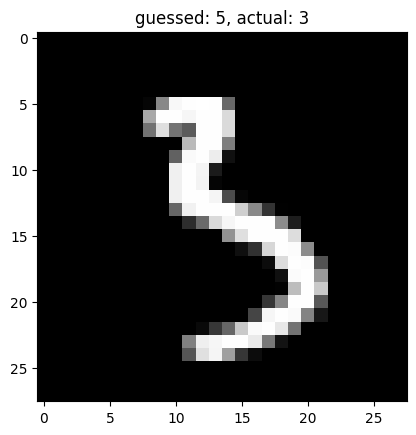

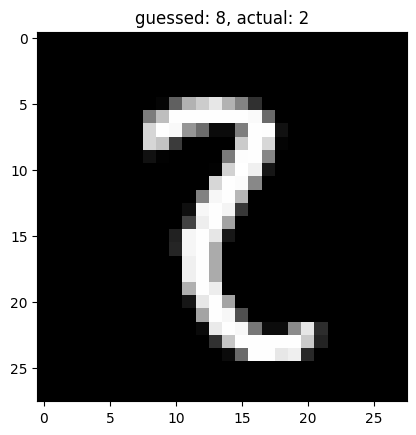

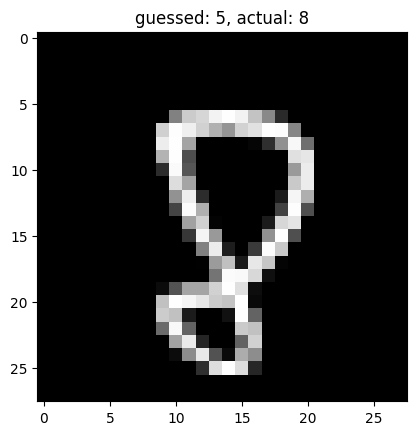

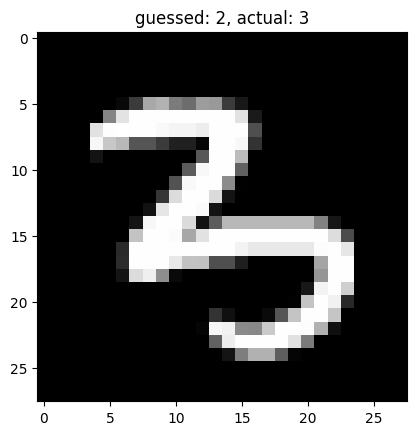

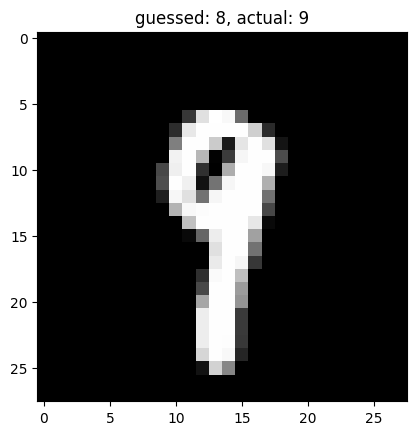

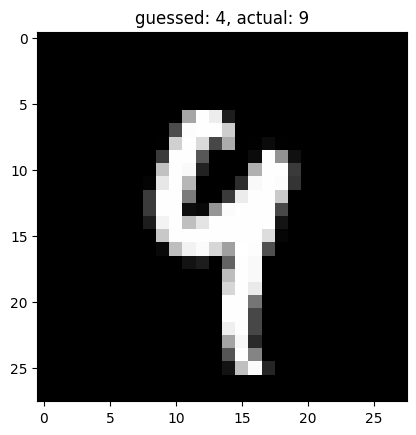

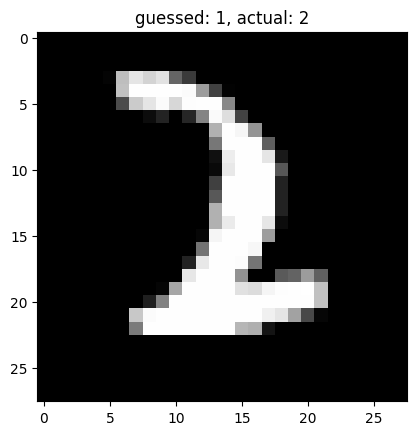

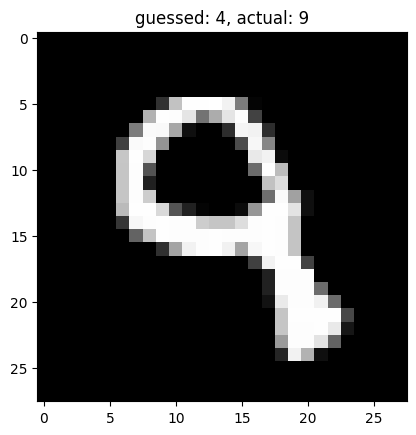

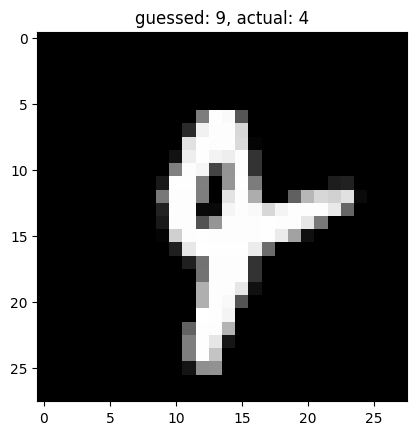

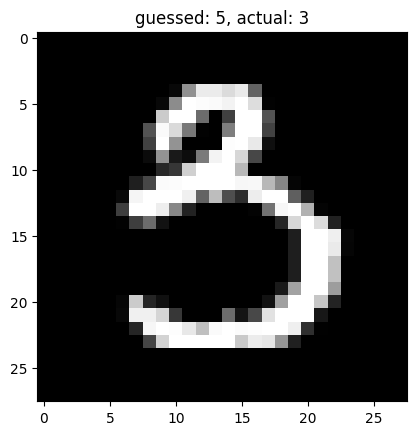

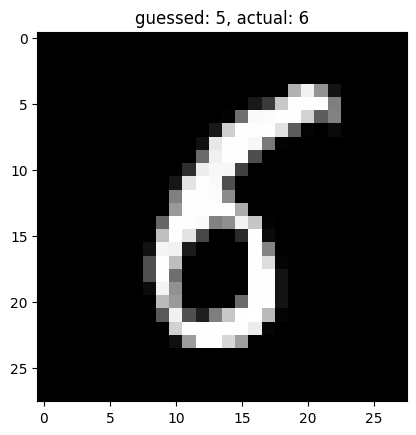

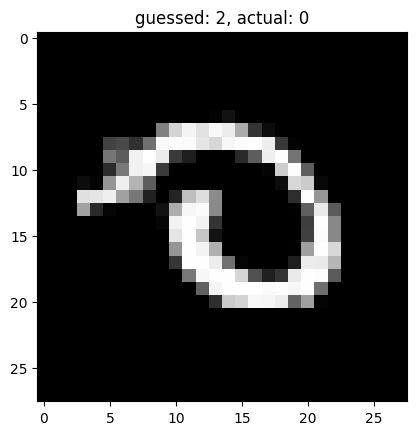

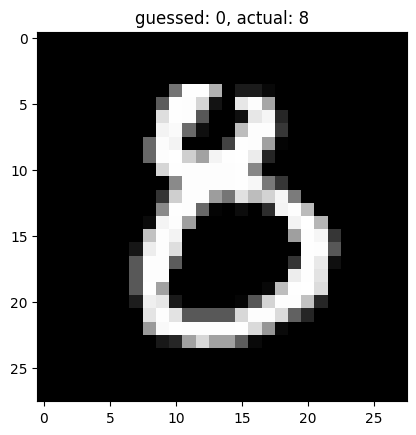

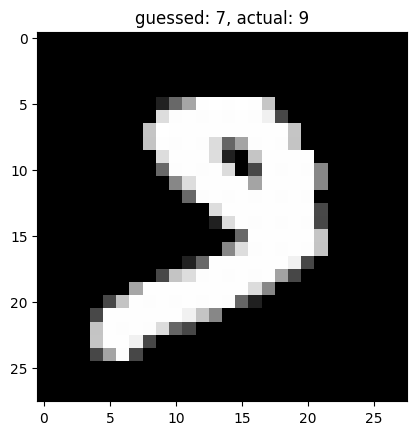

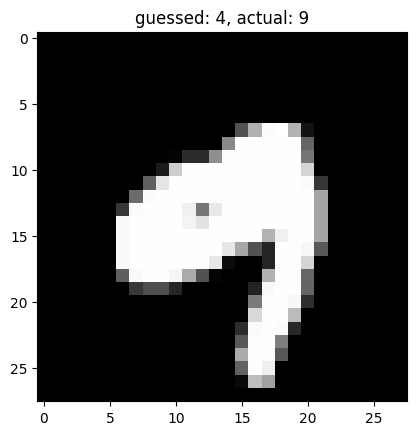

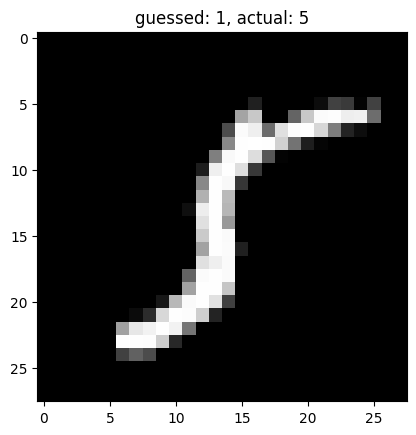

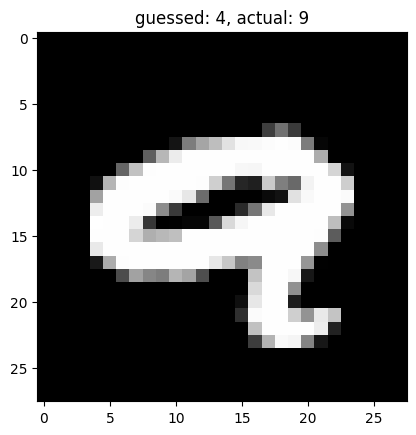

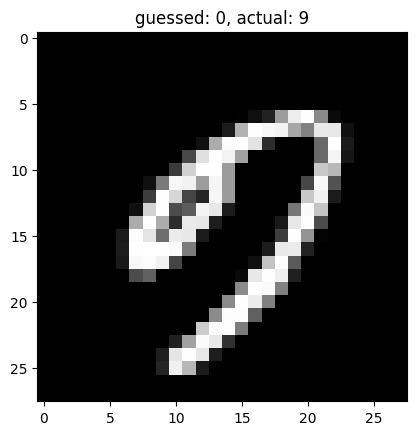

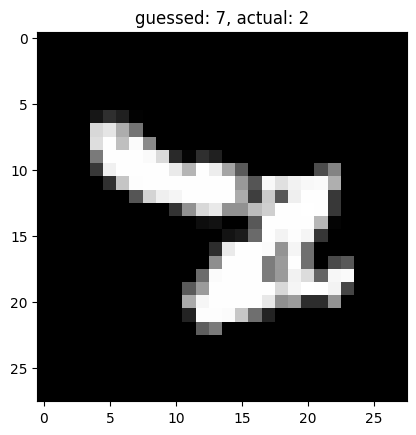

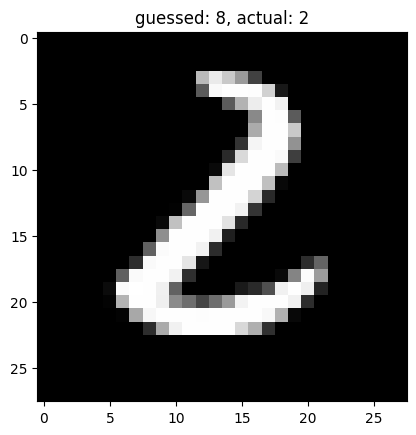

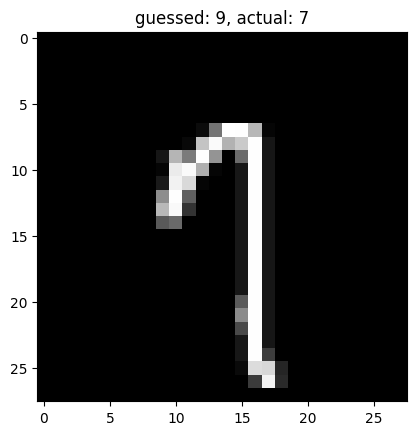

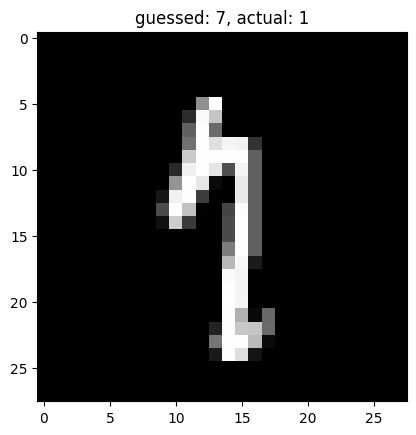

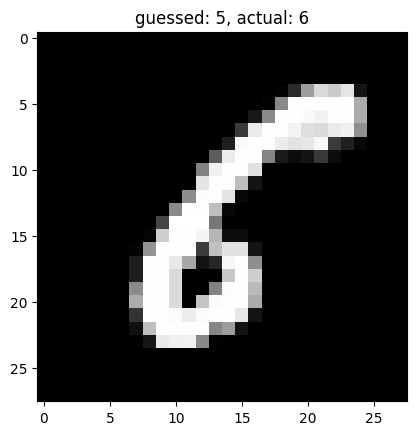

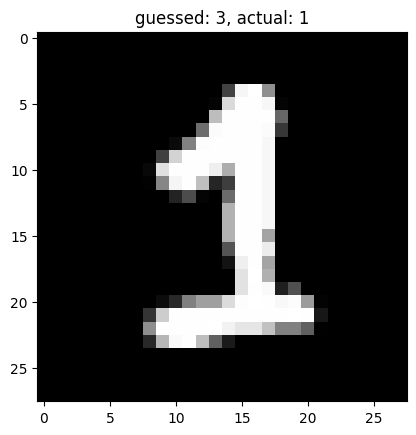

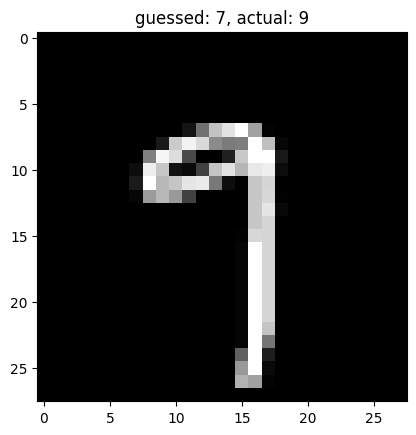

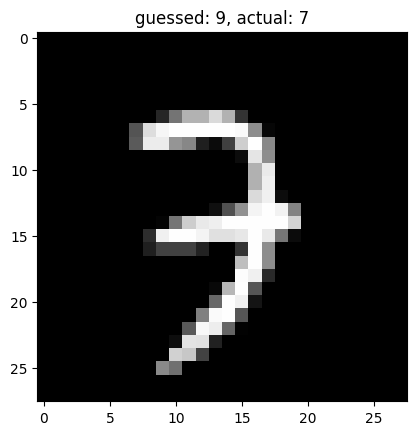

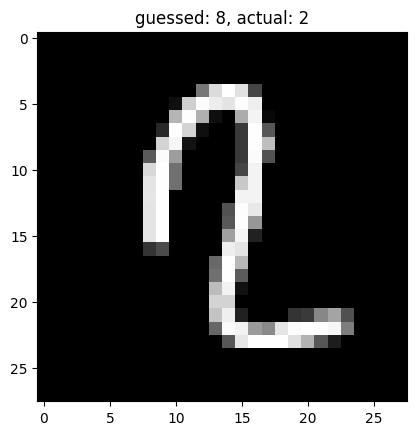

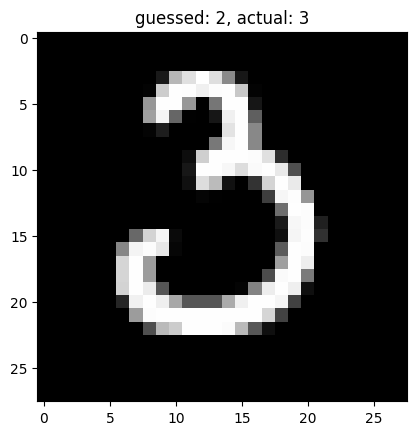

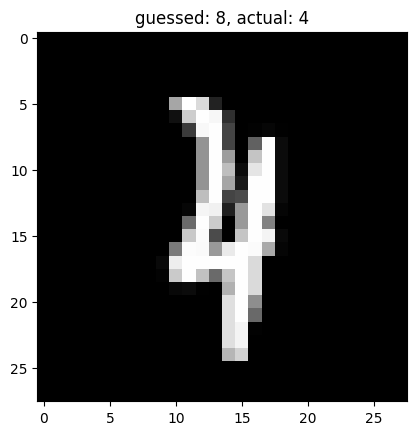

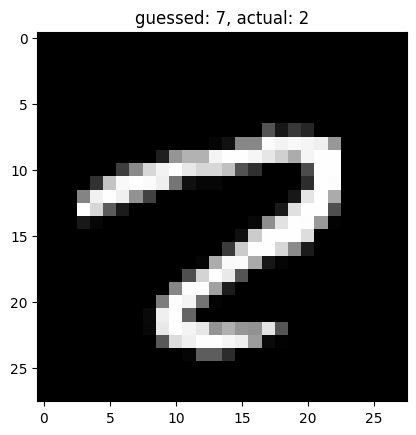

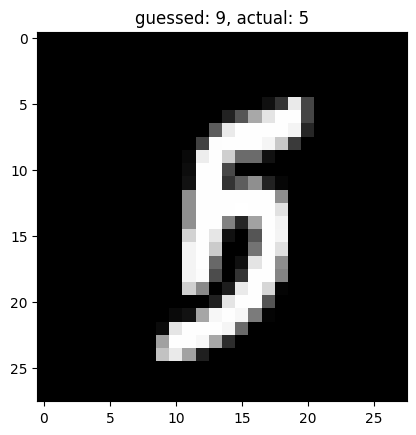

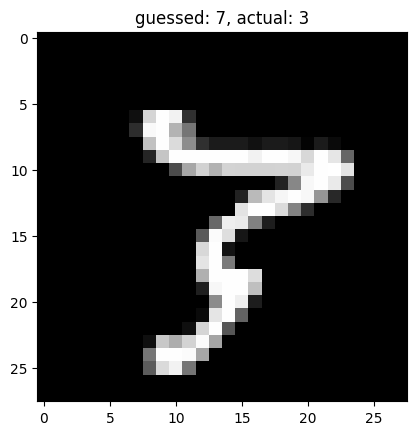

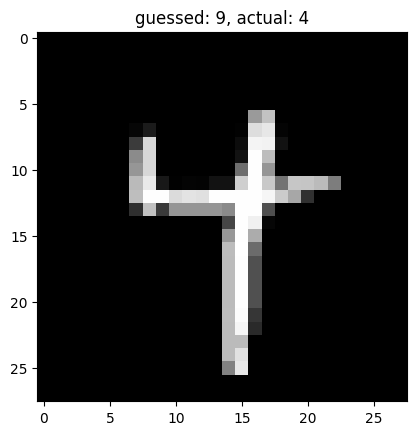

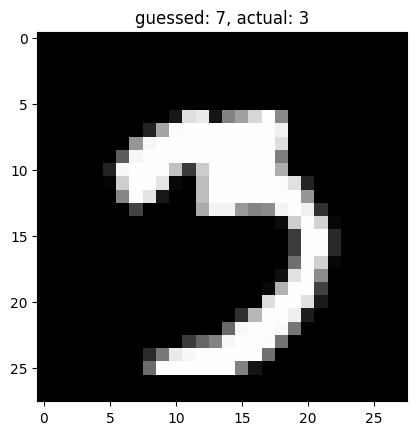

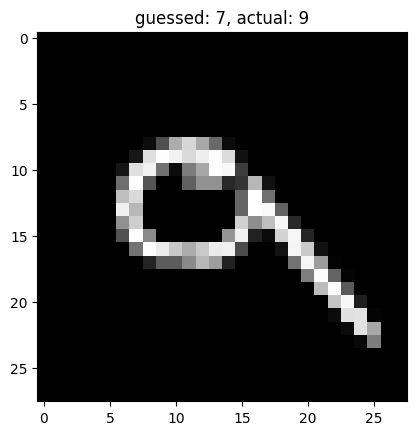

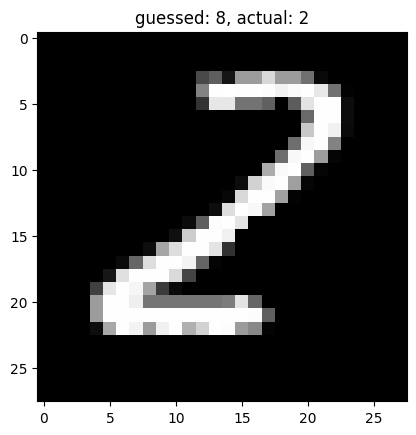

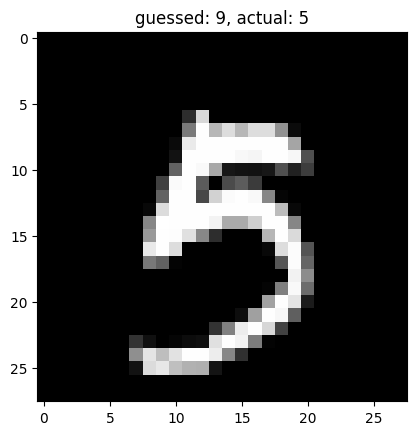

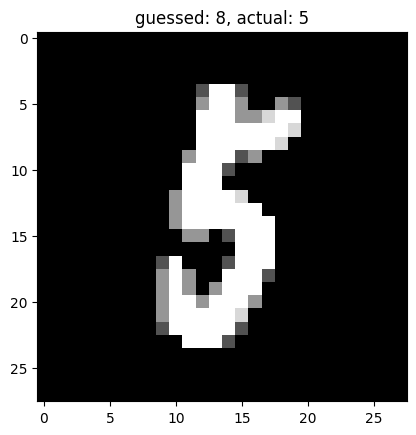

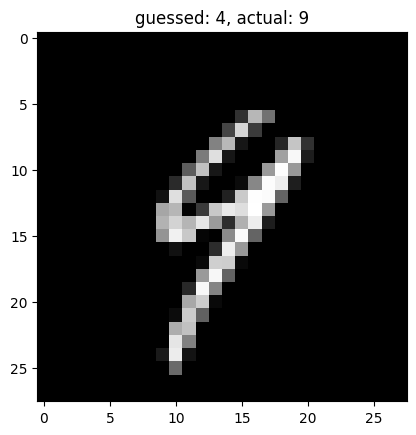

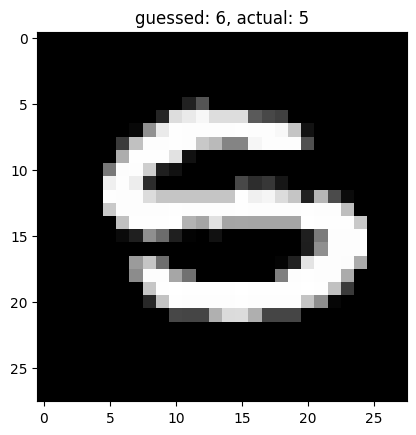

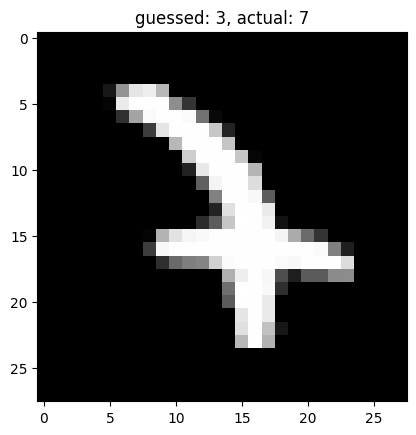

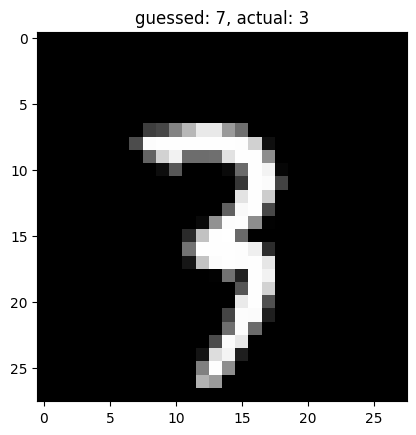

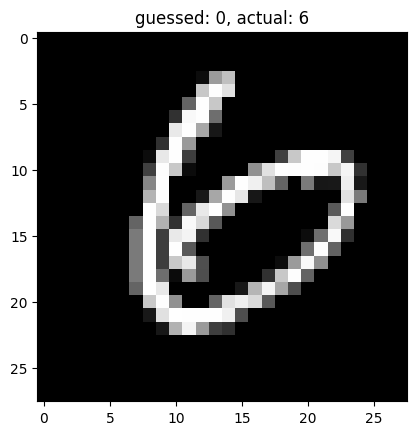

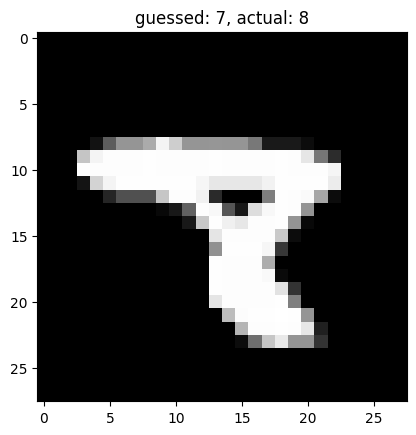

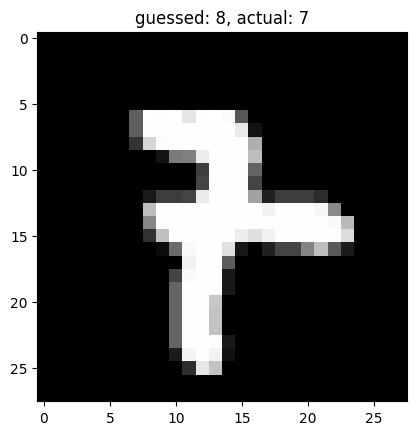

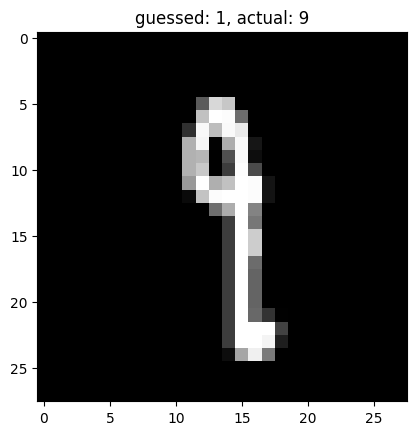

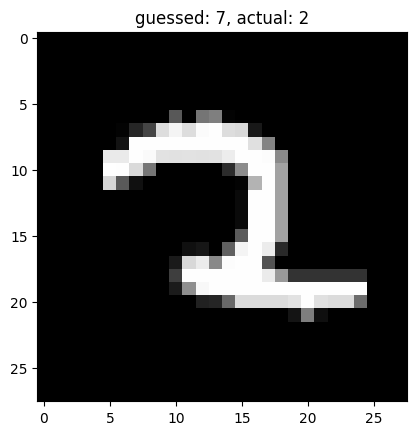

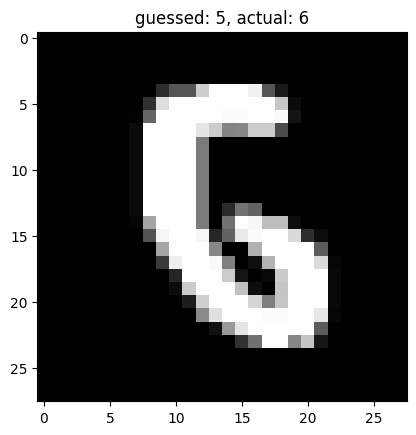

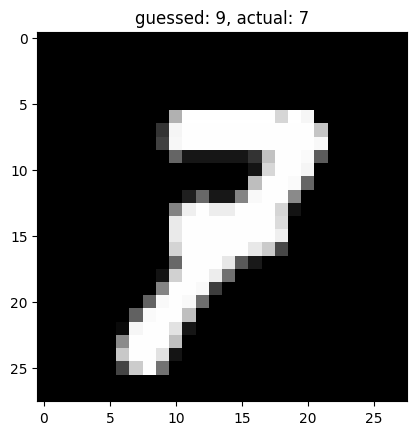

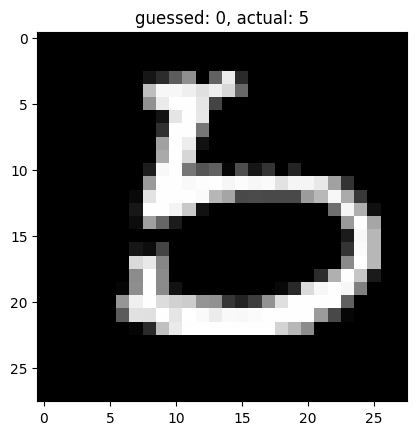

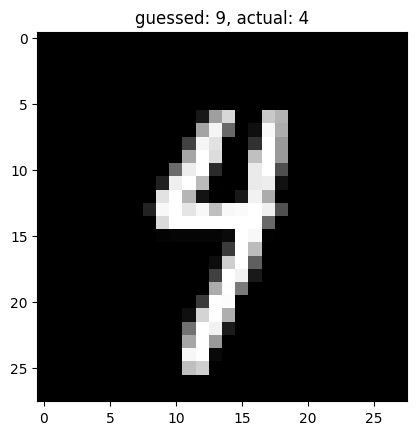

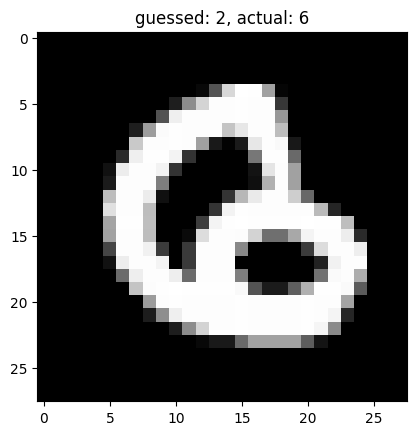

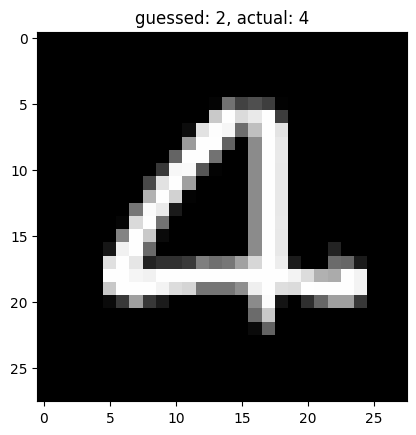

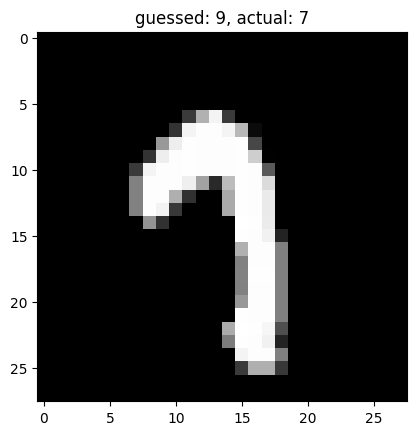

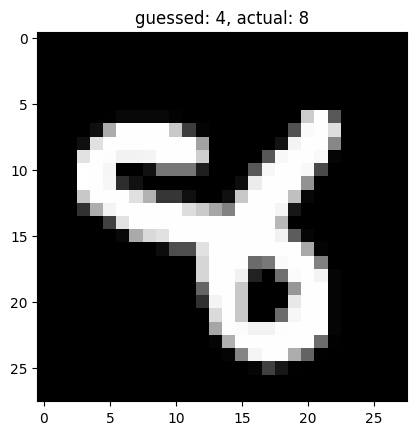

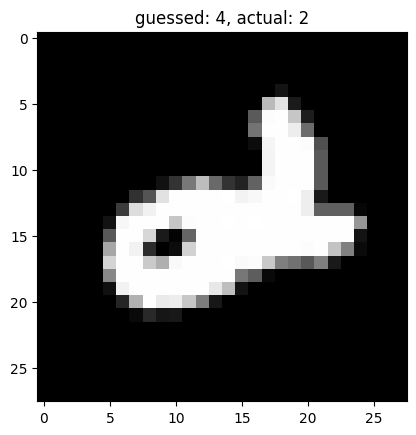

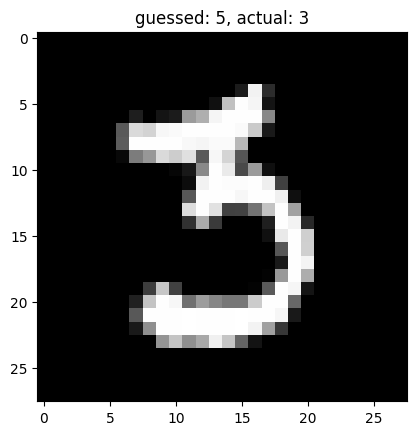

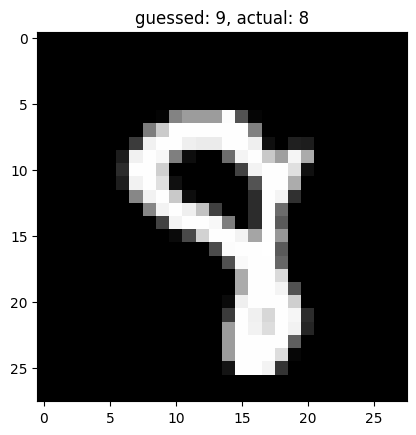

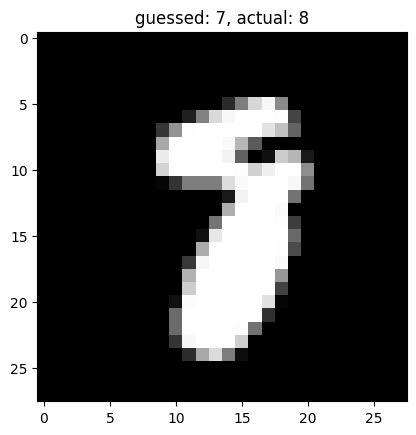

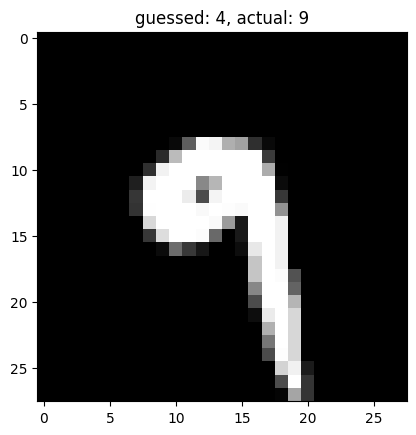

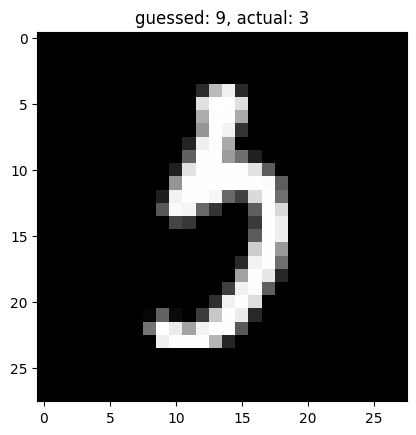

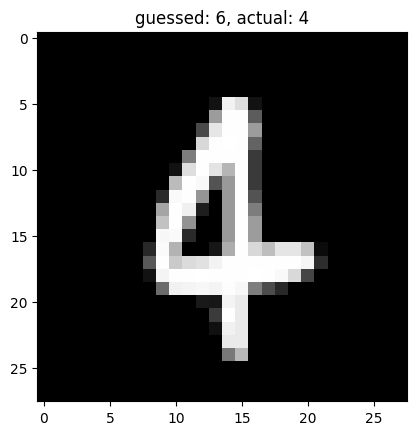

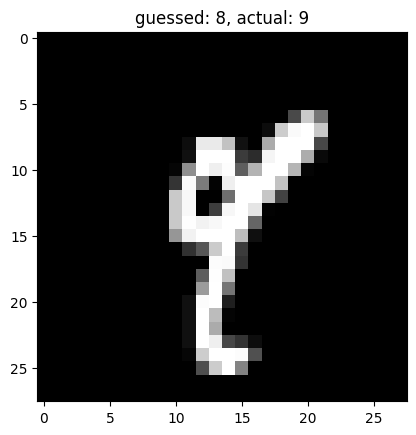

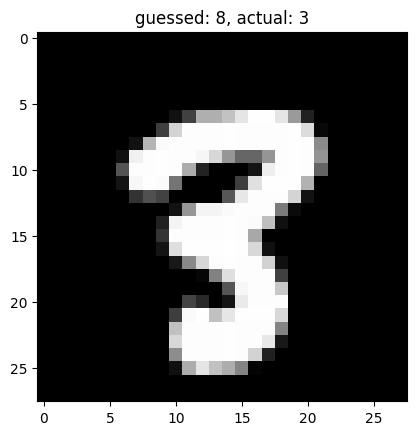

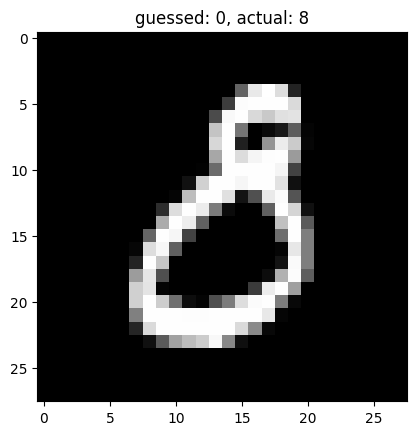

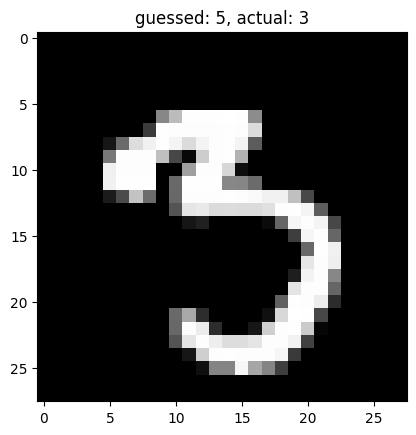

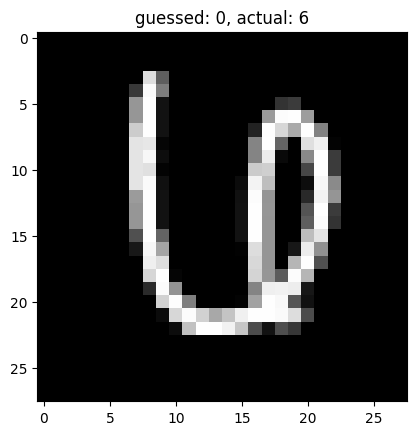

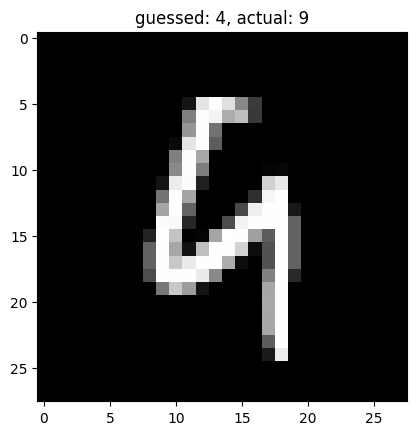

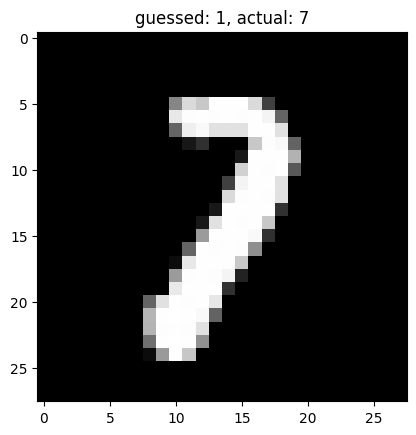

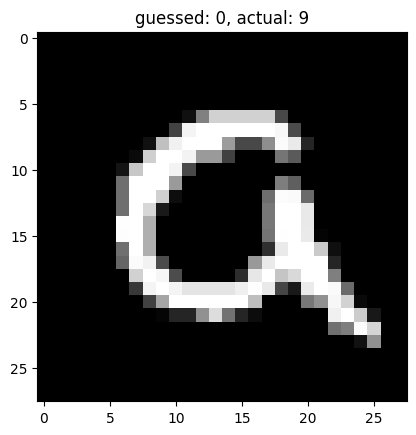

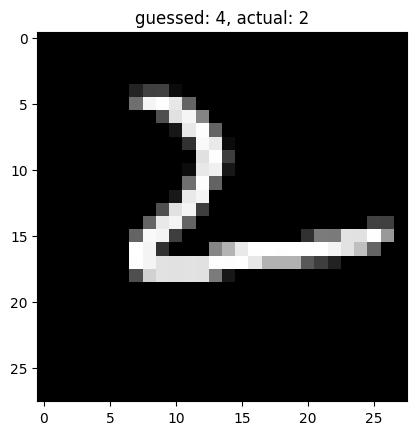

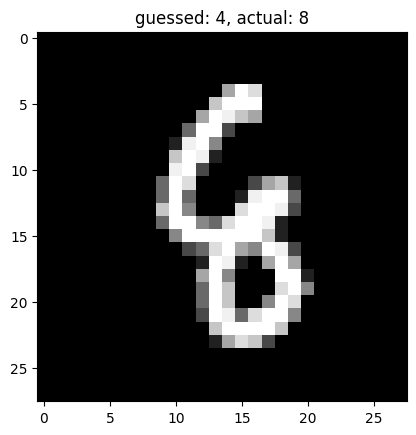

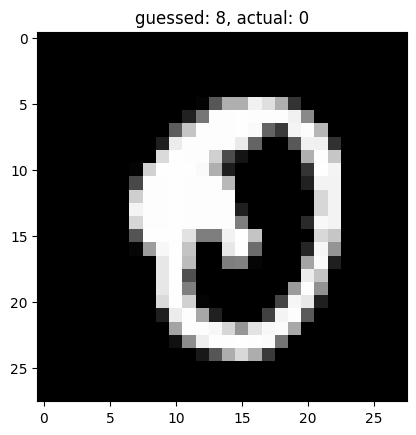

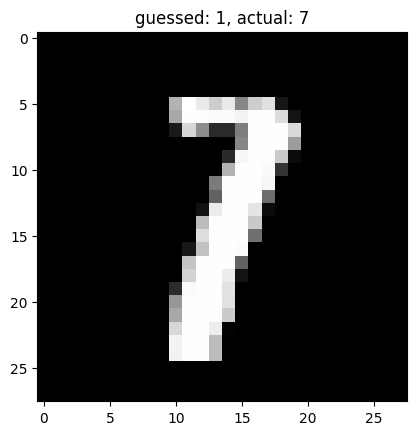

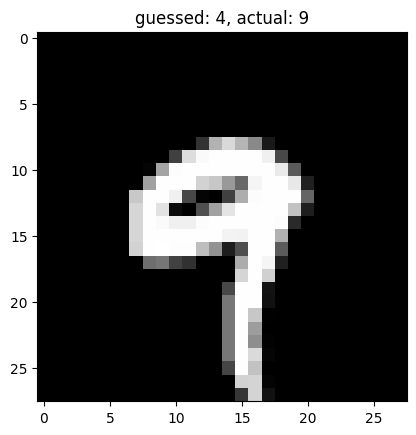

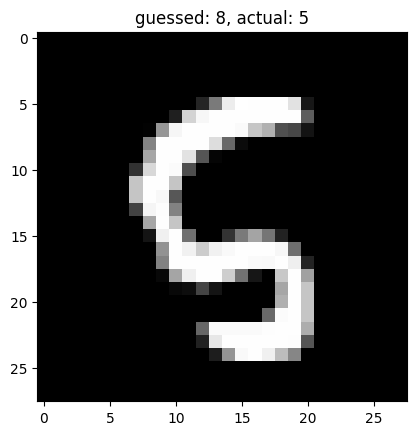

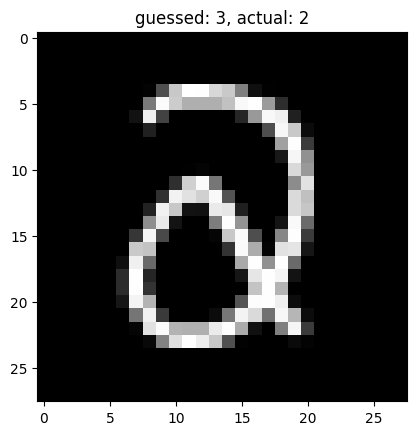

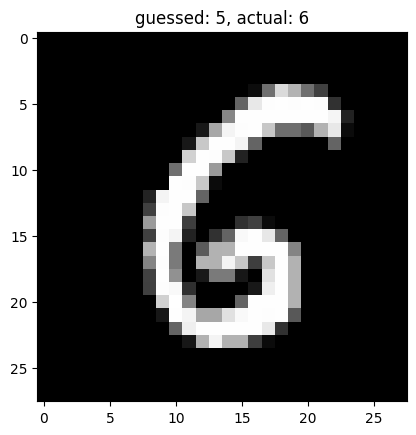

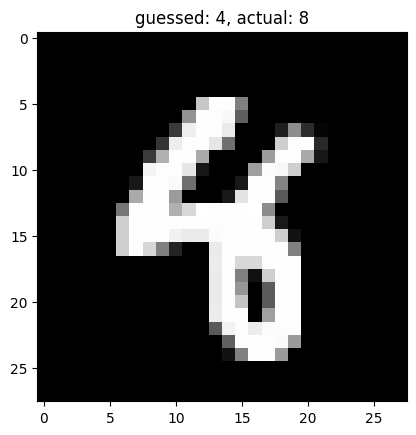

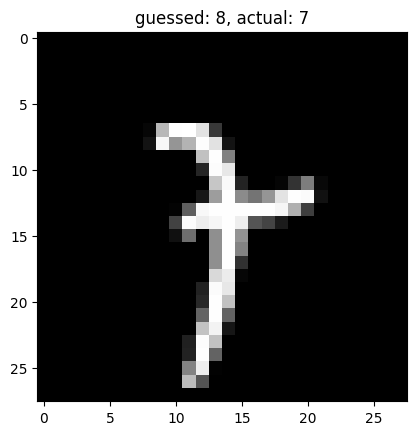

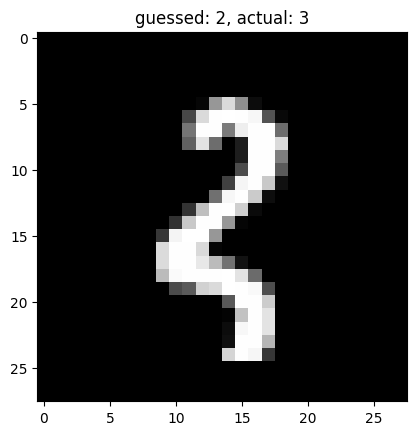

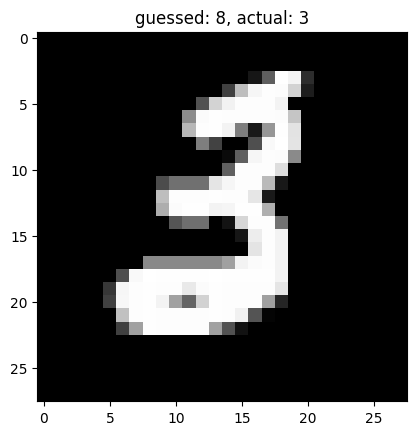

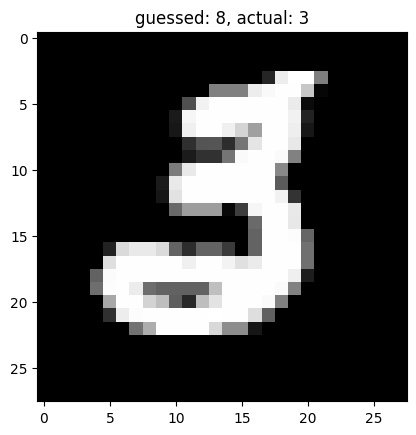

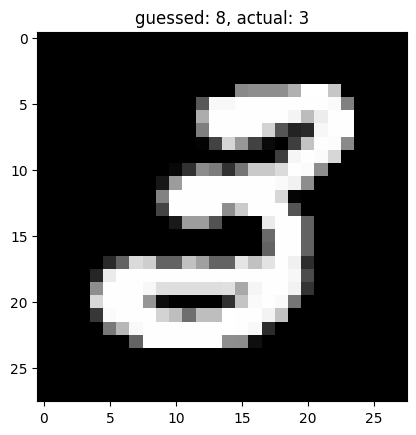

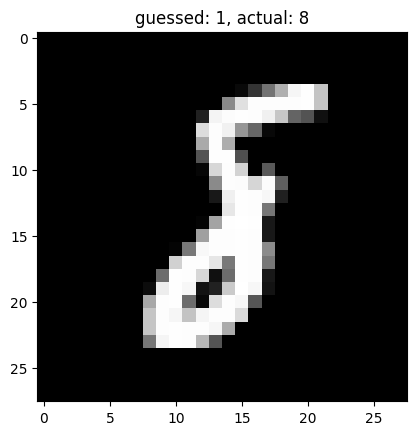

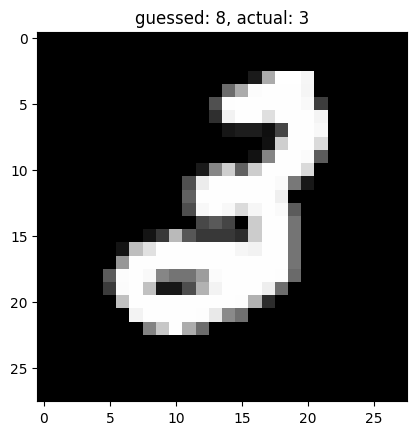

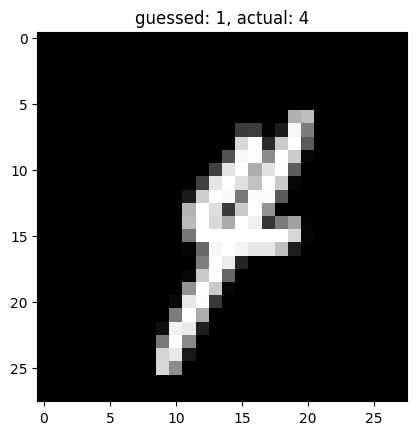

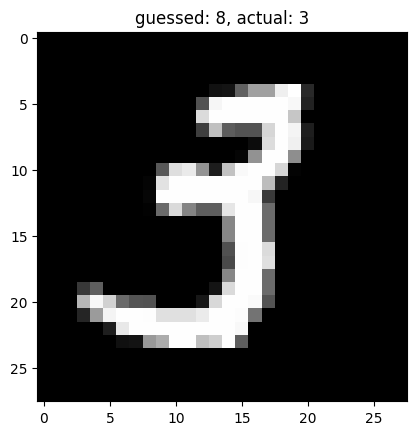

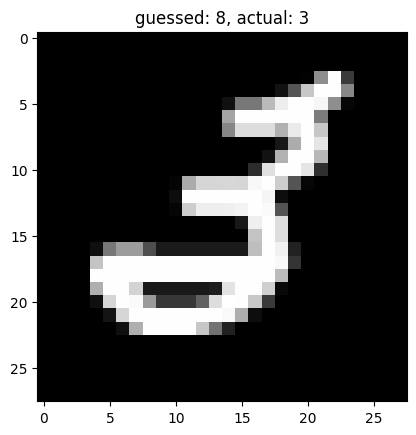

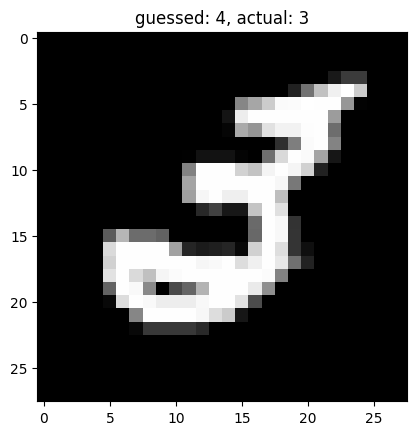

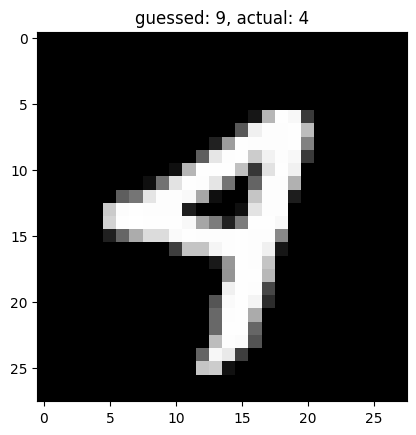

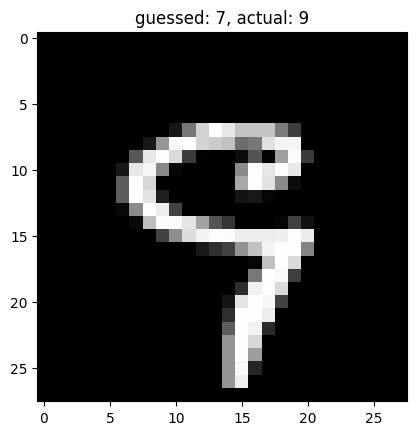

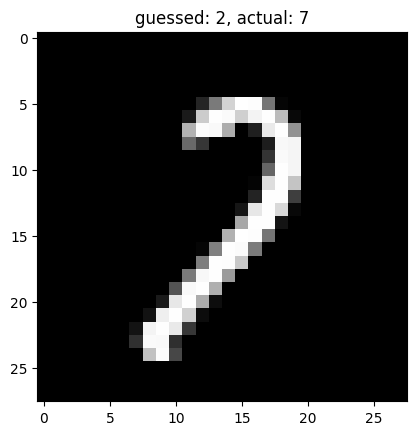

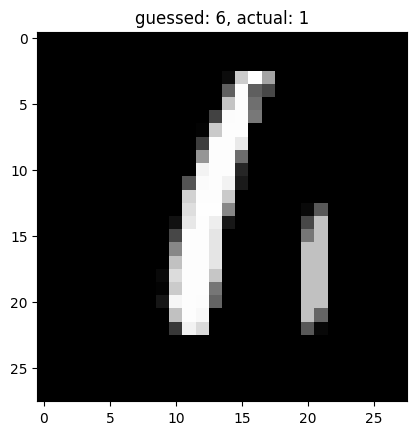

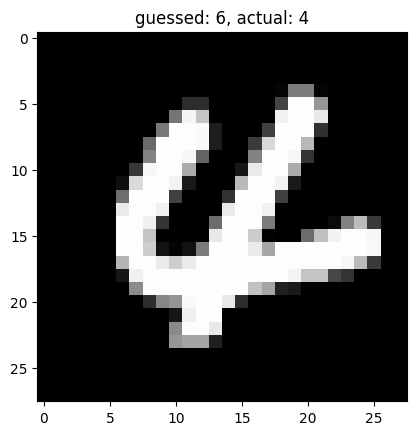

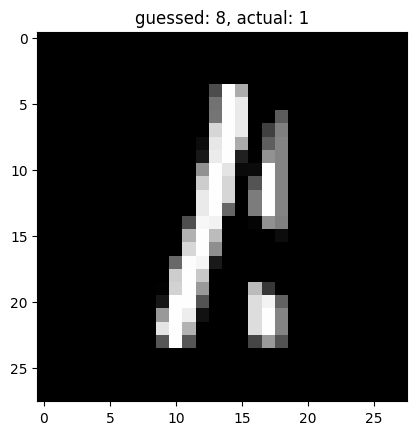

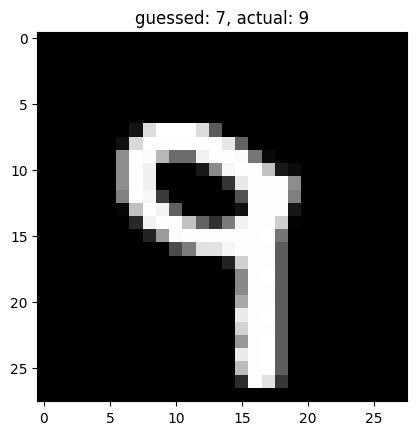

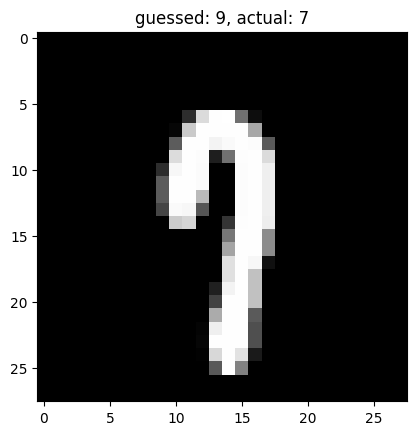

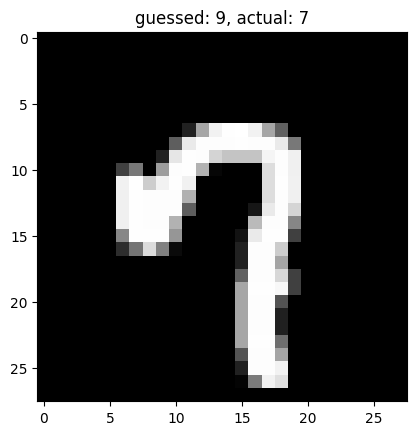

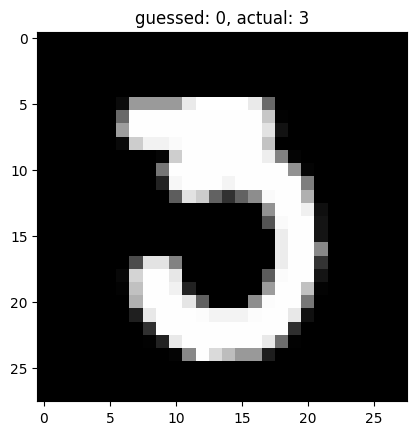

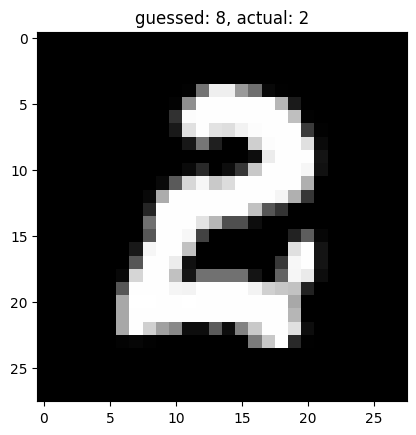

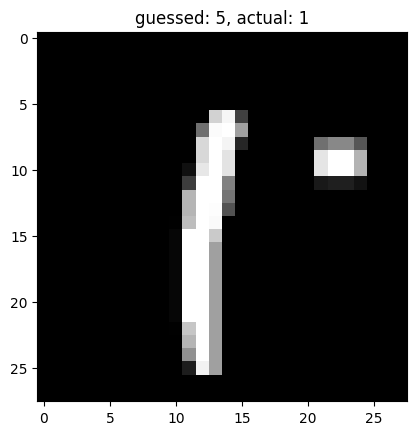

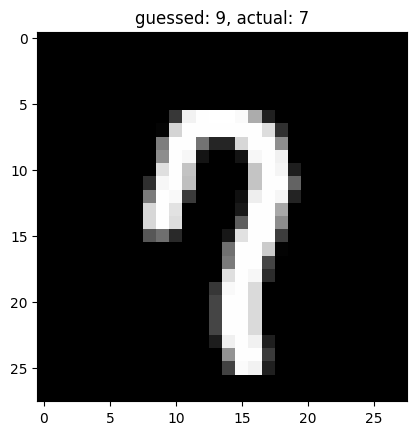

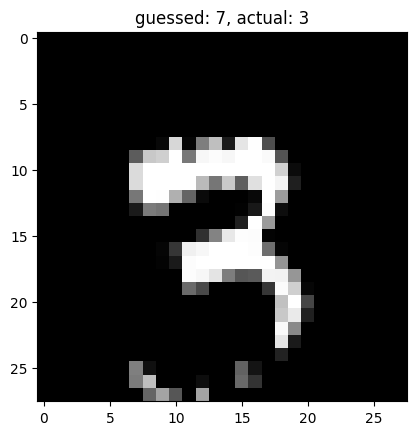

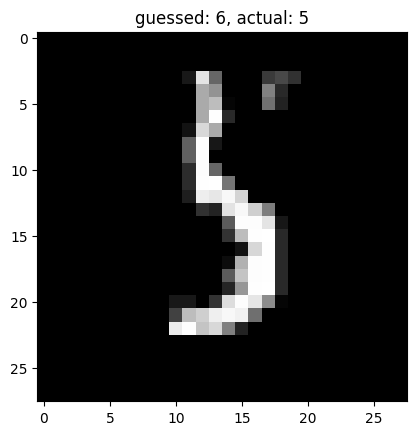

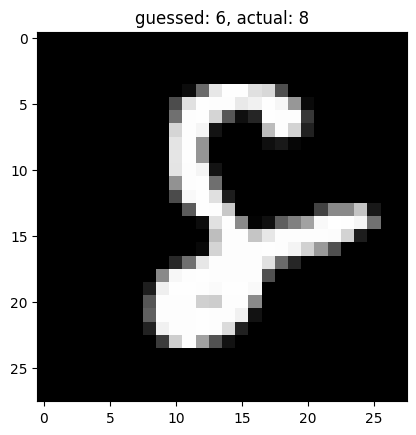

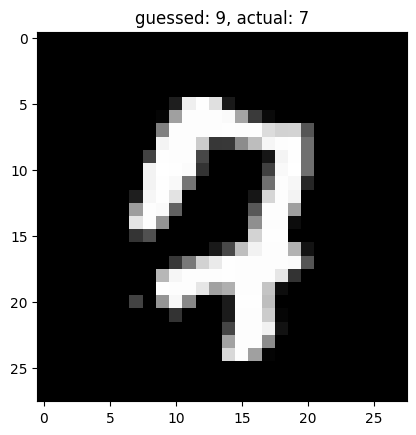

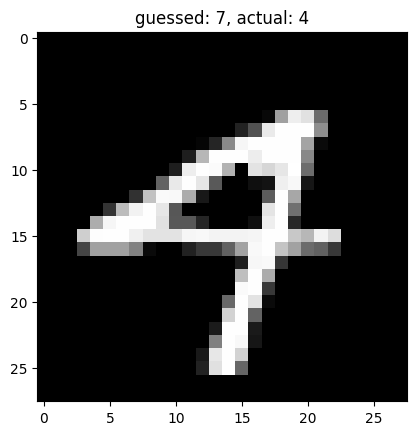

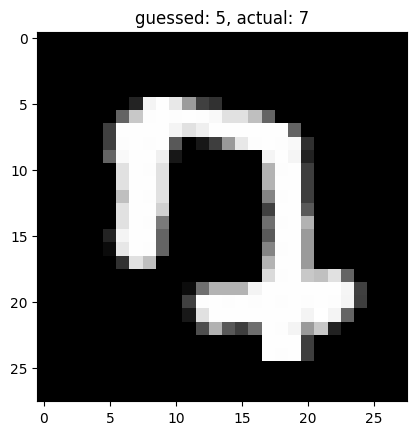

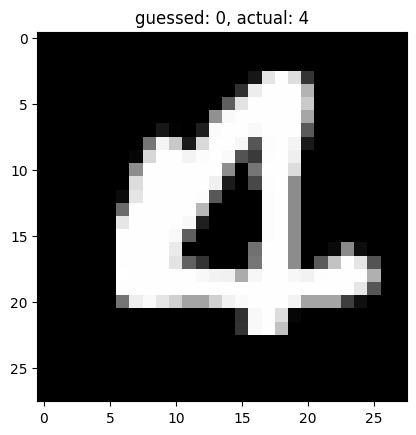

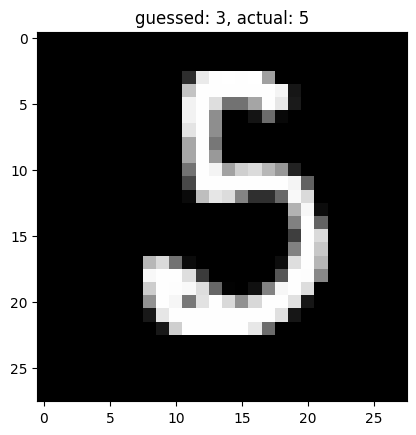

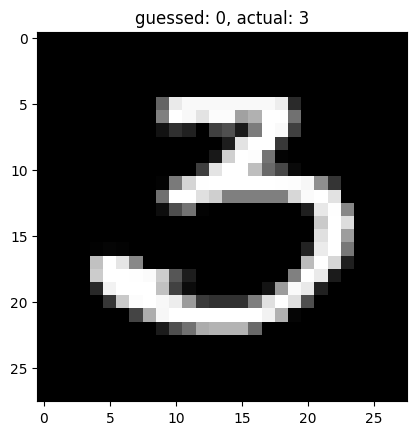

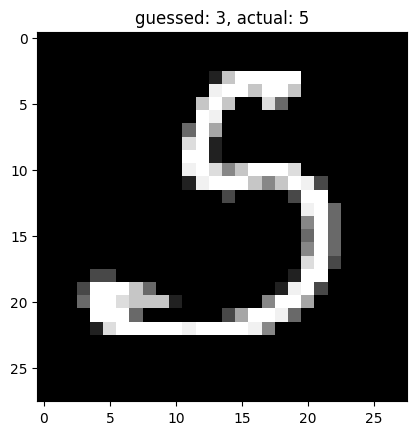

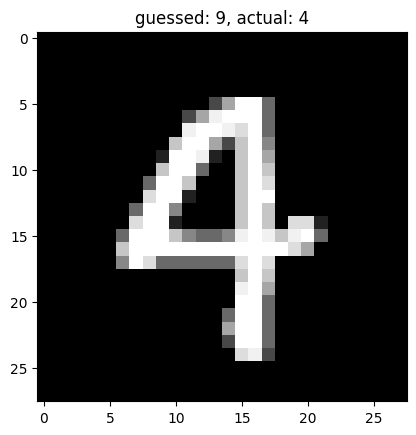

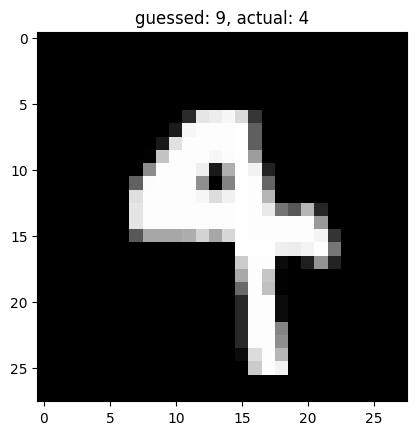

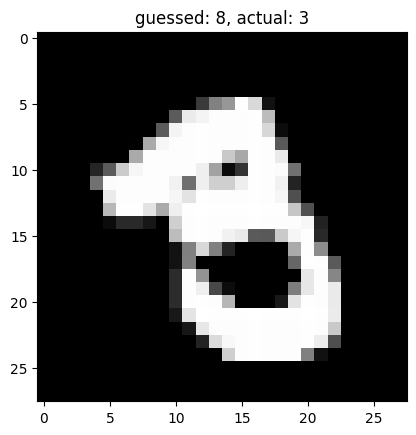

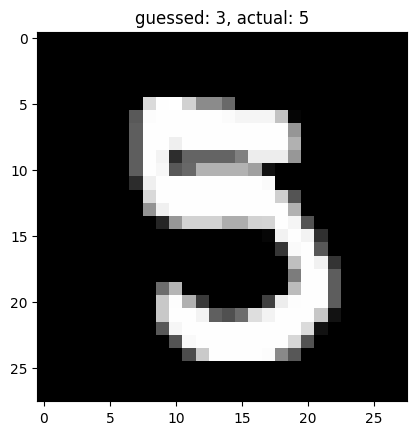

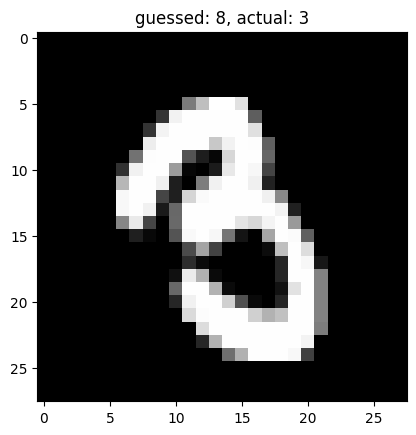

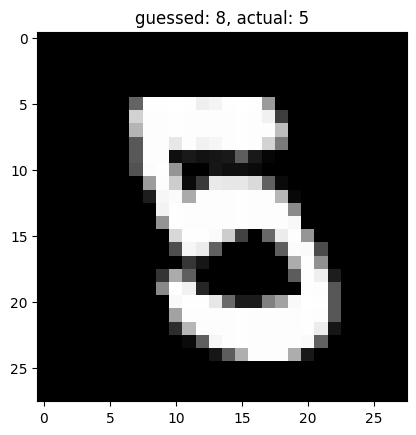

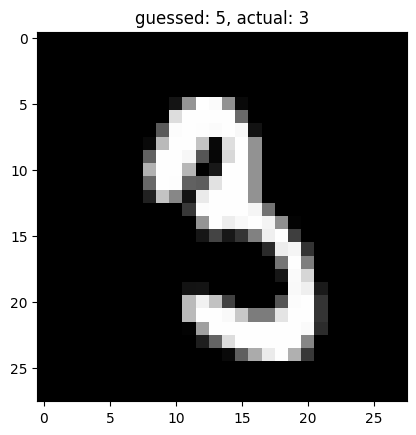

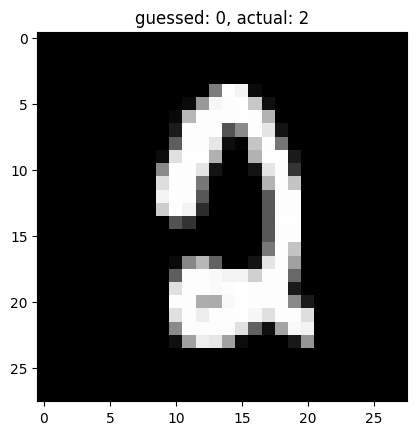

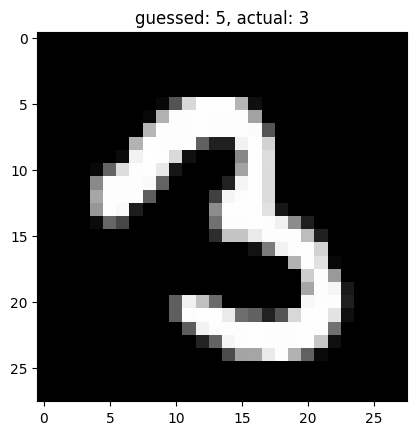

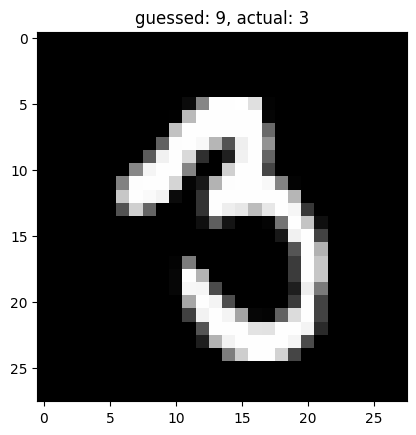

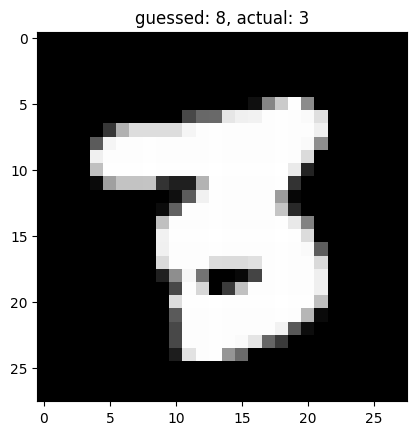

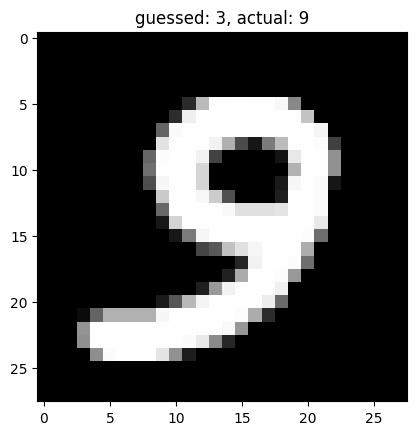

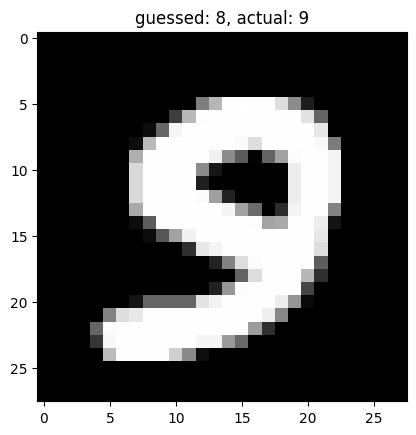

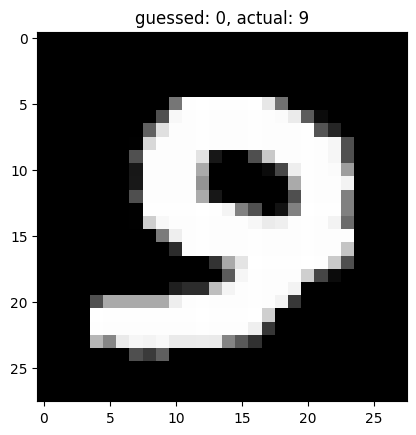

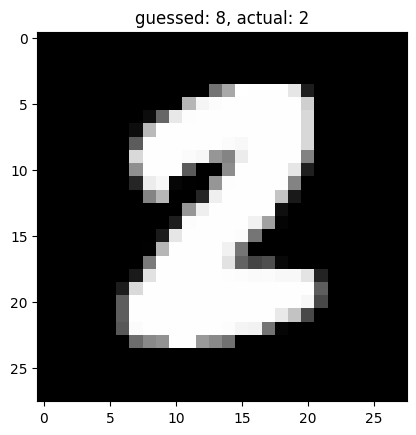

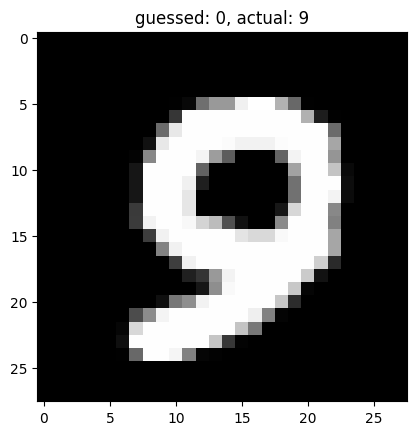

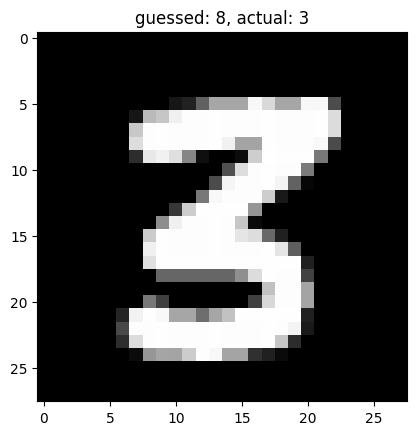

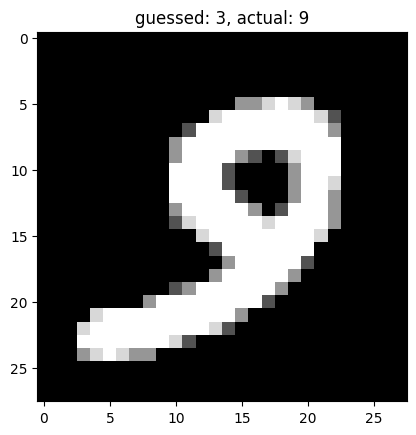

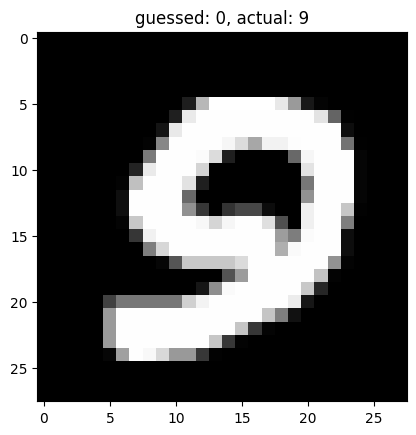

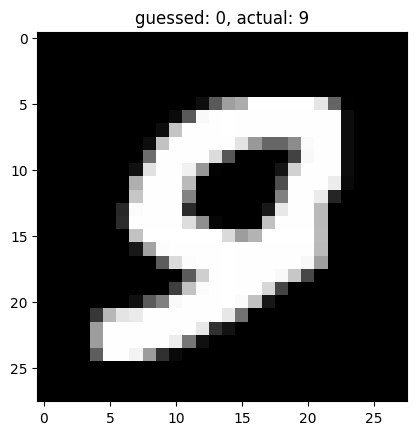

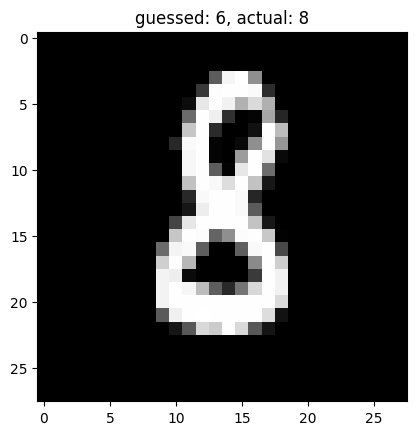

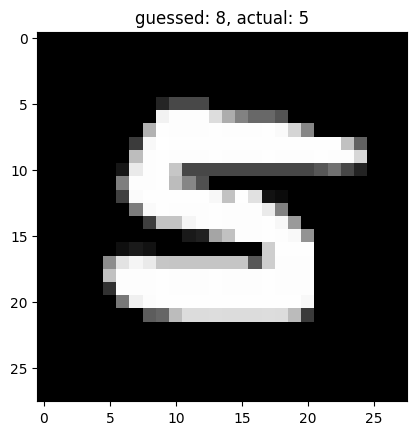

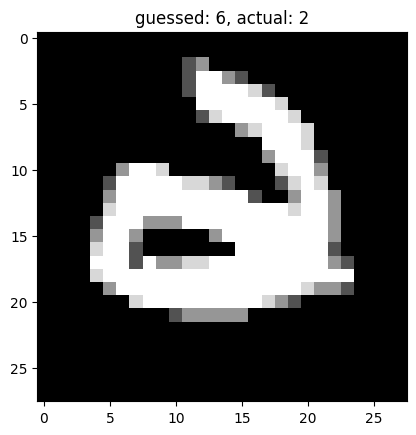

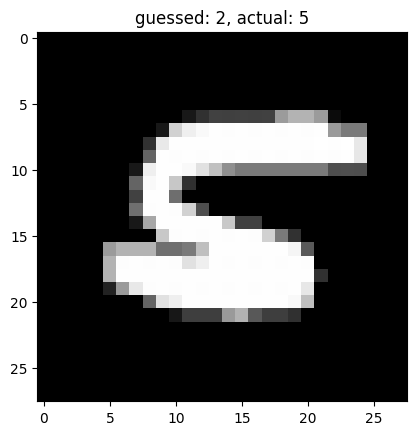

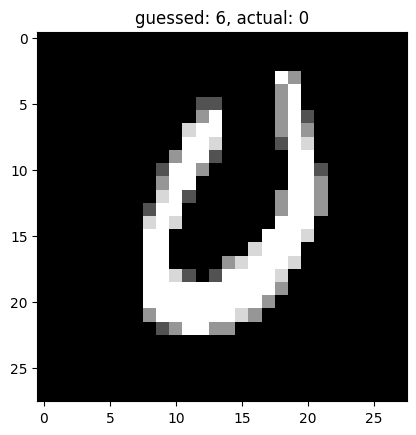

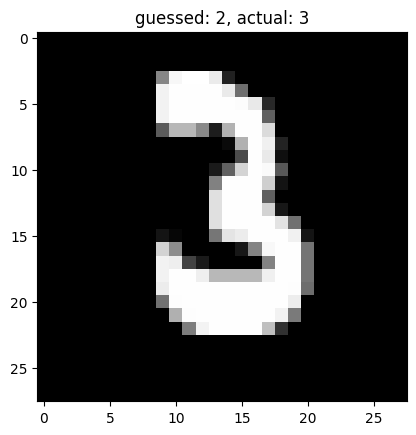

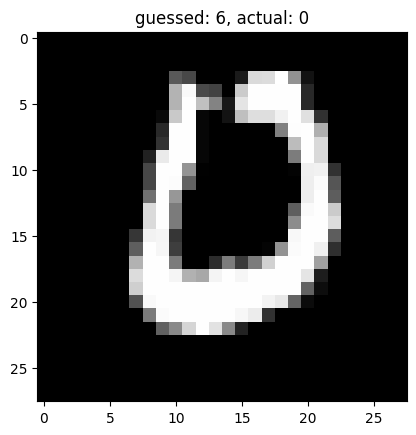

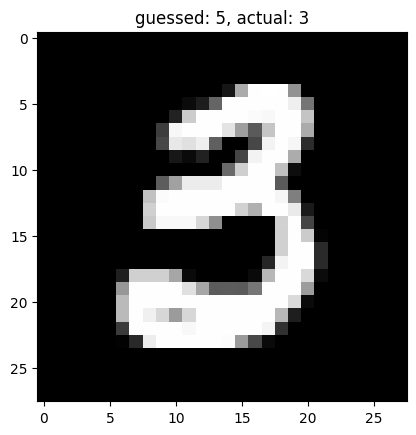

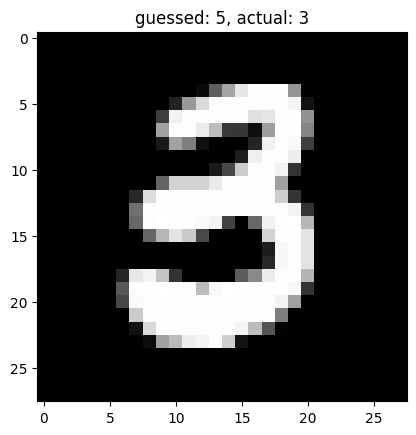

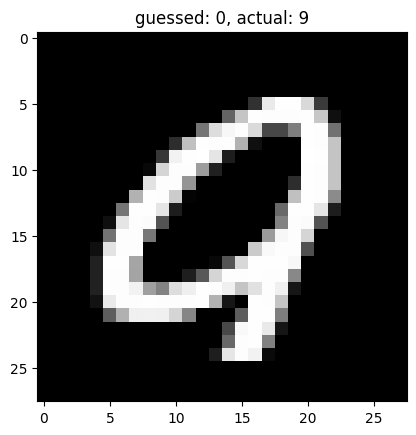

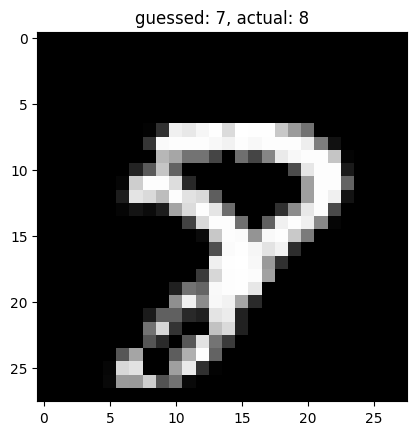

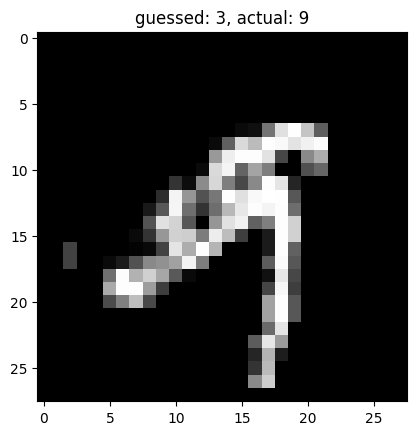

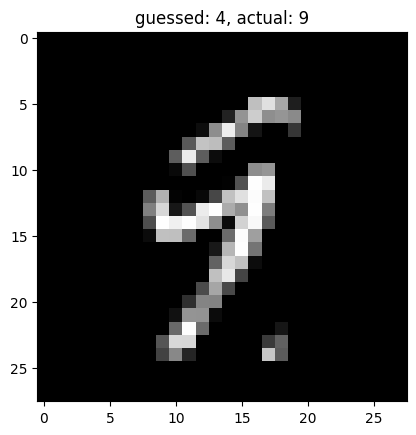

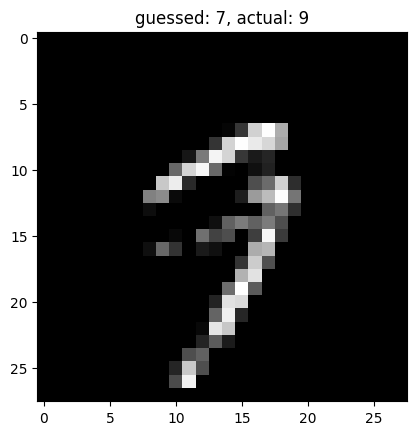

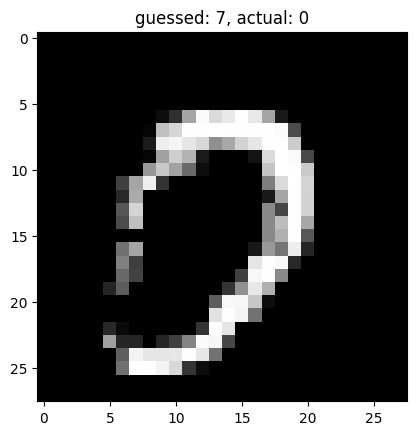

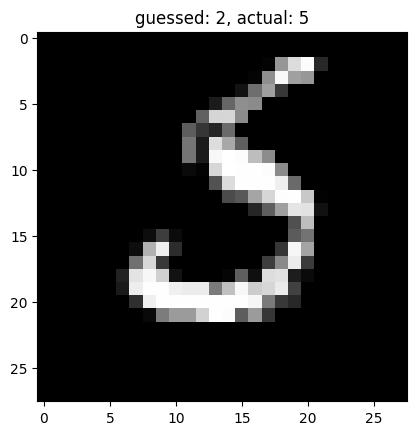

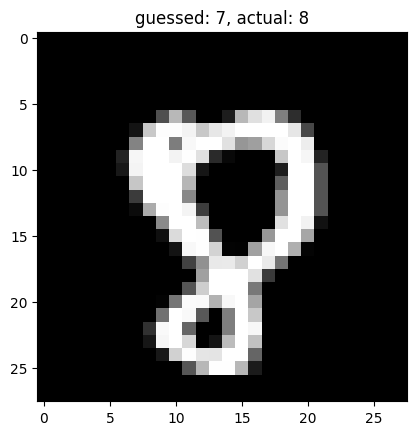

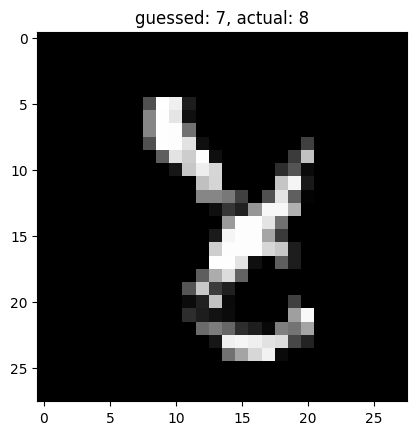

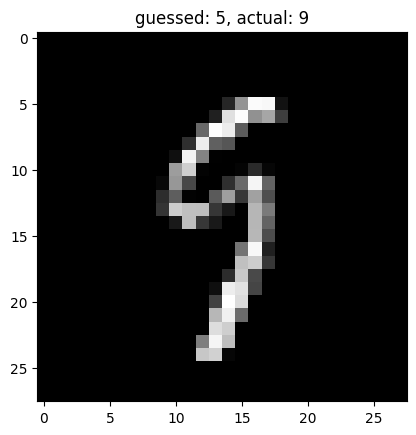

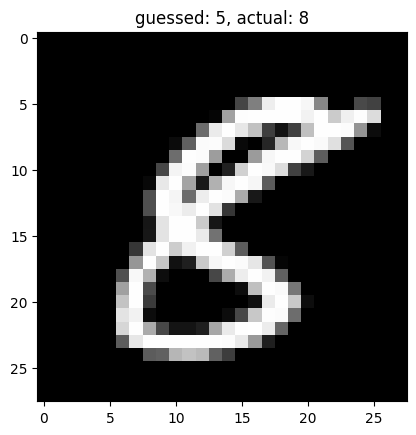

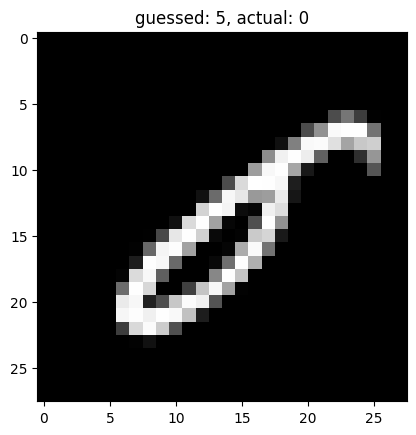

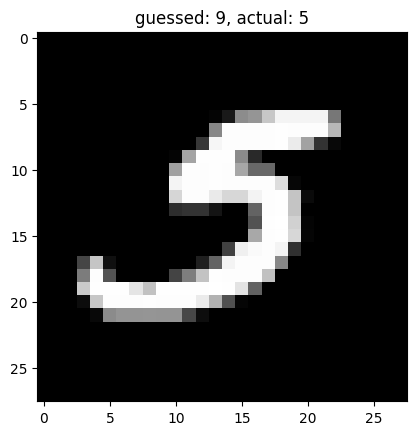

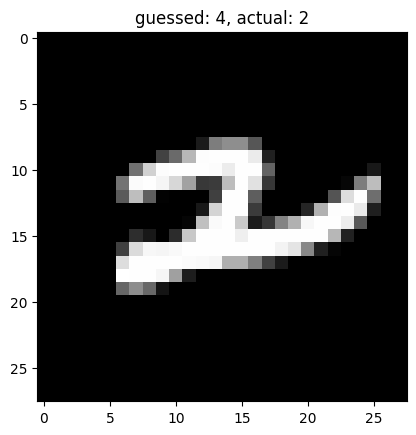

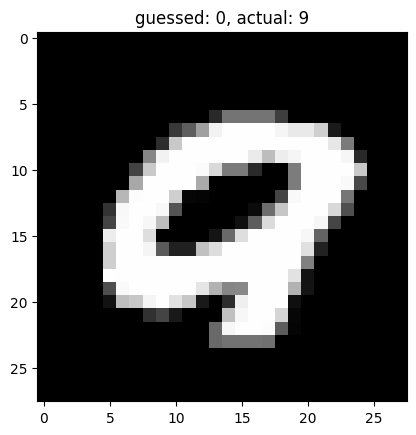

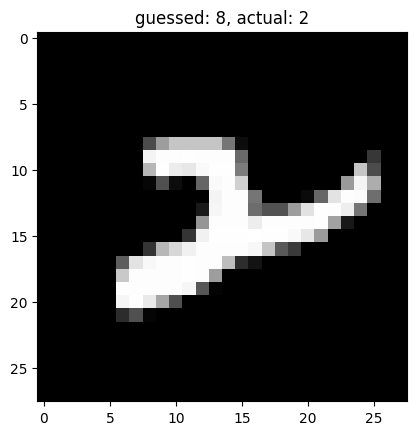

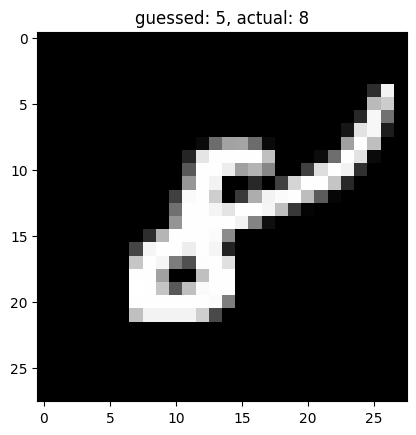

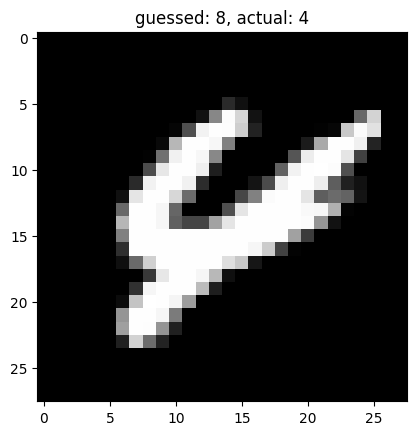

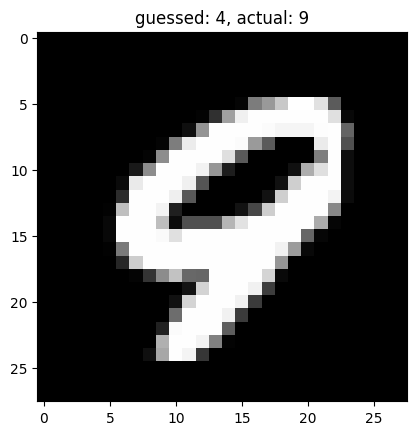

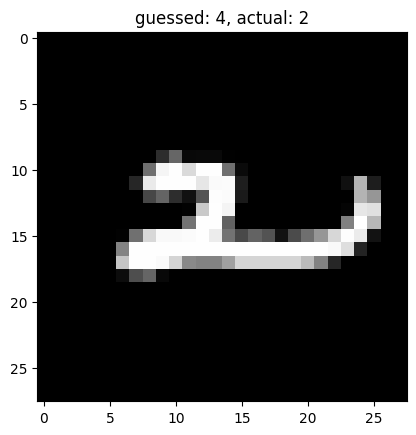

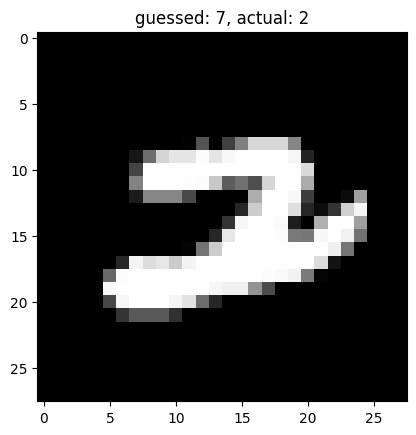

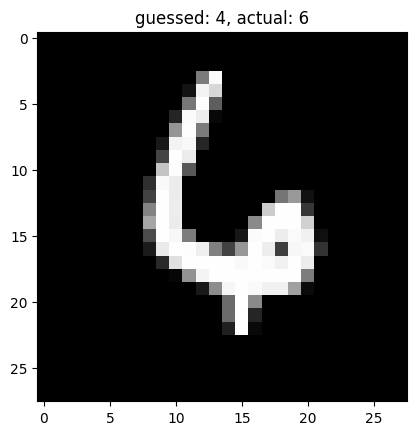

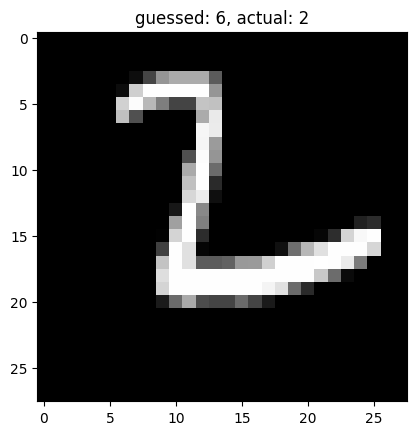

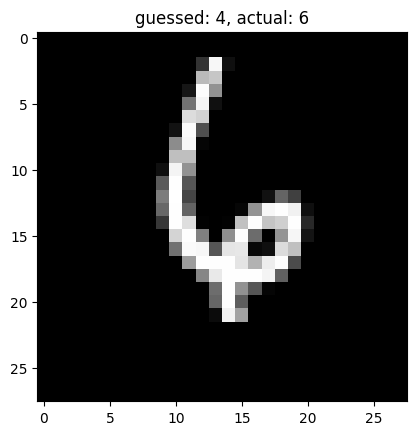

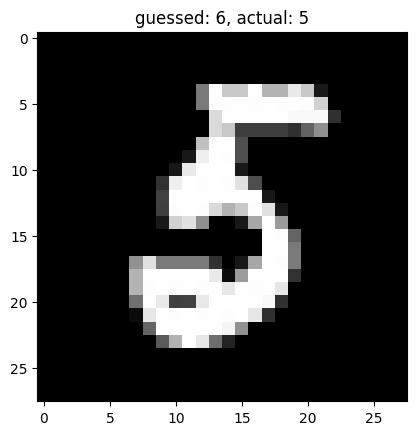

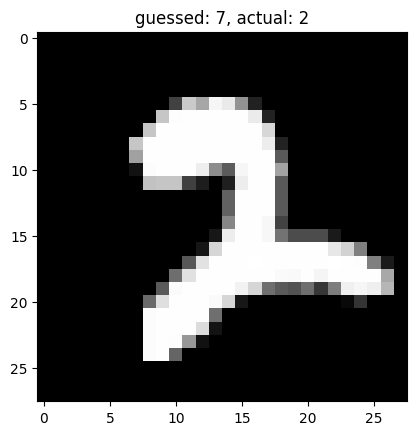

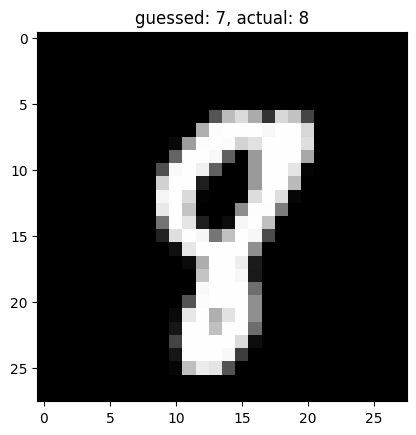

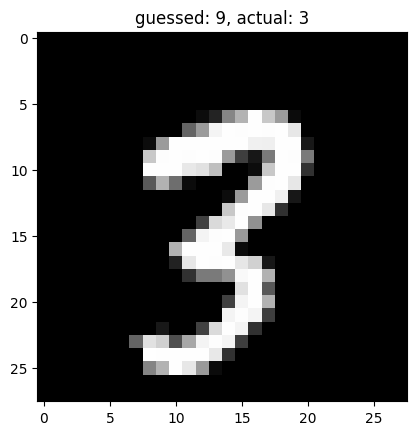

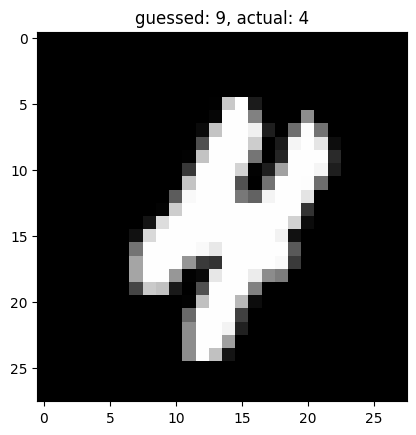

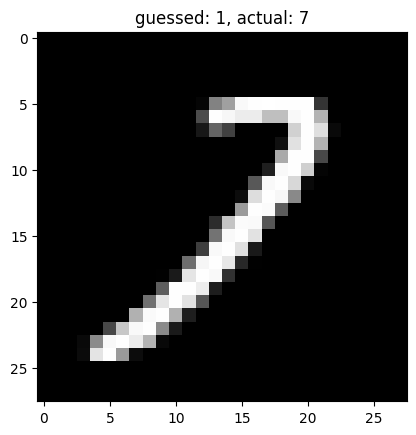

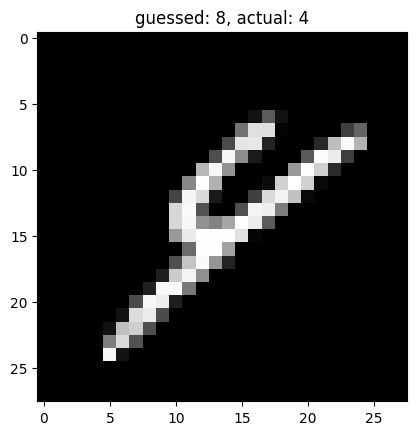

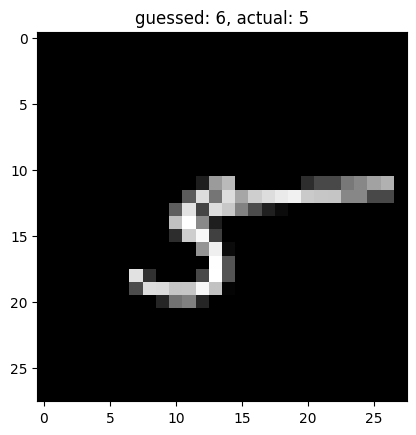

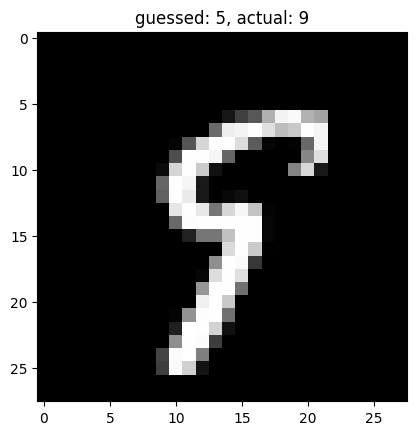

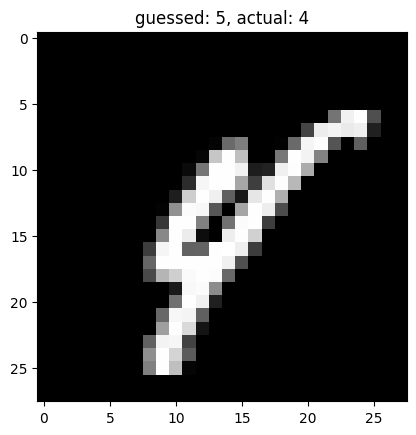

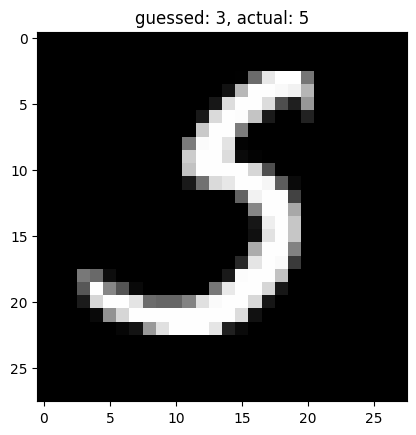

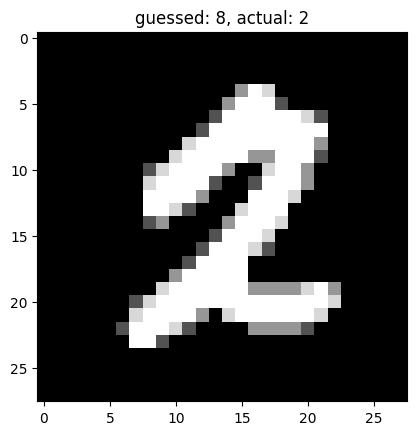

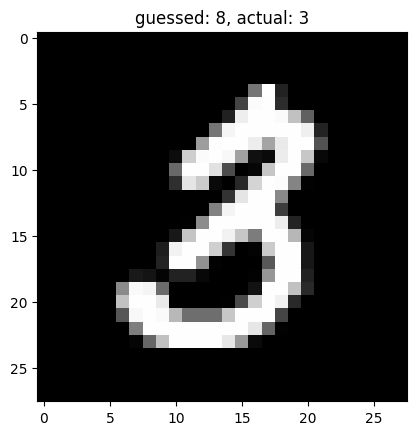

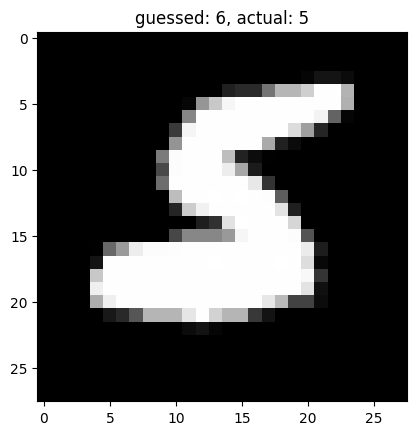

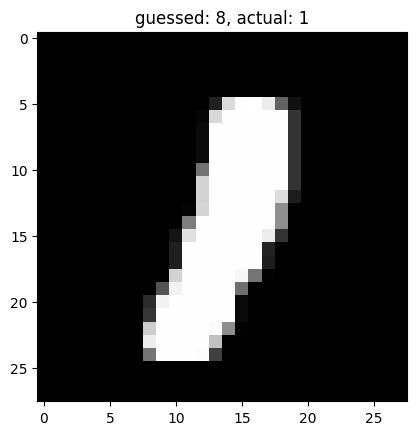

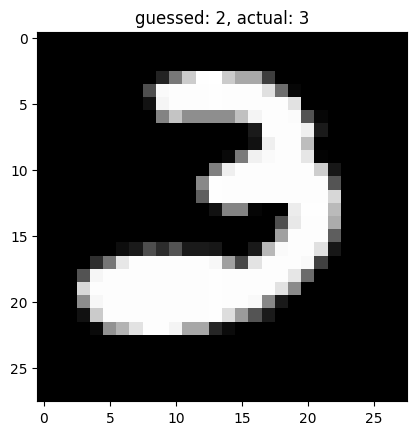

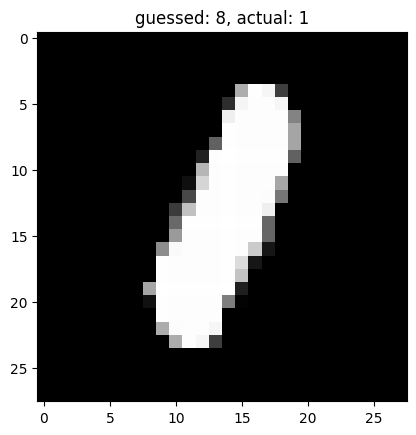

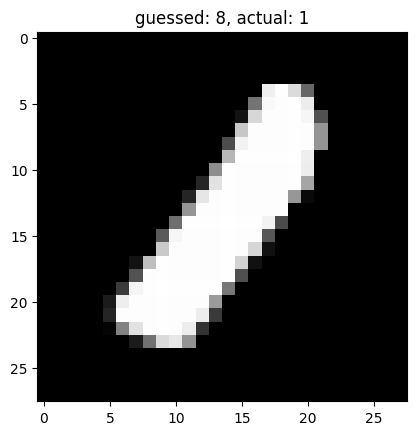

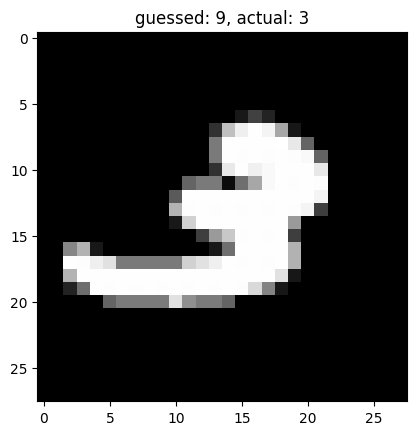

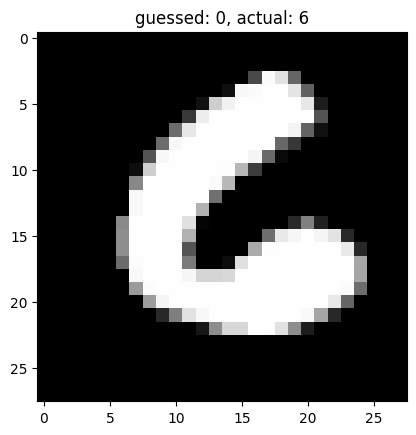

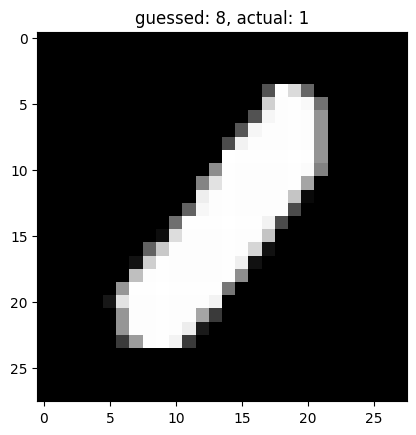

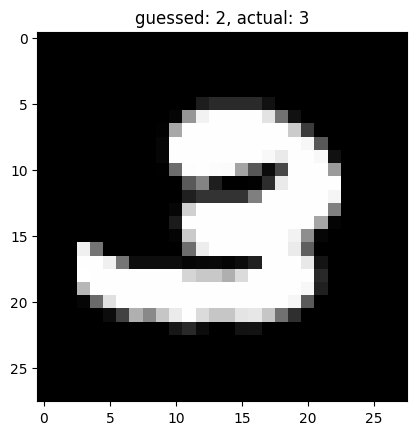

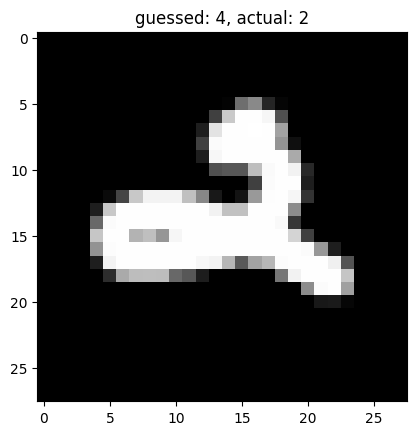

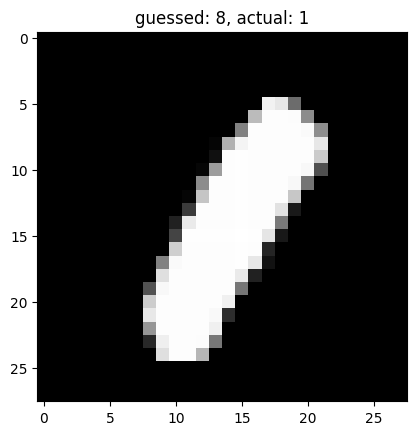

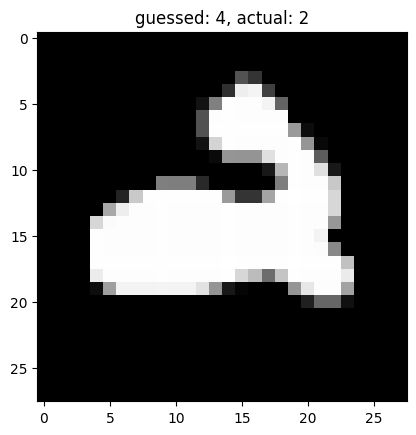

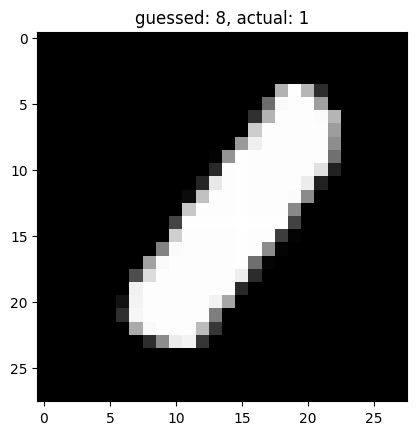

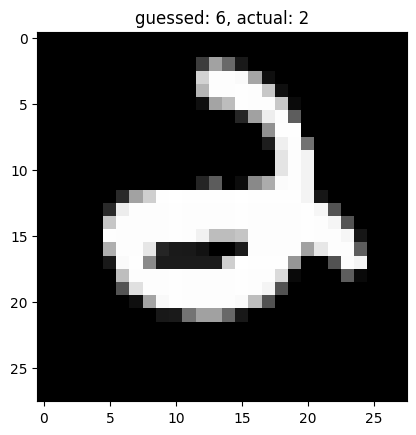

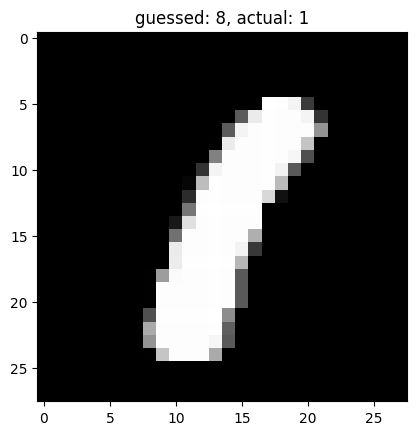

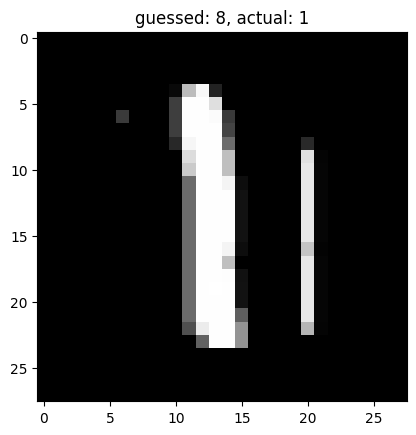

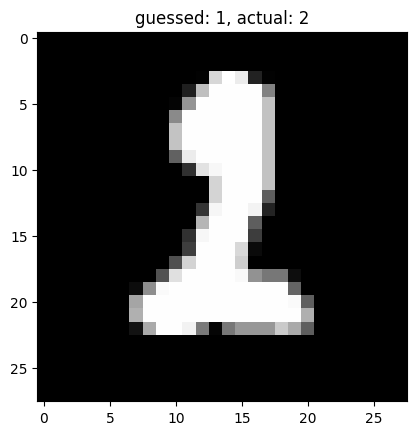

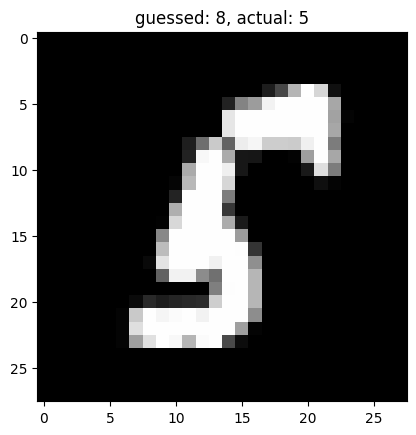

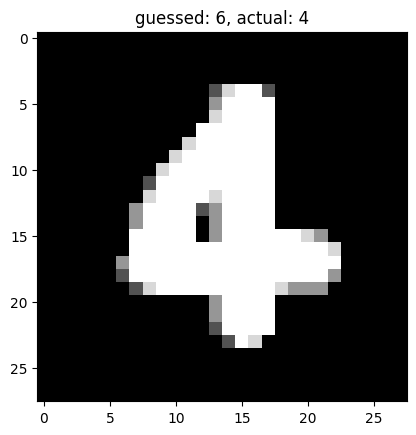

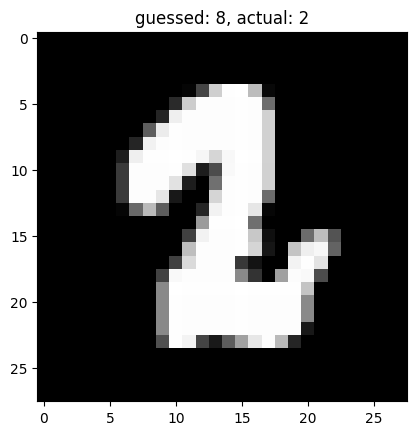

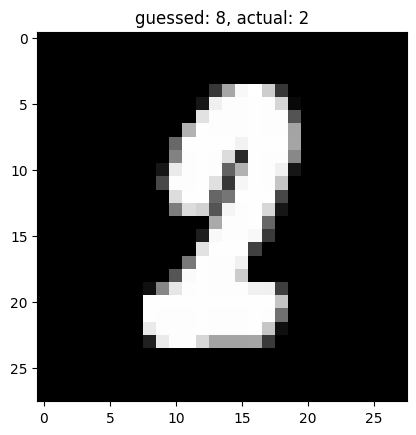

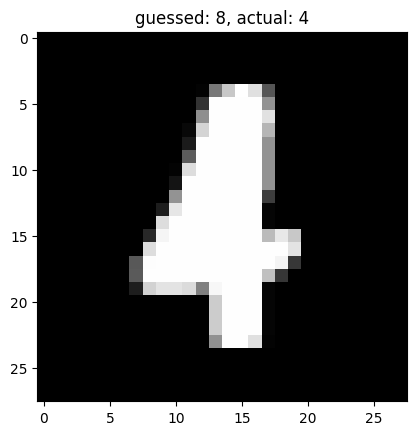

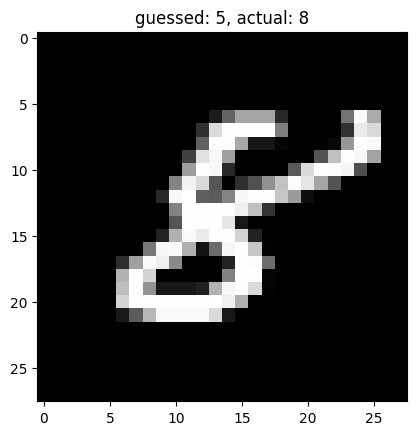

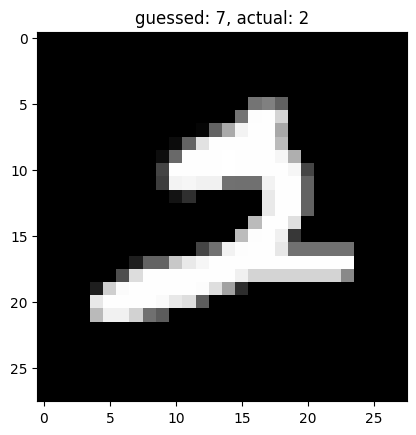

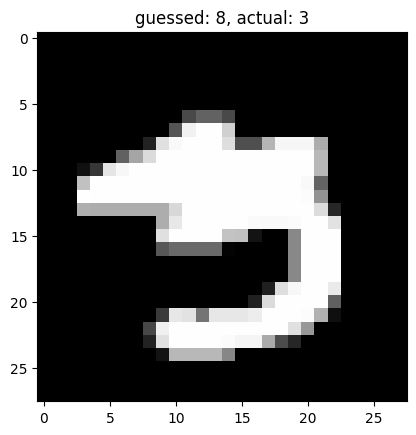

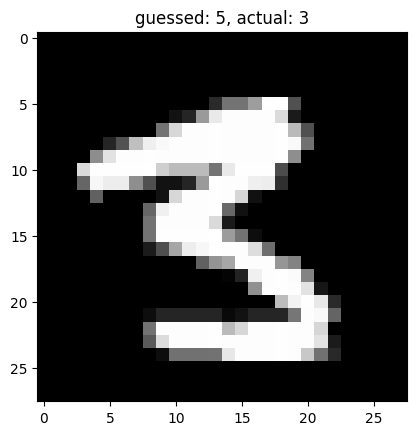

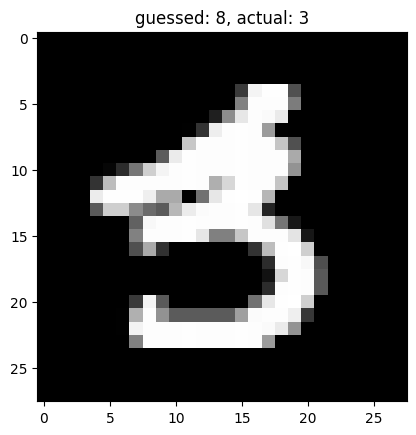

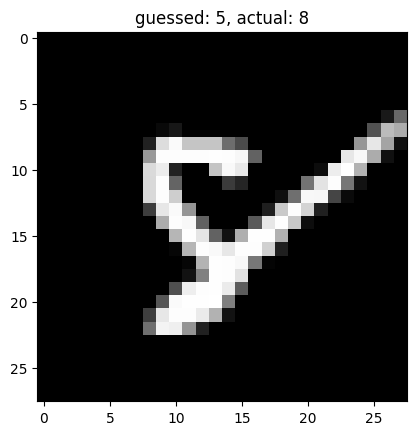

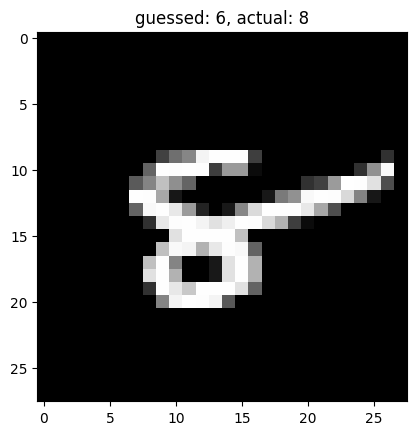

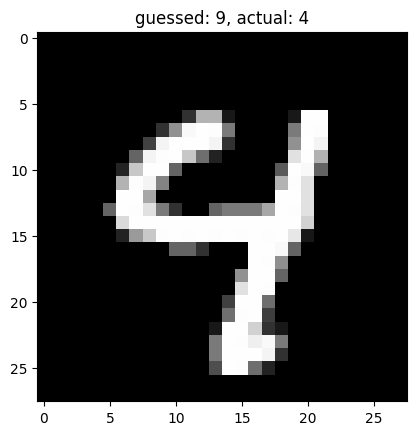

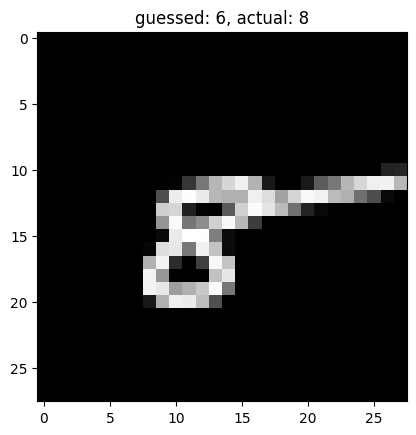

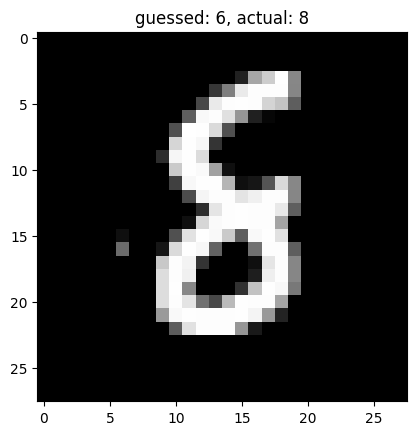

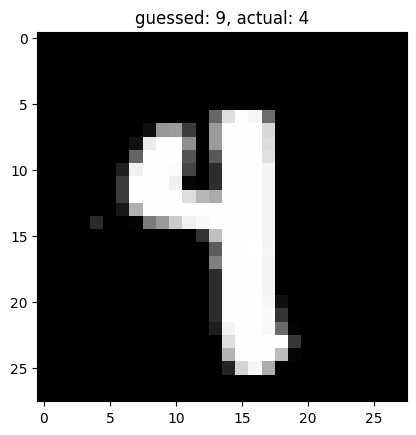

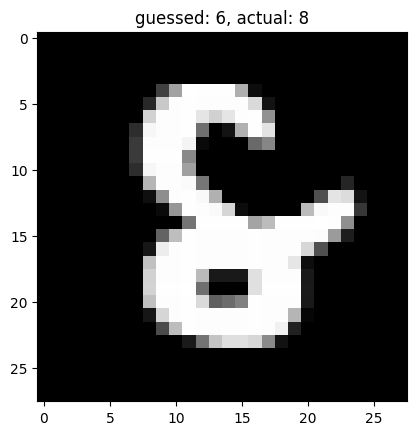

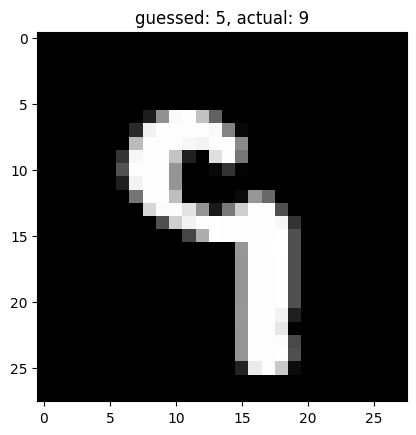

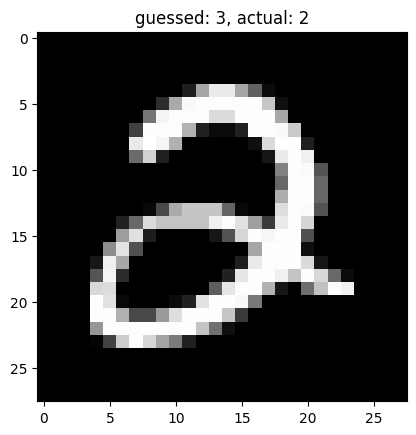

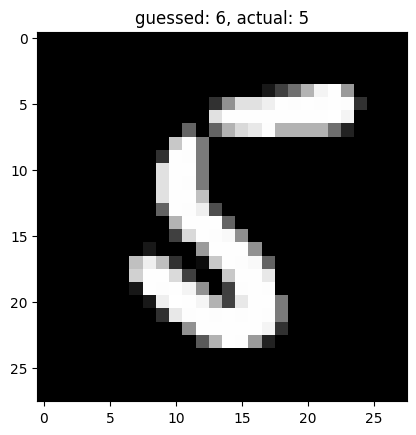

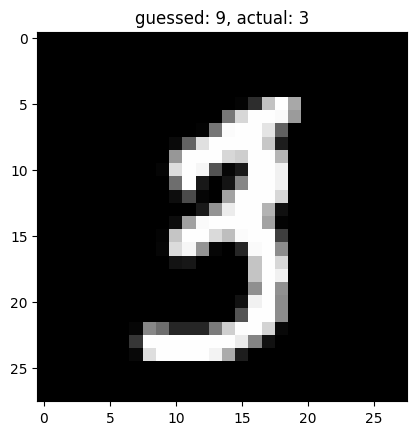

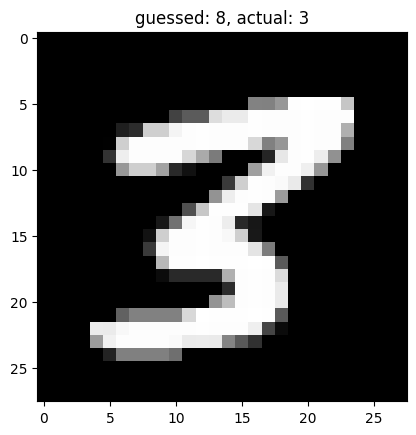

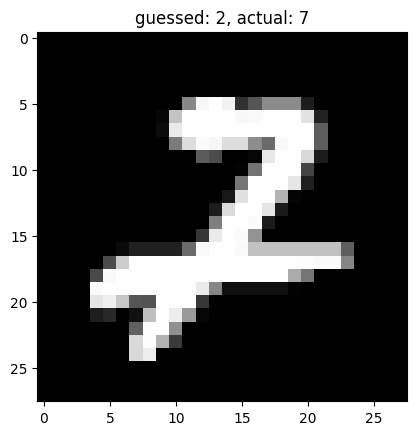

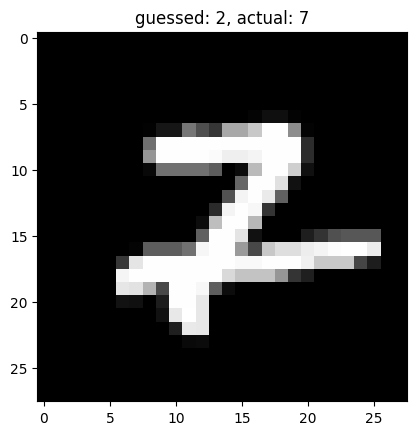

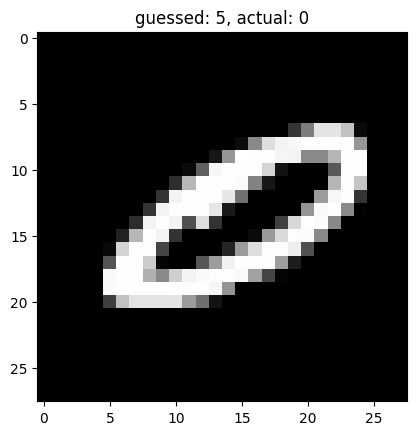

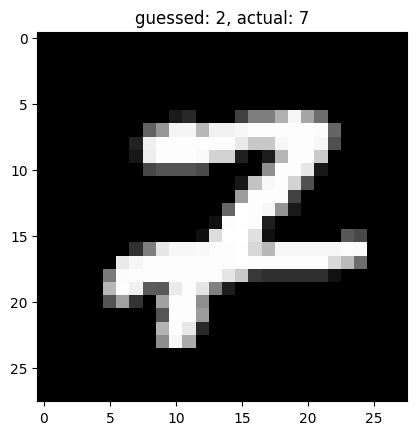

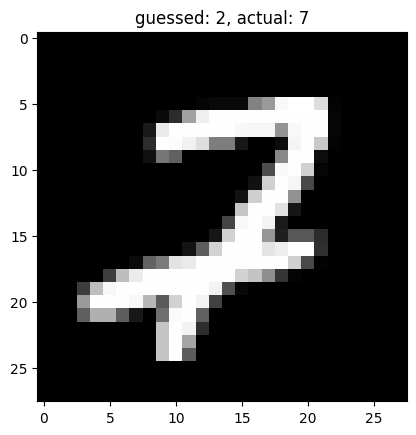

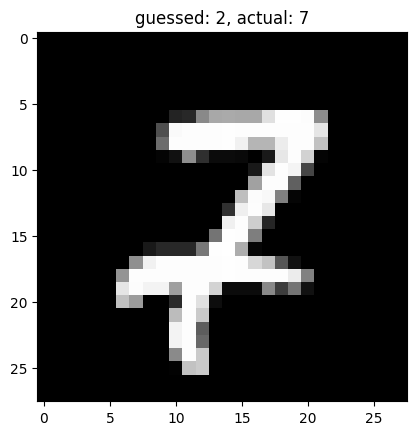

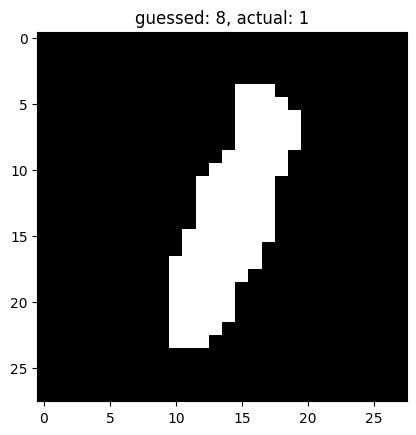

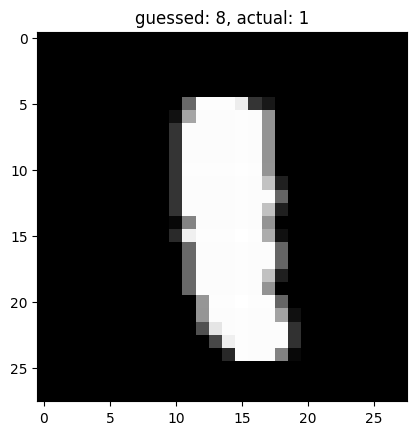

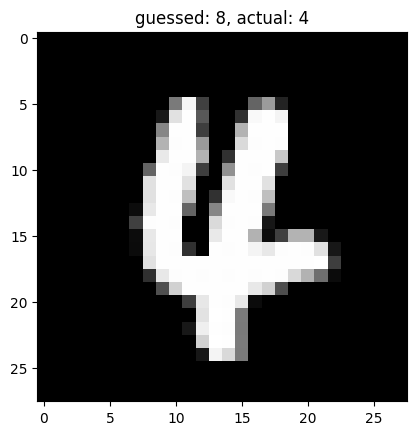

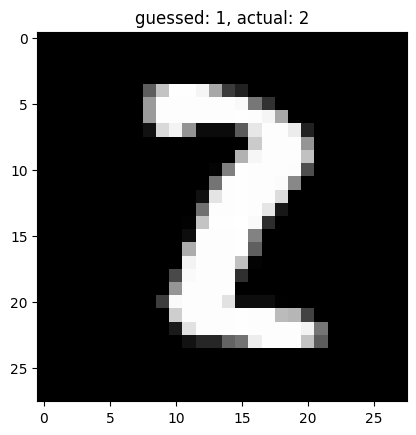

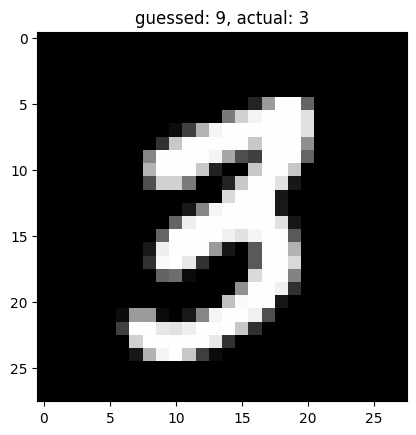

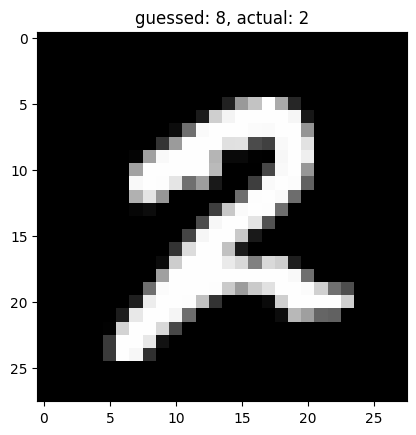

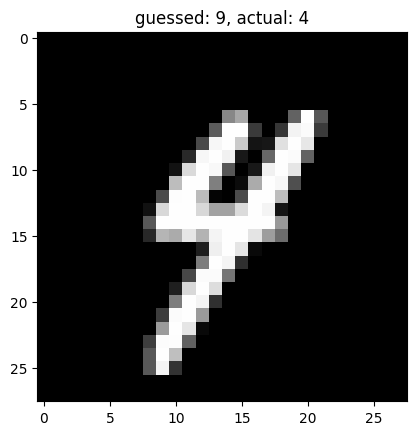

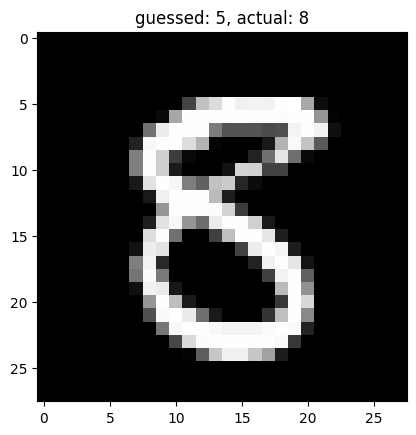

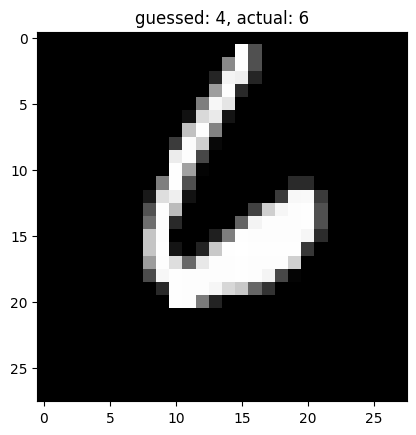

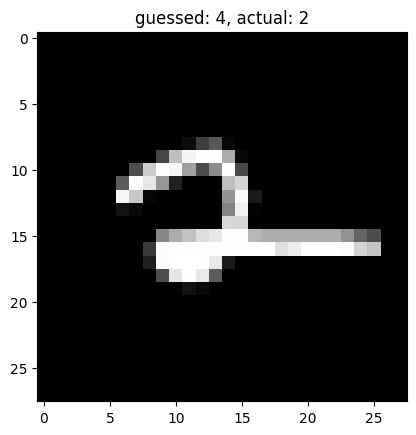

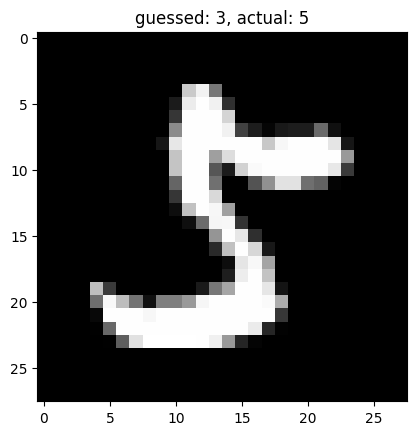

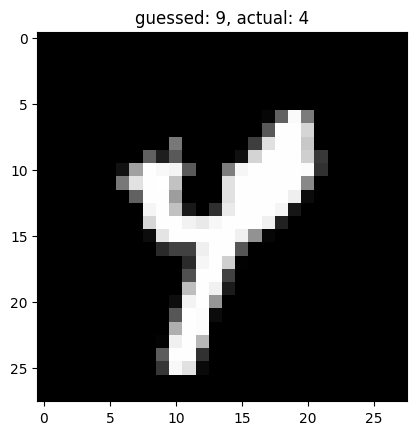

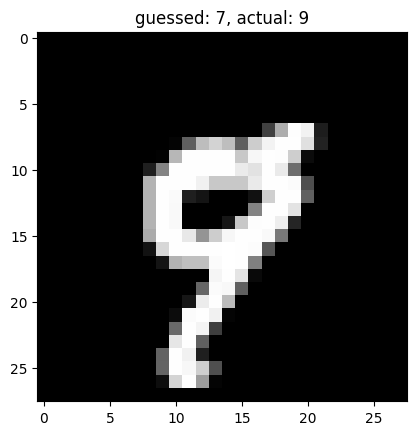

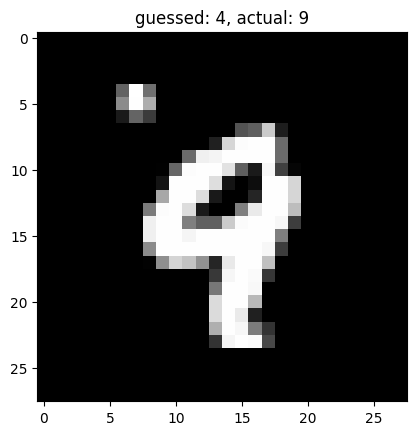

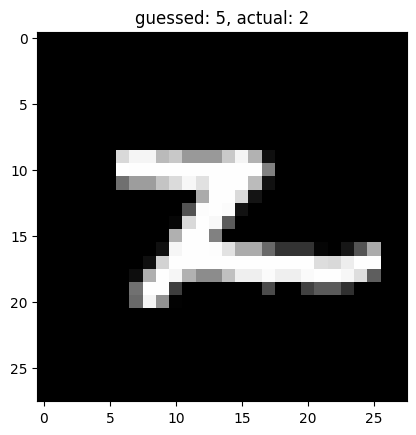

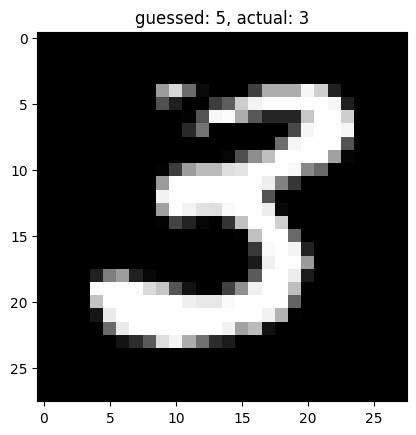

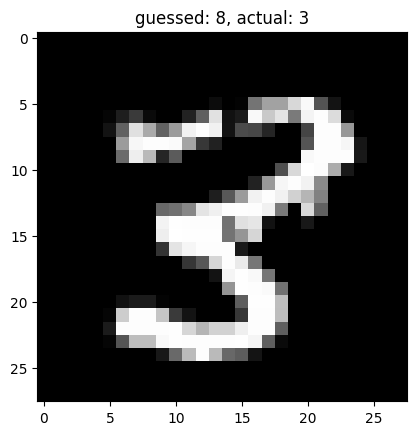

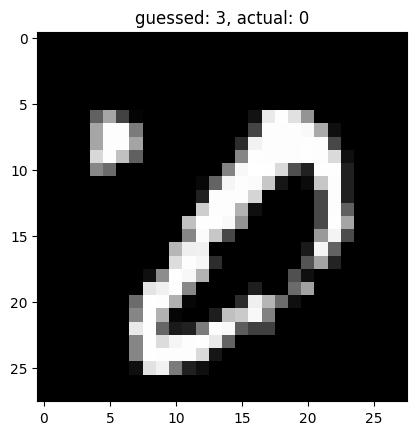

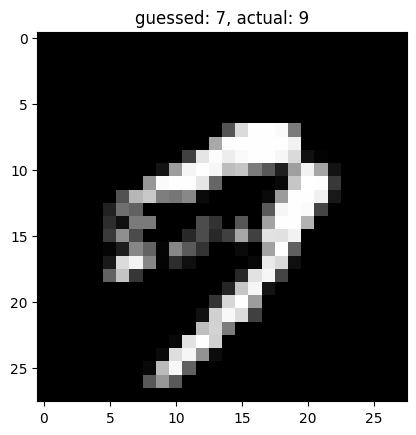

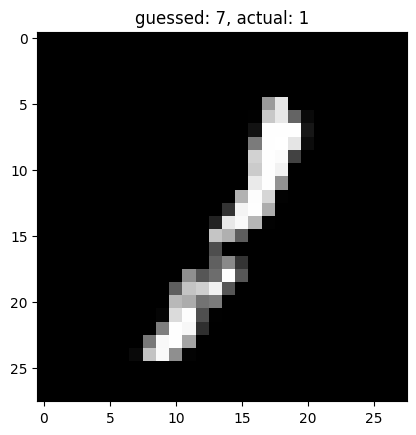

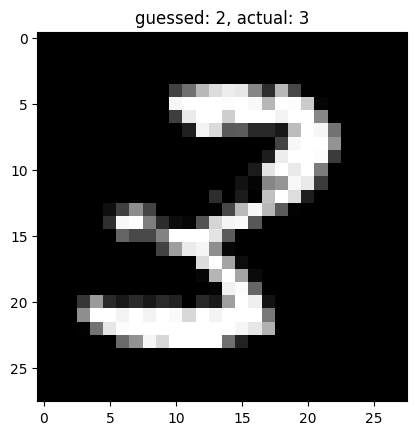

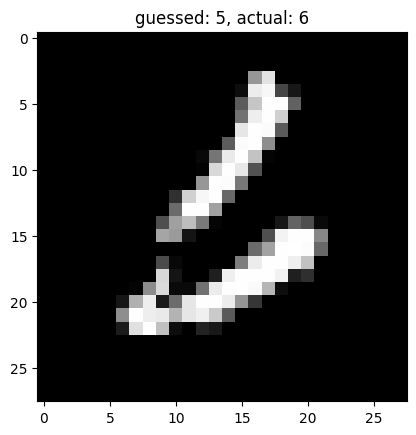

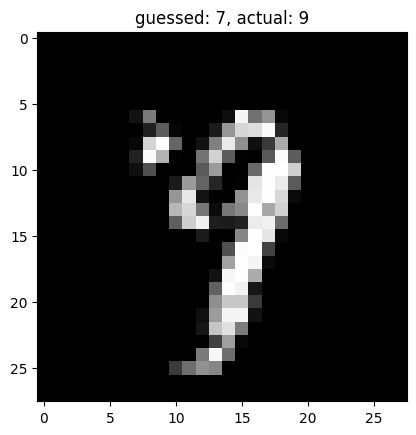

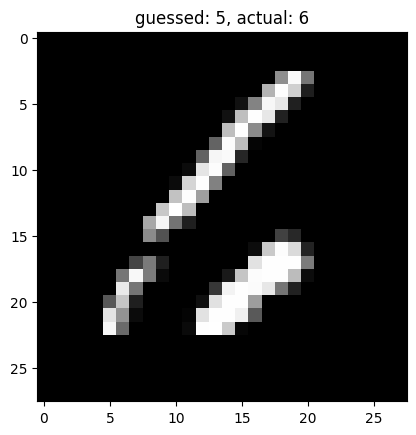

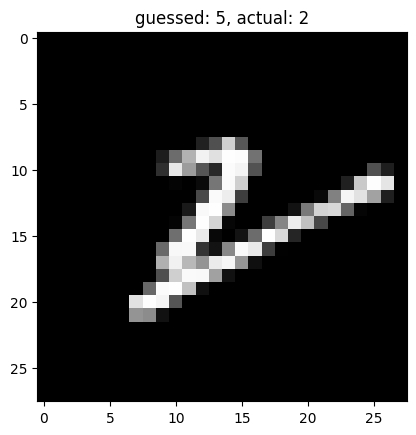

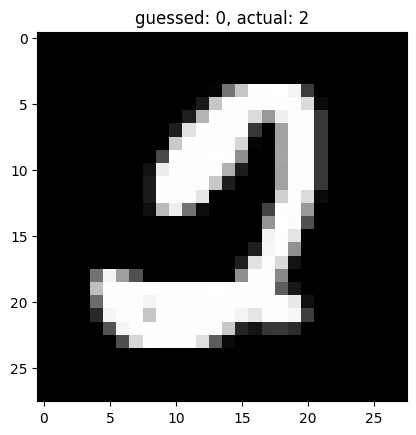

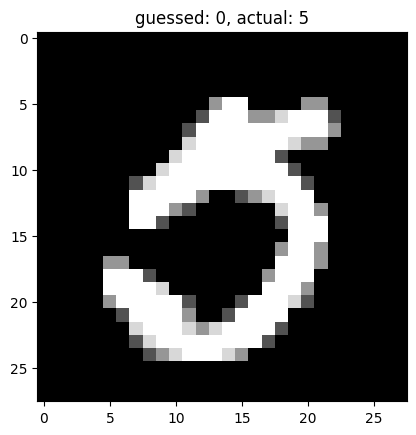

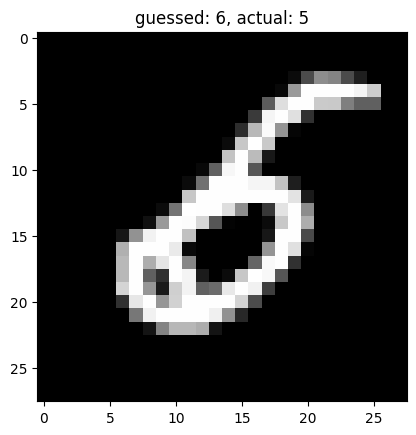

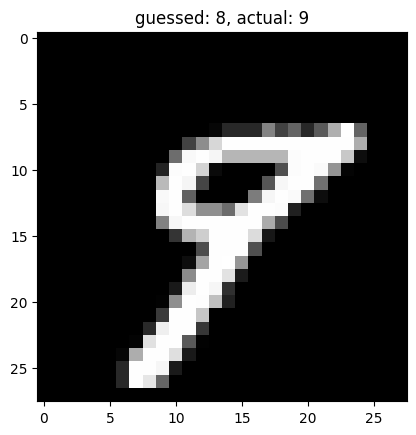

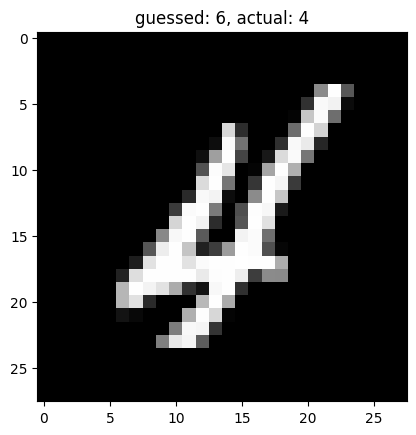

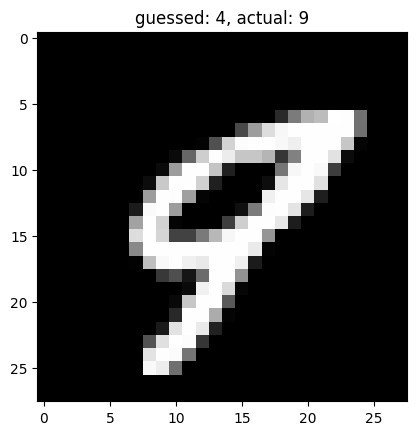

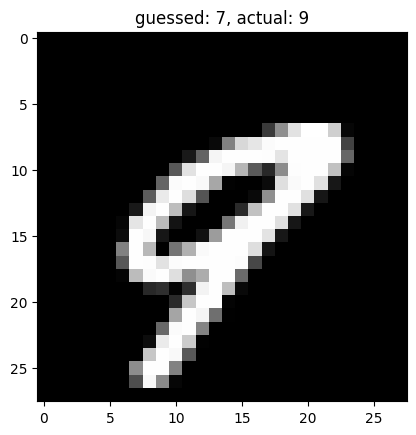

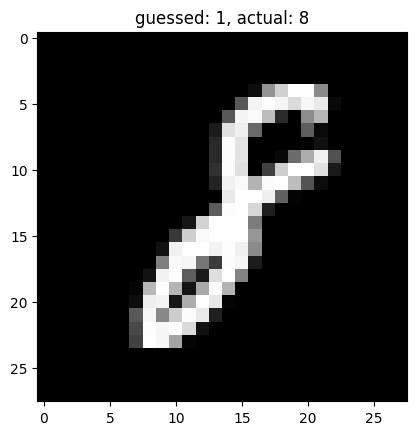

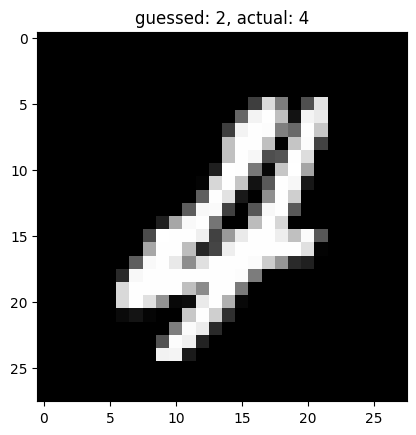

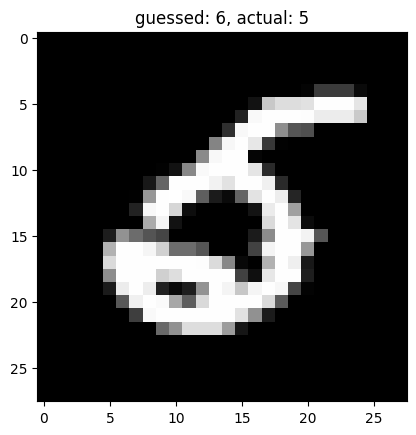

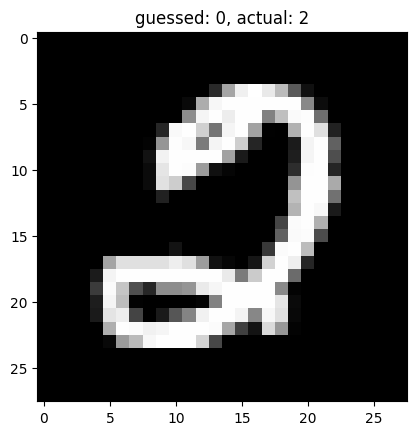

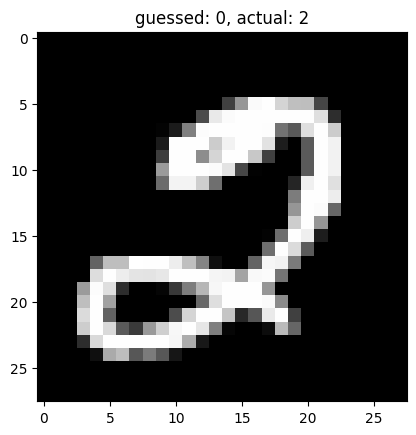

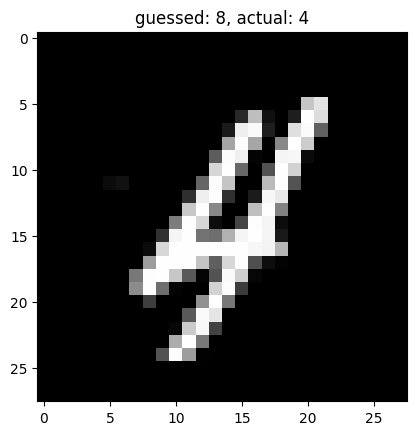

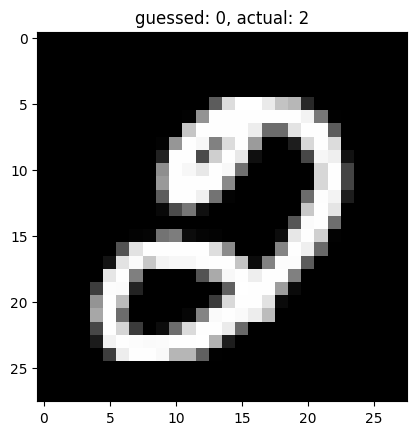

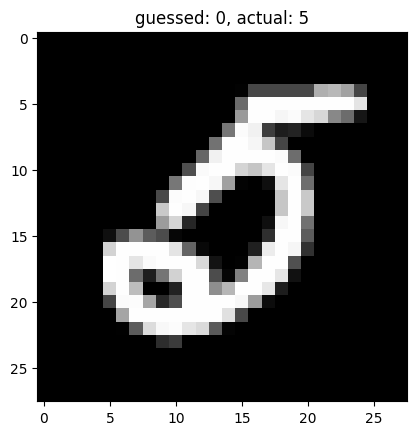

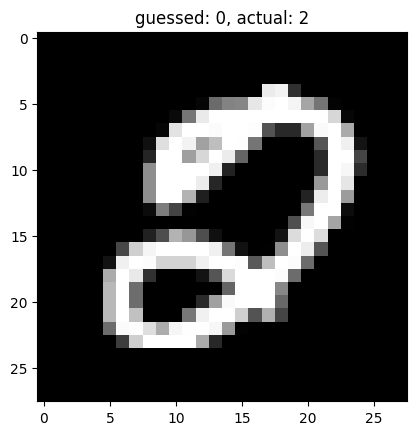

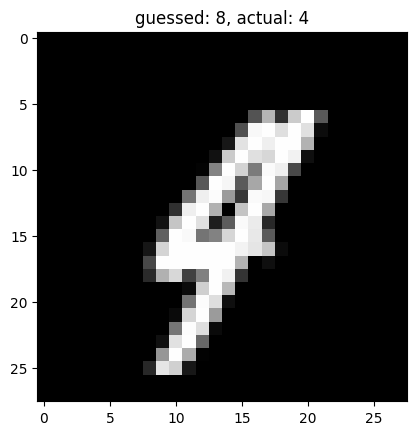

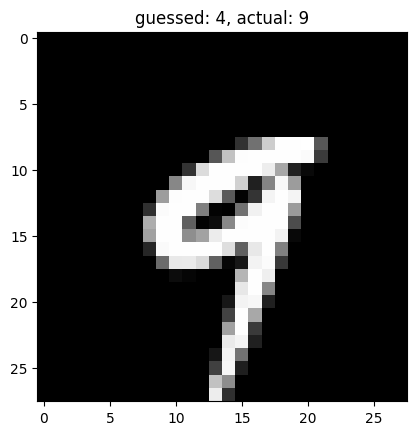

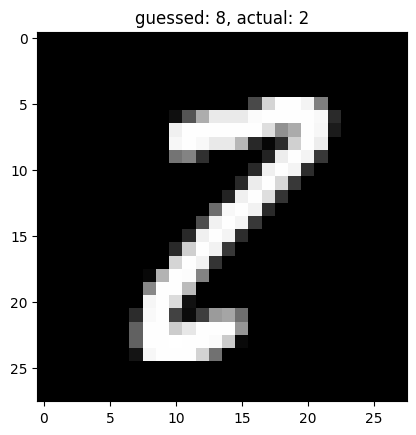

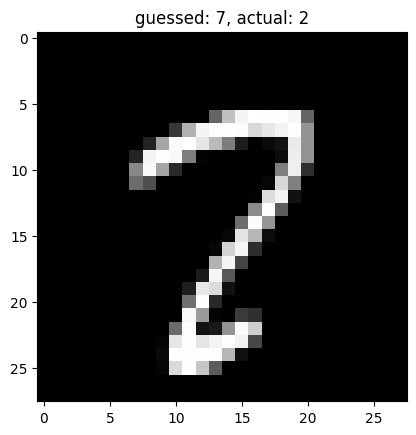

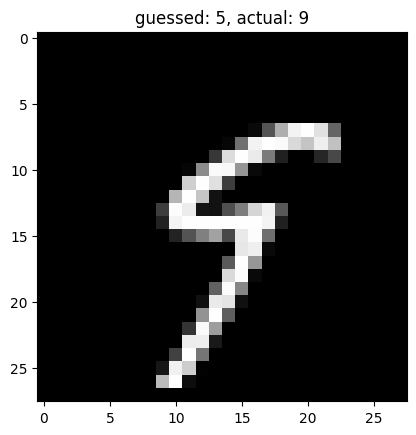

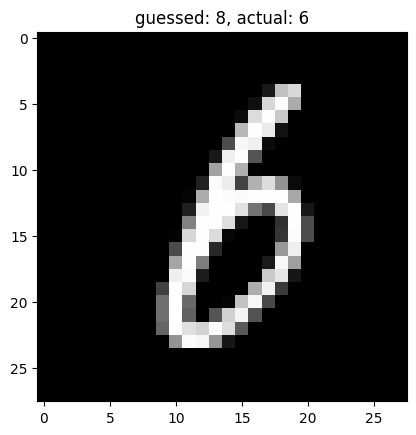

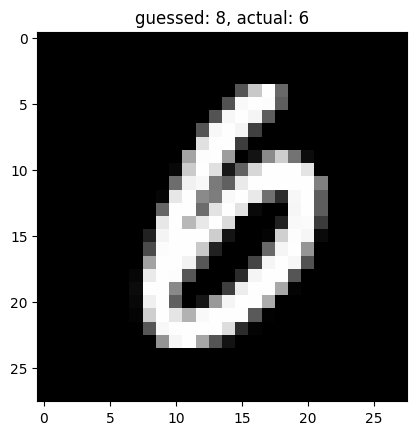

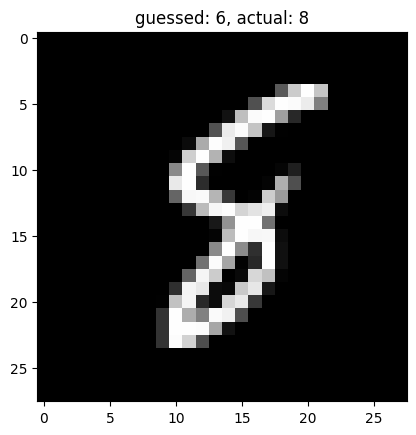

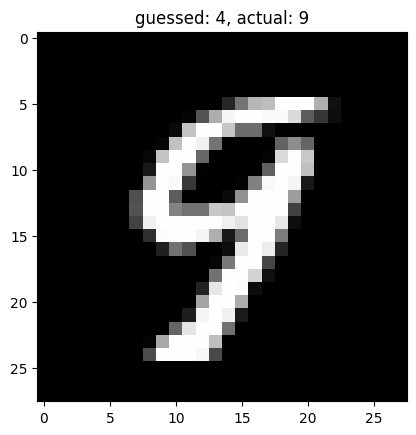

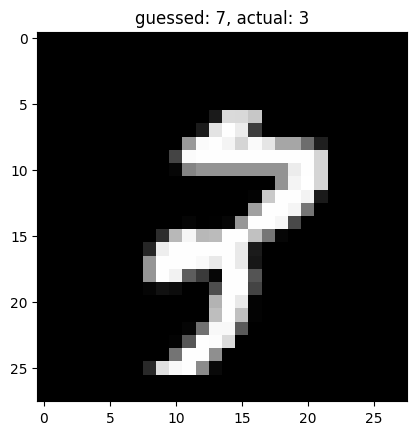

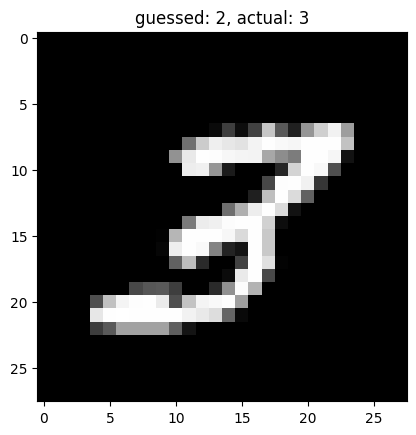

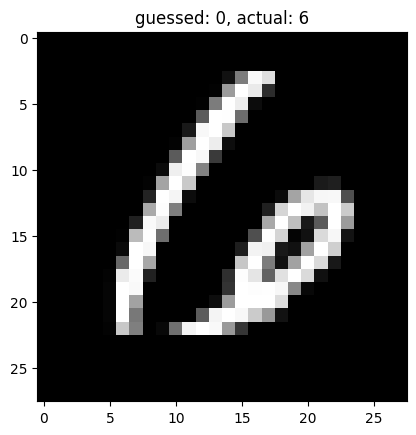

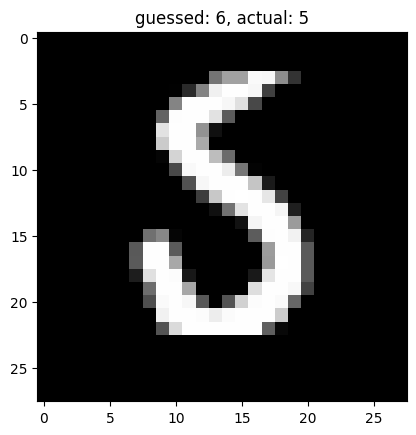

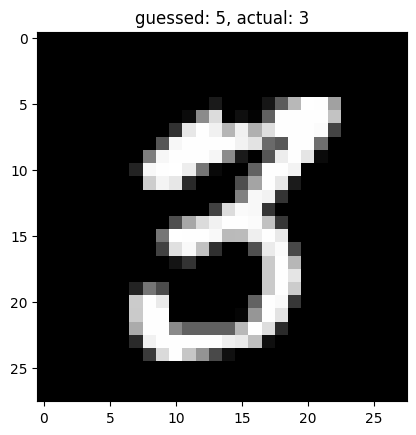

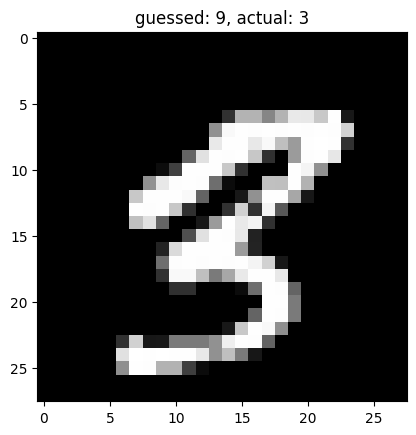

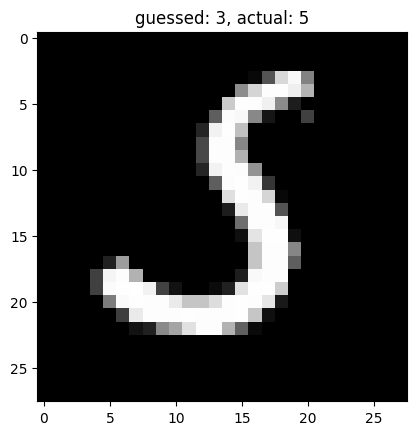

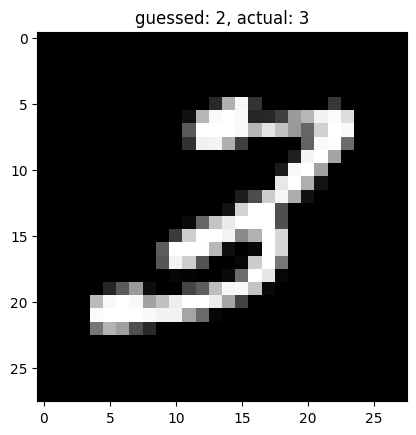

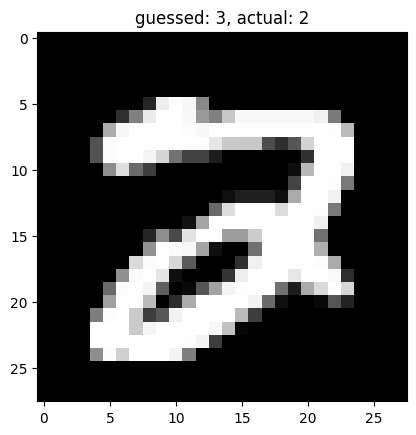

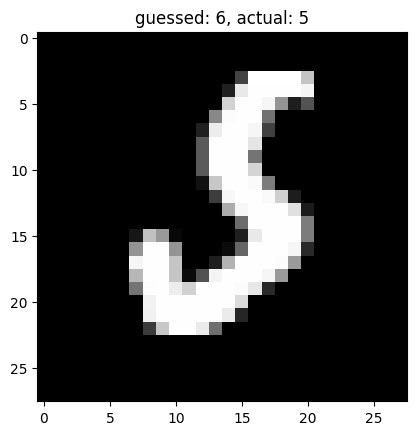

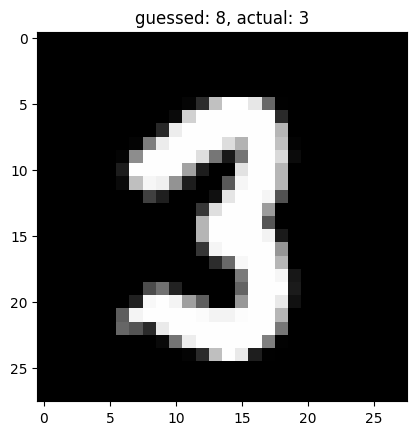

In [9]:

W_ih, b_h, W_ho, b_o = init_bias_0(60)
train((W_ih, b_h, W_ho, b_o), 2000)

# Testing
hidden_logits = tf.matmul(data.test_data, W_ih) + b_h
hidden_relu = tf.nn.relu(hidden_logits)
logits = tf.matmul(hidden_relu, W_ho) + b_o
test_preds = tf.argmax(tf.nn.softmax(logits), axis=1, output_type=tf.int32)

incorrects = tf.where(tf.not_equal(test_preds, data.test_labels)).numpy().flatten()
print(incorrects)

for i in incorrects:
    plt.title('guessed: {}, actual: {}'.format(test_preds[i], data.test_labels[i]))
    plt.imshow(test_images[i], cmap="Greys_r")
    plt.show()


### Common Image properties when classified wrong

- big circles e.g. in a six with small lines are cosidered a zero
- problems with not closed numbers e.g. an eight with open top is cosidered a four
- small circles in numbers containing them e.g. in a nine are kind of ignored -> net thinks it's a one
- too short lines: e.g. two with short line at the bottom is considered a seven
- missing lines or "Snörkelschrift" are problematic
